In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from model_collection import ModelCollection
from plotting import grouped_boxplot_with_table

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

#https://stackoverflow.com/a/64823806/5217293
import joblib

import joypy
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('data/matched/all_years_final_months.csv', parse_dates=['time'])

In [3]:
X, y = df.drop(columns=['value', 'time'], axis=1), df['value']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [5]:
# groups = (X_train['latitude'].astype(str) + ',' + X_train['longitude'].astype(str)).drop_duplicates().reset_index(drop=True)
groups = X_train['latitude'].astype(str) + ',' + X_train['longitude'].astype(str)

In [6]:
X_train = X_train.to_numpy(dtype='float', na_value=np.nan)
y_train = y_train.to_numpy(dtype='float', na_value=np.nan)
X_test = X_test.to_numpy(dtype='float', na_value=np.nan)
y_test = y_test.to_numpy(dtype='float', na_value=np.nan)

In [7]:
gkf = list(GroupKFold(10).split(X_train, y_train, groups=groups))

In [8]:
mc = ModelCollection(X_train, y_train, cv=10)

# Hyperparameters

In [ ]:
mc.tune_hyperparameters()

In [226]:
joblib.dump(mc.hyperparameters_, 'data/model_runs/hyperparameters-reduced-model-set-one-hot-encoded.pkl')

AttributeError: 'ModelCollection' object has no attribute 'hyperparameters_'

In [228]:
mc.hyperparameters_ = joblib.load('data/')

In [41]:
for k, v in mc.hyperparameters_.items():
    v.cv_results_
    thing = pd.DataFrame(v.cv_results_)
    thing = thing[thing.columns.difference([
        'std_fit_time',
        'mean_score_time', 
        'std_score_time',
        'split0_test_score',
        'split1_test_score',
        'split2_test_score',
        'split3_test_score',
        'split4_test_score',
        'std_test_score',
    ])].set_index('rank_test_score').sort_index()
    print(k, thing.shape[0])

Elastic Net 4000
Bayesian Ridge 81
SVR 300


mean_fit_time  mean_test_score param_mlp__hidden_layer_sizes  \
rank_test_score                                                                 
1                    22.999522         0.249035                            10   
2                   192.576751         0.214513                 (10, 100, 50)   
3                    52.161709         0.128670                            50   
4                    57.394485         0.047854                           100   
5                   117.099923        -0.357232                 (100, 50, 10)   
6                   184.090808        -0.535467                 (10, 50, 100)   

                                                     params  
rank_test_score                                              
1                           {'mlp__hidden_layer_sizes': 10}  
2                {'mlp__hidden_layer_sizes': (10, 100, 50)}  
3                           {'mlp__hidden_layer_sizes': 50}  
4                          {'mlp__hidden_layer_sizes': 100}  
5                {'mlp__hidden_layer_sizes': (100, 50, 10)}  
6                {'mlp__hidden_layer_sizes': (10, 50, 100)}

MLP 6
Ada Boost 33
Random Forest 108
Extra Trees 108
Gradient Boost 297
XGBoost 33


In [12]:
mc.update_models_from_hyperparamters()

# CV

In [10]:
mc.compute_cross_validation_scores();

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/geospatial/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [11]:
mc.save_model_cross_val_scores('data/model_runs/all_years_months-cv.pcl')

In [10]:
mc.load_model_cross_val_scores('data/months-site-based-cv.pcl')

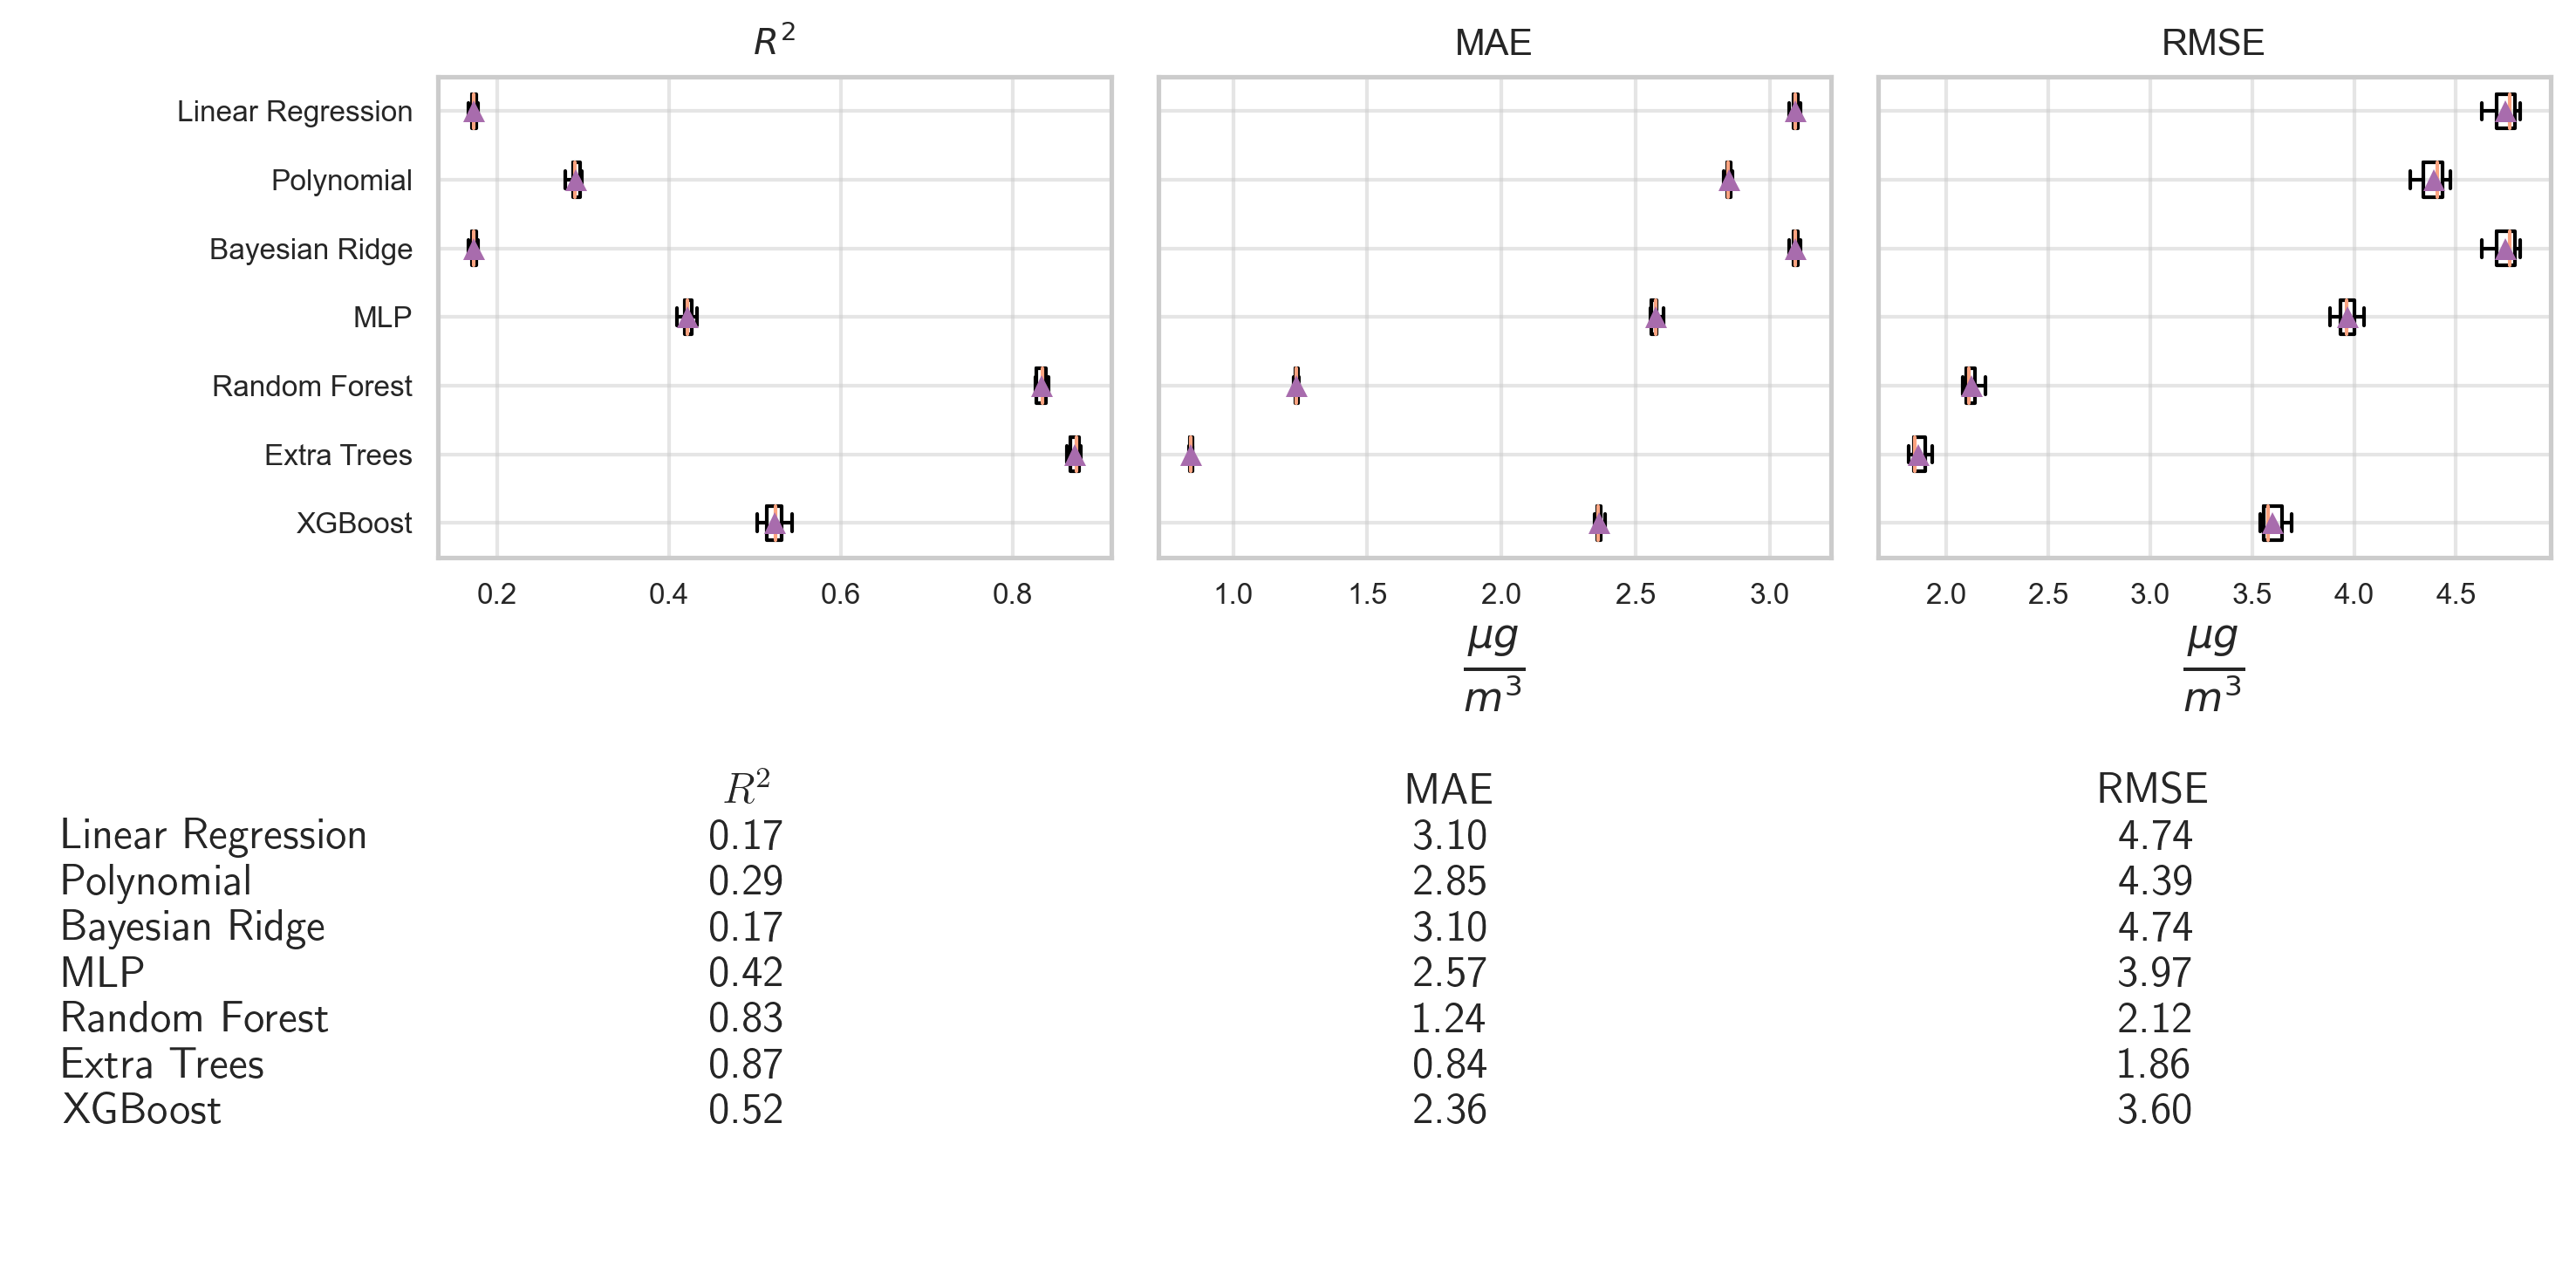

In [12]:
labels, scores = map(list, zip(*mc.cross_val_scores_.items()))
grouped_boxplot_with_table(scores, labels, save=False, fs=8);

# Fit

In [13]:
mc.fit()

  0%|          | 0/7 [00:00<?, ?it/s]

{'Linear Regression': 1.0601348876953125,
 'Polynomial': 25.254211902618408,
 'Bayesian Ridge': 0.9302690029144287,
 'MLP': 335.3028287887573,
 'Random Forest': 1276.6919648647308,
 'Extra Trees': 467.67453598976135,
 'XGBoost': 23.54511308670044}

In [14]:
mc.save('data/model_runs/trained-all_years_months.pcl')

In [9]:
mc.load('data/model_runs/trained-monthly.pcl')

In [15]:
scores = pd.DataFrame(mc.compute_scores(X_test, y_test)).T

In [16]:
predictions = pd.DataFrame(mc.predict(X_test))

In [17]:
predictions['True'] = y_test

# Figures

## Prediction Accuracy and Fit Times

In [19]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# colormap from: https://www.schemecolor.com/announce.php

# https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html#directly-creating-a-segmented-colormap-from-a-list
colors = ["#9CDEF6", "#6CB0F2", "#6549DA", "#A86CAD", "#FCA481", "#FDCB66"]
announce = LinearSegmentedColormap.from_list("Announce", colors)

In [20]:
nn_color = "#FCA481"
tree_color = "#6549DA"
linear_color = "#6CB0F2"

colors = [linear_color] * 3 + [nn_color] * 1 + [tree_color] * 3 + ['#FDCB66']

Bins are from the [AQI Breakpoints for particulates](https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html)

In [21]:
bins = [0.0, 12.1, 35.5, 55.5, 150.5, 250.5, 350.5, 500.5, 99999.9]
cat = ['GOOD', 'MODERATE', 'UNHEALTHY FOR SENSITIVE', 'UNHEALTHY', 'VERY UNHEALTHY', 'HAZARDOUS', 'HAZARDOUS', 'HAZARDOUS']
index = [f'{a}-{b-.1:.1f} ({c})' for a, b, c in zip(bins[0:-1], bins[1:], cat)]

In [22]:
epa = pd.DataFrame({a : np.histogram(predictions[a], bins=bins)[0] for a in predictions.columns}, index=index)
epa

Linear Regression  Polynomial  \
0.0-12.0 (GOOD)                                 196119      186009   
12.1-35.4 (MODERATE)                              3958       13900   
35.5-55.4 (UNHEALTHY FOR SENSITIVE)                  0           0   
55.5-150.4 (UNHEALTHY)                               0           0   
150.5-250.4 (VERY UNHEALTHY)                         0           0   
250.5-350.4 (HAZARDOUS)                              0           0   
350.5-500.4 (HAZARDOUS)                              0           0   
500.5-99999.8 (HAZARDOUS)                            0           0   

                                     Bayesian Ridge     MLP  Random Forest  \
0.0-12.0 (GOOD)                              196121  179940         174193   
12.1-35.4 (MODERATE)                           3957   20239          25693   
35.5-55.4 (UNHEALTHY FOR SENSITIVE)               0      24            312   
55.5-150.4 (UNHEALTHY)                            0       0             81   
150.5-250.4 (VERY UNHEALTHY)                      0       0              0   
250.5-350.4 (HAZARDOUS)                           0       0              0   
350.5-500.4 (HAZARDOUS)                           0       0              0   
500.5-99999.8 (HAZARDOUS)                         0       0              0   

                                     Extra Trees  XGBoost    True  
0.0-12.0 (GOOD)                           171487   181022  169778  
12.1-35.4 (MODERATE)                       28248    19097   29880  
35.5-55.4 (UNHEALTHY FOR SENSITIVE)          431      114     493  
55.5-150.4 (UNHEALTHY)                       112       29     127  
150.5-250.4 (VERY UNHEALTHY)                   1        0       1  
250.5-350.4 (HAZARDOUS)                        0        0       0  
350.5-500.4 (HAZARDOUS)                        0        0       0  
500.5-99999.8 (HAZARDOUS)                      0        0       0

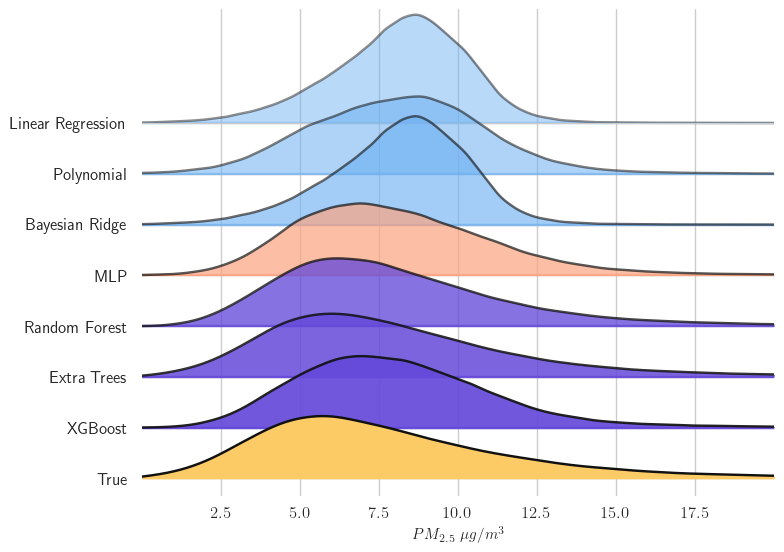

In [23]:
fig, axes = joypy.joyplot(
    predictions, 
    fade=True, 
    color = colors,
    x_range=(0, 20), 
    grid=True
)

axes[-1].set_xlabel('$PM_{2.5} ~ \mu g/m^3$');

# fig.savefig(os.path.join(paths.figures, 'densities.svg'), format='svg', bbox_inches = "tight")

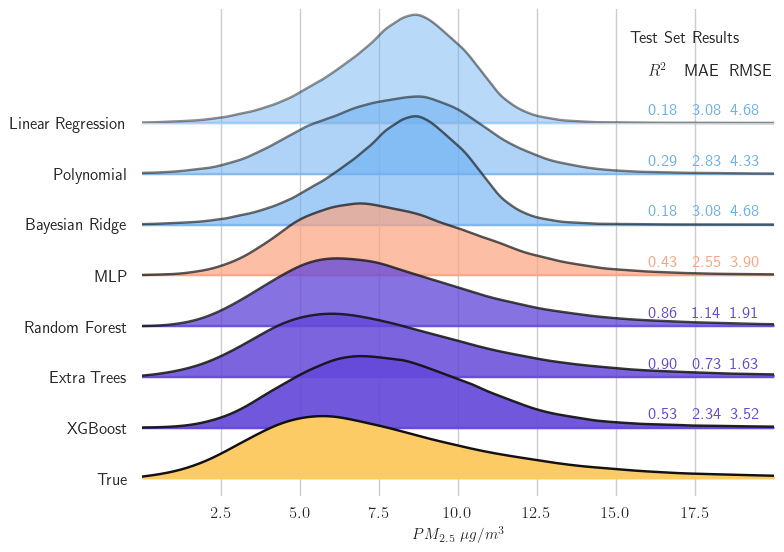

In [24]:
linear = ["Linear Regression", "Polynomial", "Bayesian Ridge"]
trees = ["Random Forest", "Extra Trees", "XGBoost"]
nn = ["MLP"]

fig, axes = joypy.joyplot(predictions, fade=True, color=colors, x_range=(0, 20), grid=True)

axes[-1].set_xlabel('$PM_{2.5} ~ \mu g/m^3$')

ax = axes[0]

# CV labels
# ax.text(0.07, .75, 'Cross-validated Results', ha='center', transform=ax.transAxes)
# ax.text(0.01, .5, '$R^2$', ha='left', transform=ax.transAxes)
# ax.text(0.07, .5, 'MAE', ha='left', transform=ax.transAxes)
# ax.text(0.14, .5, 'RMSE', ha='left', transform=ax.transAxes)

# Real Labels
ax.text(0.86, .75, 'Test Set Results', ha='center', transform=ax.transAxes)
ax.text(0.8, .5, '$R^2$', ha='left', transform=ax.transAxes)
ax.text(0.86, .5, 'MAE', ha='left', transform=ax.transAxes)
ax.text(0.93, .5, 'RMSE', ha='left', transform=ax.transAxes)

for ax in axes[:-2]:
    model = ax.get_yticklabels()[0].get_text()
    perf = scores.loc[model]
    if model in linear:
        text_color = linear_color
    elif model in trees:
        text_color = tree_color
    else:
        text_color = nn_color
        
    ax.text(0.8, .2, f'{perf["r2"]:.2f}', ha='left', transform=ax.transAxes, color=text_color)
    ax.text(0.87, .2, f'{perf["mae"]:.2f}', ha='left', transform=ax.transAxes, color=text_color)
    ax.text(0.93, .2, f'{perf["rmse"]:.2f}', ha='left', transform=ax.transAxes, color=text_color)
    
#     cv_res = results.loc[model]
#     ax.text(0.06, .2, f'{cv_res["CV R2"]:.2f}', ha='right', transform=ax.transAxes, color=text_color)
#     ax.text(0.13, .2, f'{cv_res["CV MAE"]:.2f}', ha='right', transform=ax.transAxes, color=text_color)
#     ax.text(0.2, .2, f'{cv_res["CV RMSE"]:.2f}', ha='right', transform=ax.transAxes, color=text_color)

# fig.savefig(os.path.join(paths.figures, 'densities-with-scores.svg'), format='svg')

In [25]:
# https://stackoverflow.com/a/29347731/5217293

import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import matplotlib.patches as patches
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFilter

def gradient_fill(x, y, fill_color=None, ax=None, zfunc=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    if zfunc is None:
        h, w = 100, 1
        z = np.empty((h, w, 4), dtype=float)
        rgb = mcolors.colorConverter.to_rgb(fill_color)
        z[:,:,:3] = rgb
        z[:,:,-1] = np.linspace(0, alpha, h)[:,None]
    else:
        z = zfunc(x, y, fill_color=fill_color, alpha=alpha)
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = patches.Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    ax.autoscale(True)
    return line, im

def zfunc(x, y, fill_color='k', alpha=1.0):
    scale = 10
    x = (x*scale).astype(int)
    y = (y*scale).astype(int)
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()

    w, h = xmax-xmin, ymax-ymin
    z = np.empty((h, w, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb

    # Build a z-alpha array which is 1 near the line and 0 at the bottom.
    img = Image.new('L', (w, h), 0)  
    draw = ImageDraw.Draw(img)
    xy = np.column_stack([x, y])
    xy -= xmin, ymin
    # Draw a blurred line using PIL
    draw.line(list(map(tuple, xy)), fill=255, width=15)
    img = img.filter(ImageFilter.GaussianBlur(radius=100))
    # Convert the PIL image to an array
    zalpha = np.asarray(img).astype(float) 
    zalpha *= alpha/zalpha.max()
    # make the alphas melt to zero at the bottom
    n = zalpha.shape[0] // 4
    zalpha[:n] *= np.linspace(0, 1, n)[:, None]
    z[:,:,-1] = zalpha
    return z

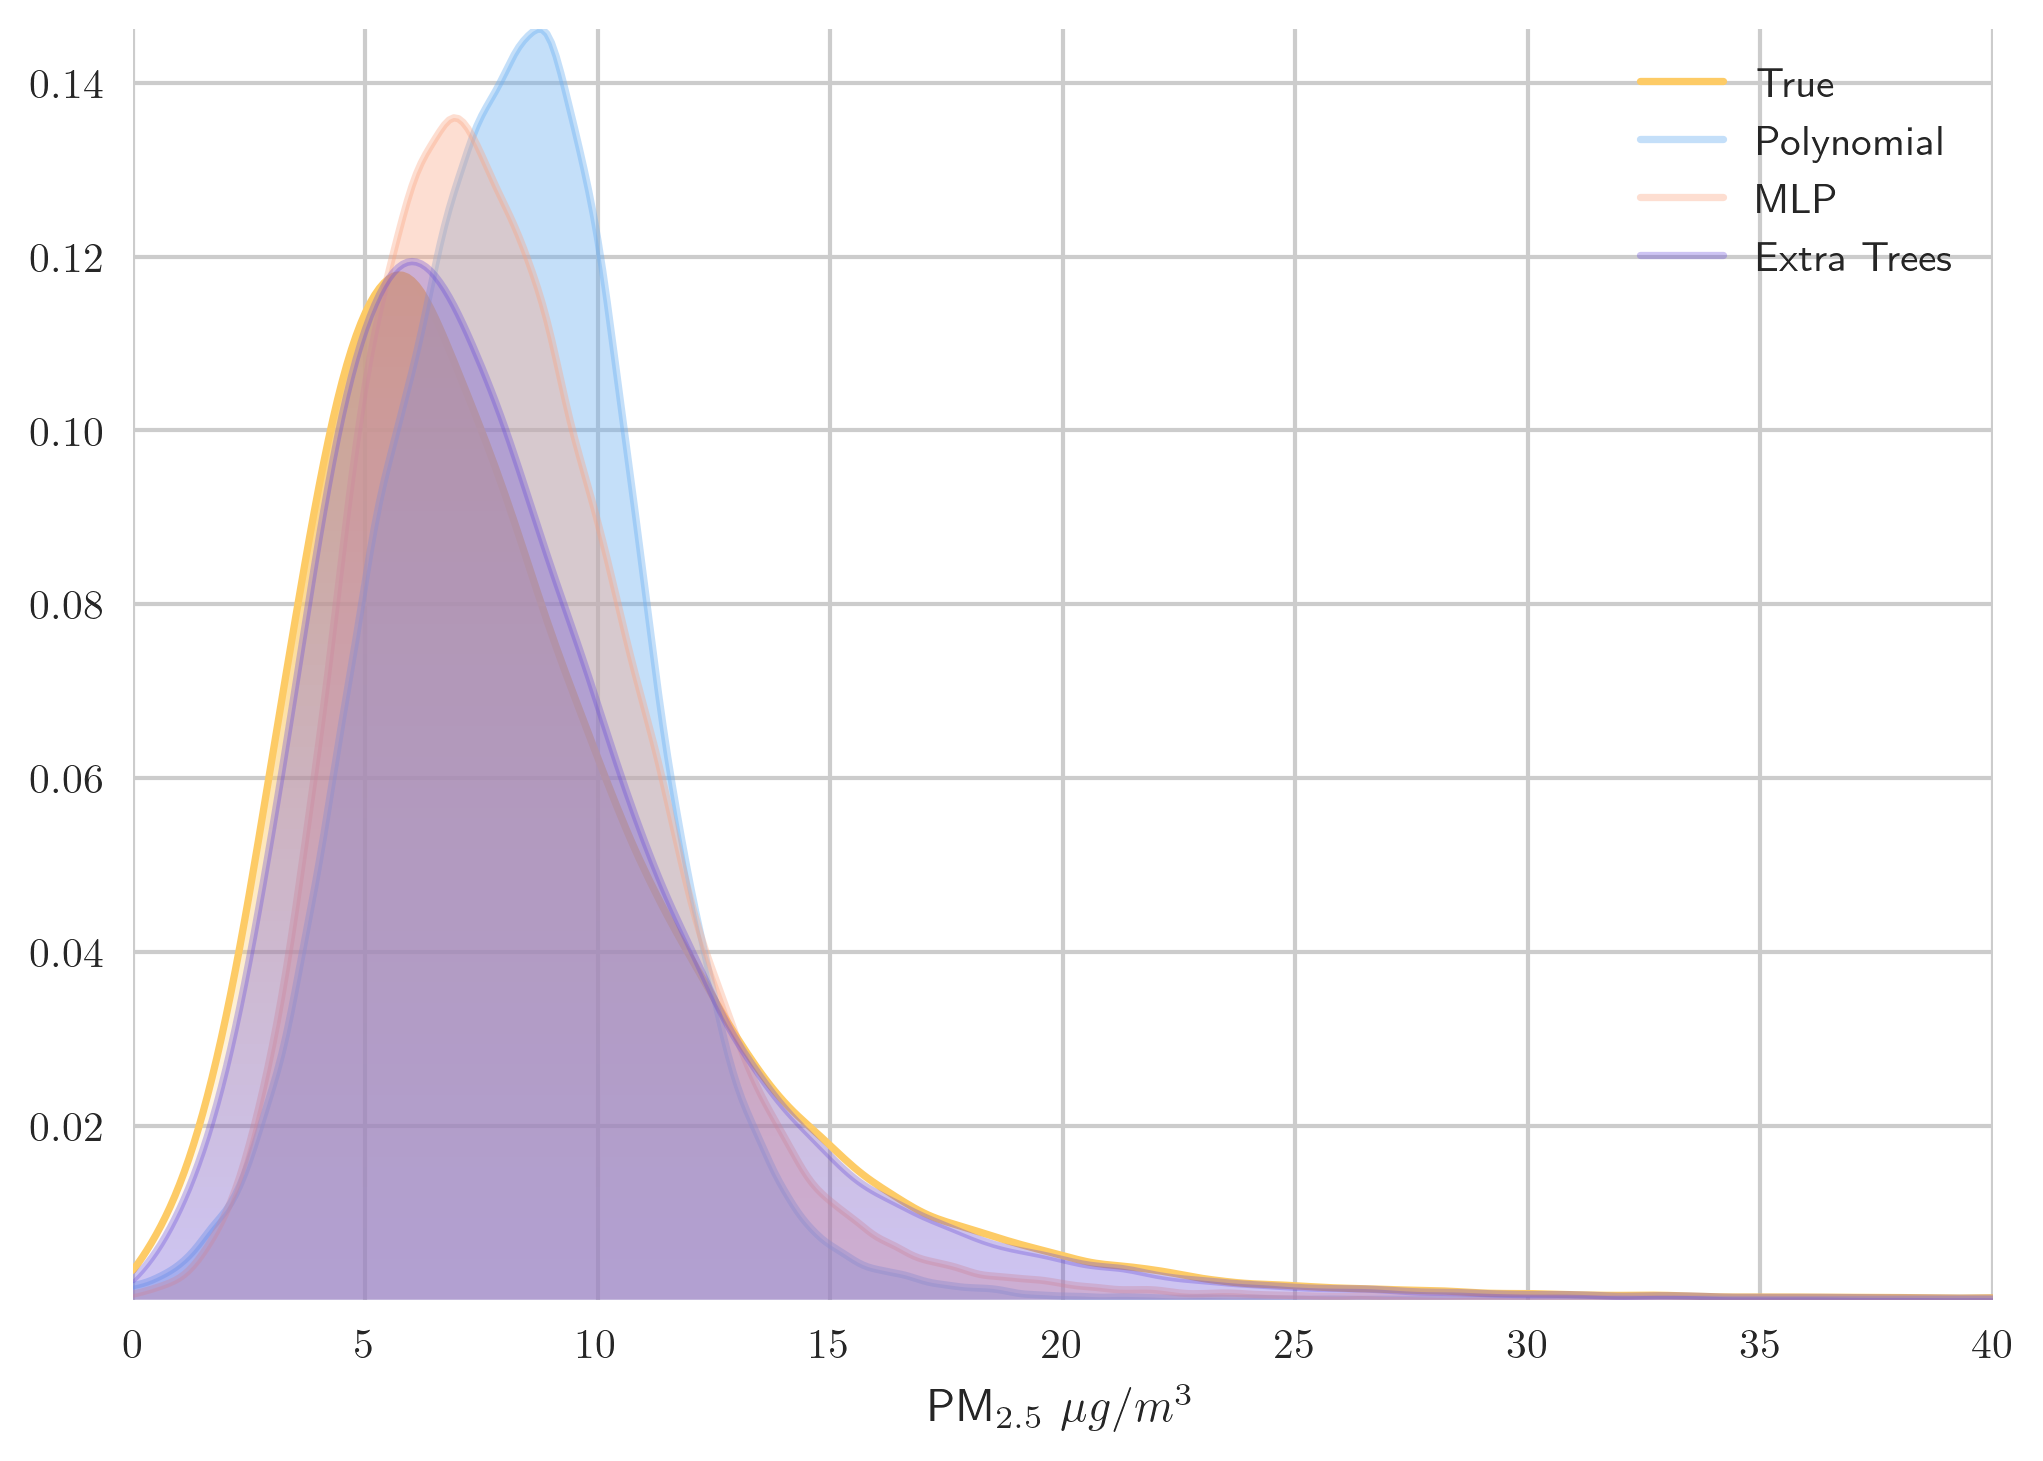

In [30]:
from scipy.stats import gaussian_kde

x_range = np.arange(0, 100, 0.1)

densities = {}

fig, ax = plt.subplots(dpi=300)
lines = []

gkde = gaussian_kde(predictions['True'])
densities['True'] = gkde
density = gkde.evaluate(x_range)
lines.append(gradient_fill(x_range, density, ax=ax, fill_color='#FDCB66', color='#FDCB66')[0])

alpha=0.4

for idx, (column, color) in enumerate(zip(['Polynomial', 'MLP', 'Extra Trees'], [linear_color, nn_color, tree_color])):
    gkde = gaussian_kde(predictions[column])
    densities[column] = gkde
    density = gkde.evaluate(x_range)
    lines.append(gradient_fill(x_range, density, zfunc=zfunc, ax=ax, fill_color=color, color=color, alpha=alpha - idx*alpha*.1)[0])

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(False)

ax.legend(lines, ['True', 'Polynomial', 'MLP', 'Extra Trees'], loc='upper right')
ax.set_xlabel('PM$_{2.5}~\mu g/m^3$')

ax.set_xlim((0, 40));

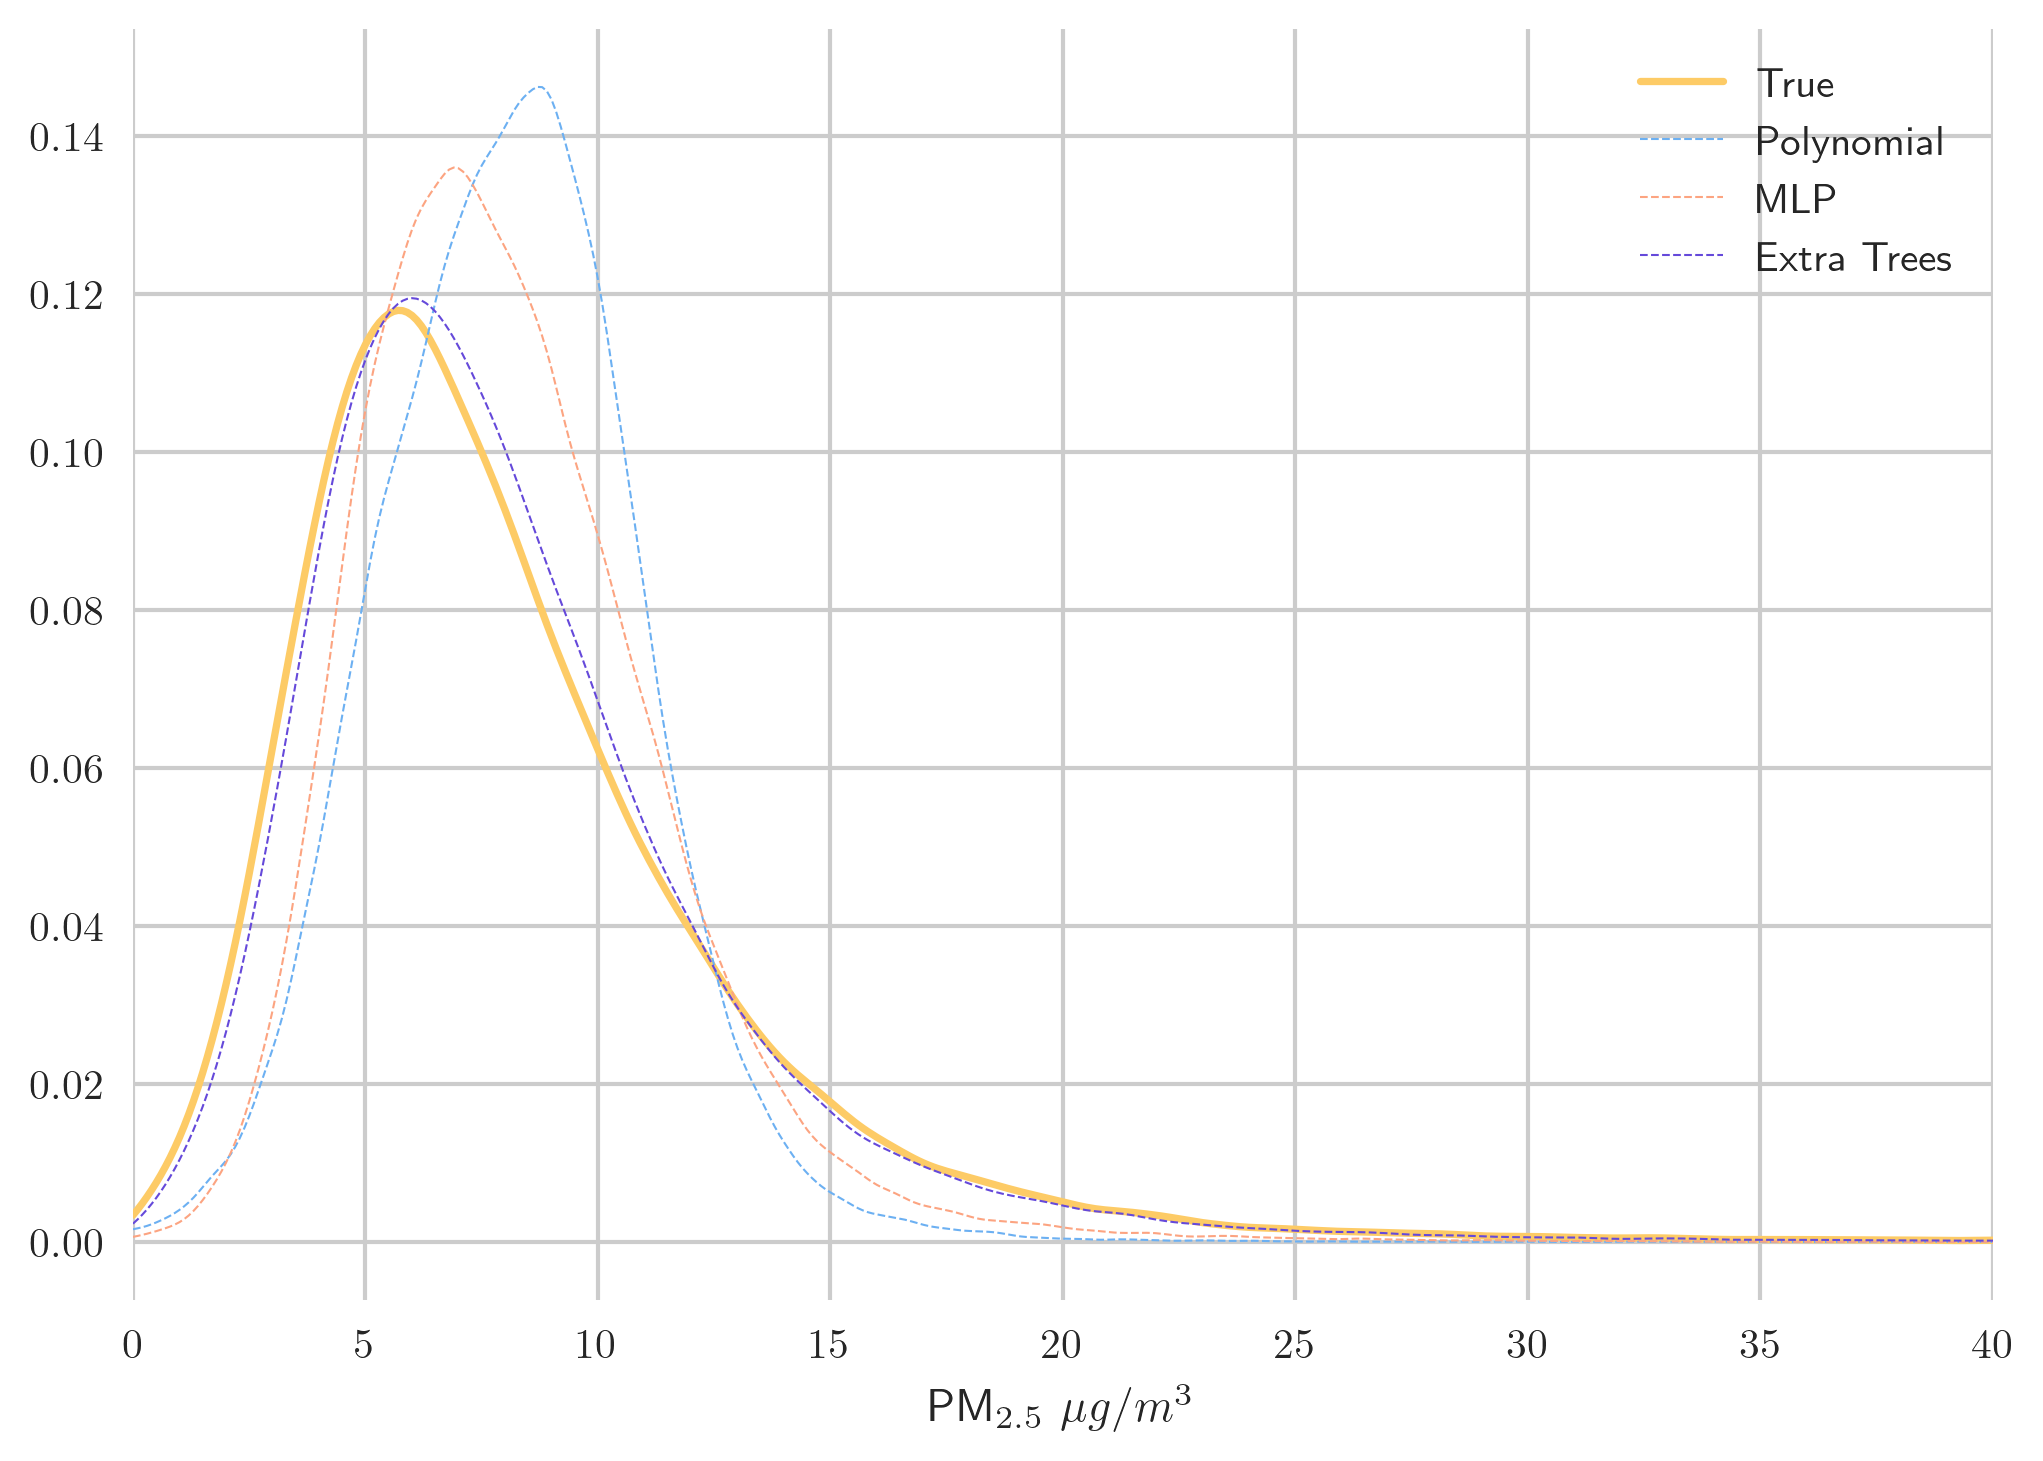

In [35]:
from scipy.stats import gaussian_kde

x_range = np.arange(0, 100, 0.1)

densities = {}

fig, ax = plt.subplots(dpi=300)
lines = []

gkde = gaussian_kde(predictions['True'])
densities['True'] = gkde
density = gkde.evaluate(x_range)
lines.append(ax.plot(x_range, density, color='#FDCB66')[0])

alpha=0.4

for idx, (column, color) in enumerate(zip(['Polynomial', 'MLP', 'Extra Trees'], [linear_color, nn_color, tree_color])):
    gkde = gaussian_kde(predictions[column])
    densities[column] = gkde
    density = gkde.evaluate(x_range)
    lines.append(ax.plot(x_range, density, ls='--', color=color, lw=0.5)[0])

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(False)

ax.legend(lines, ['True', 'Polynomial', 'MLP', 'Extra Trees'], loc='upper right')
ax.set_xlabel('PM$_{2.5}~\mu g/m^3$')

ax.set_xlim((0, 40));

In [36]:
bin_pairs = [(a, b-.1) for a, b in zip(bins[0:-1], bins[1:])]
cat = ['GOOD', 'MODERATE', 'UNHEALTHY FOR SENSITIVE', 'UNHEALTHY', 'VERY UNHEALTHY', 'HAZARDOUS', 'HAZARDOUS', 'HAZARDOUS']
index = [f'{a}-{b-.1:.1f} ({c})' for a, b, c in zip(bins[0:-1], bins[1:], cat)]

In [37]:
get_probs = lambda gkde, xs : np.round([np.trapz(gkde(xx), x=xx) for xx in xs], 5)

In [38]:
pd.DataFrame({a : get_probs(densities[a], bin_pairs) for a in densities.keys()}, index=index)[['Polynomial', 'MLP', 'Extra Trees', 'True']]

Polynomial      MLP  Extra Trees     True
0.0-12.0 (GOOD)                         0.29340  0.27888      0.25609  0.25611
12.1-35.4 (MODERATE)                    0.52058  0.51122      0.46014  0.45054
35.5-55.4 (UNHEALTHY FOR SENSITIVE)     0.00000  0.00018      0.00284  0.00333
55.5-150.4 (UNHEALTHY)                  0.00000  0.00000      0.00087  0.00145
150.5-250.4 (VERY UNHEALTHY)            0.00000  0.00000      0.00000  0.00000
250.5-350.4 (HAZARDOUS)                 0.00000  0.00000      0.00000  0.00000
350.5-500.4 (HAZARDOUS)                 0.00000  0.00000      0.00000  0.00000
500.5-99999.8 (HAZARDOUS)               0.00000  0.00000      0.00000  0.00000

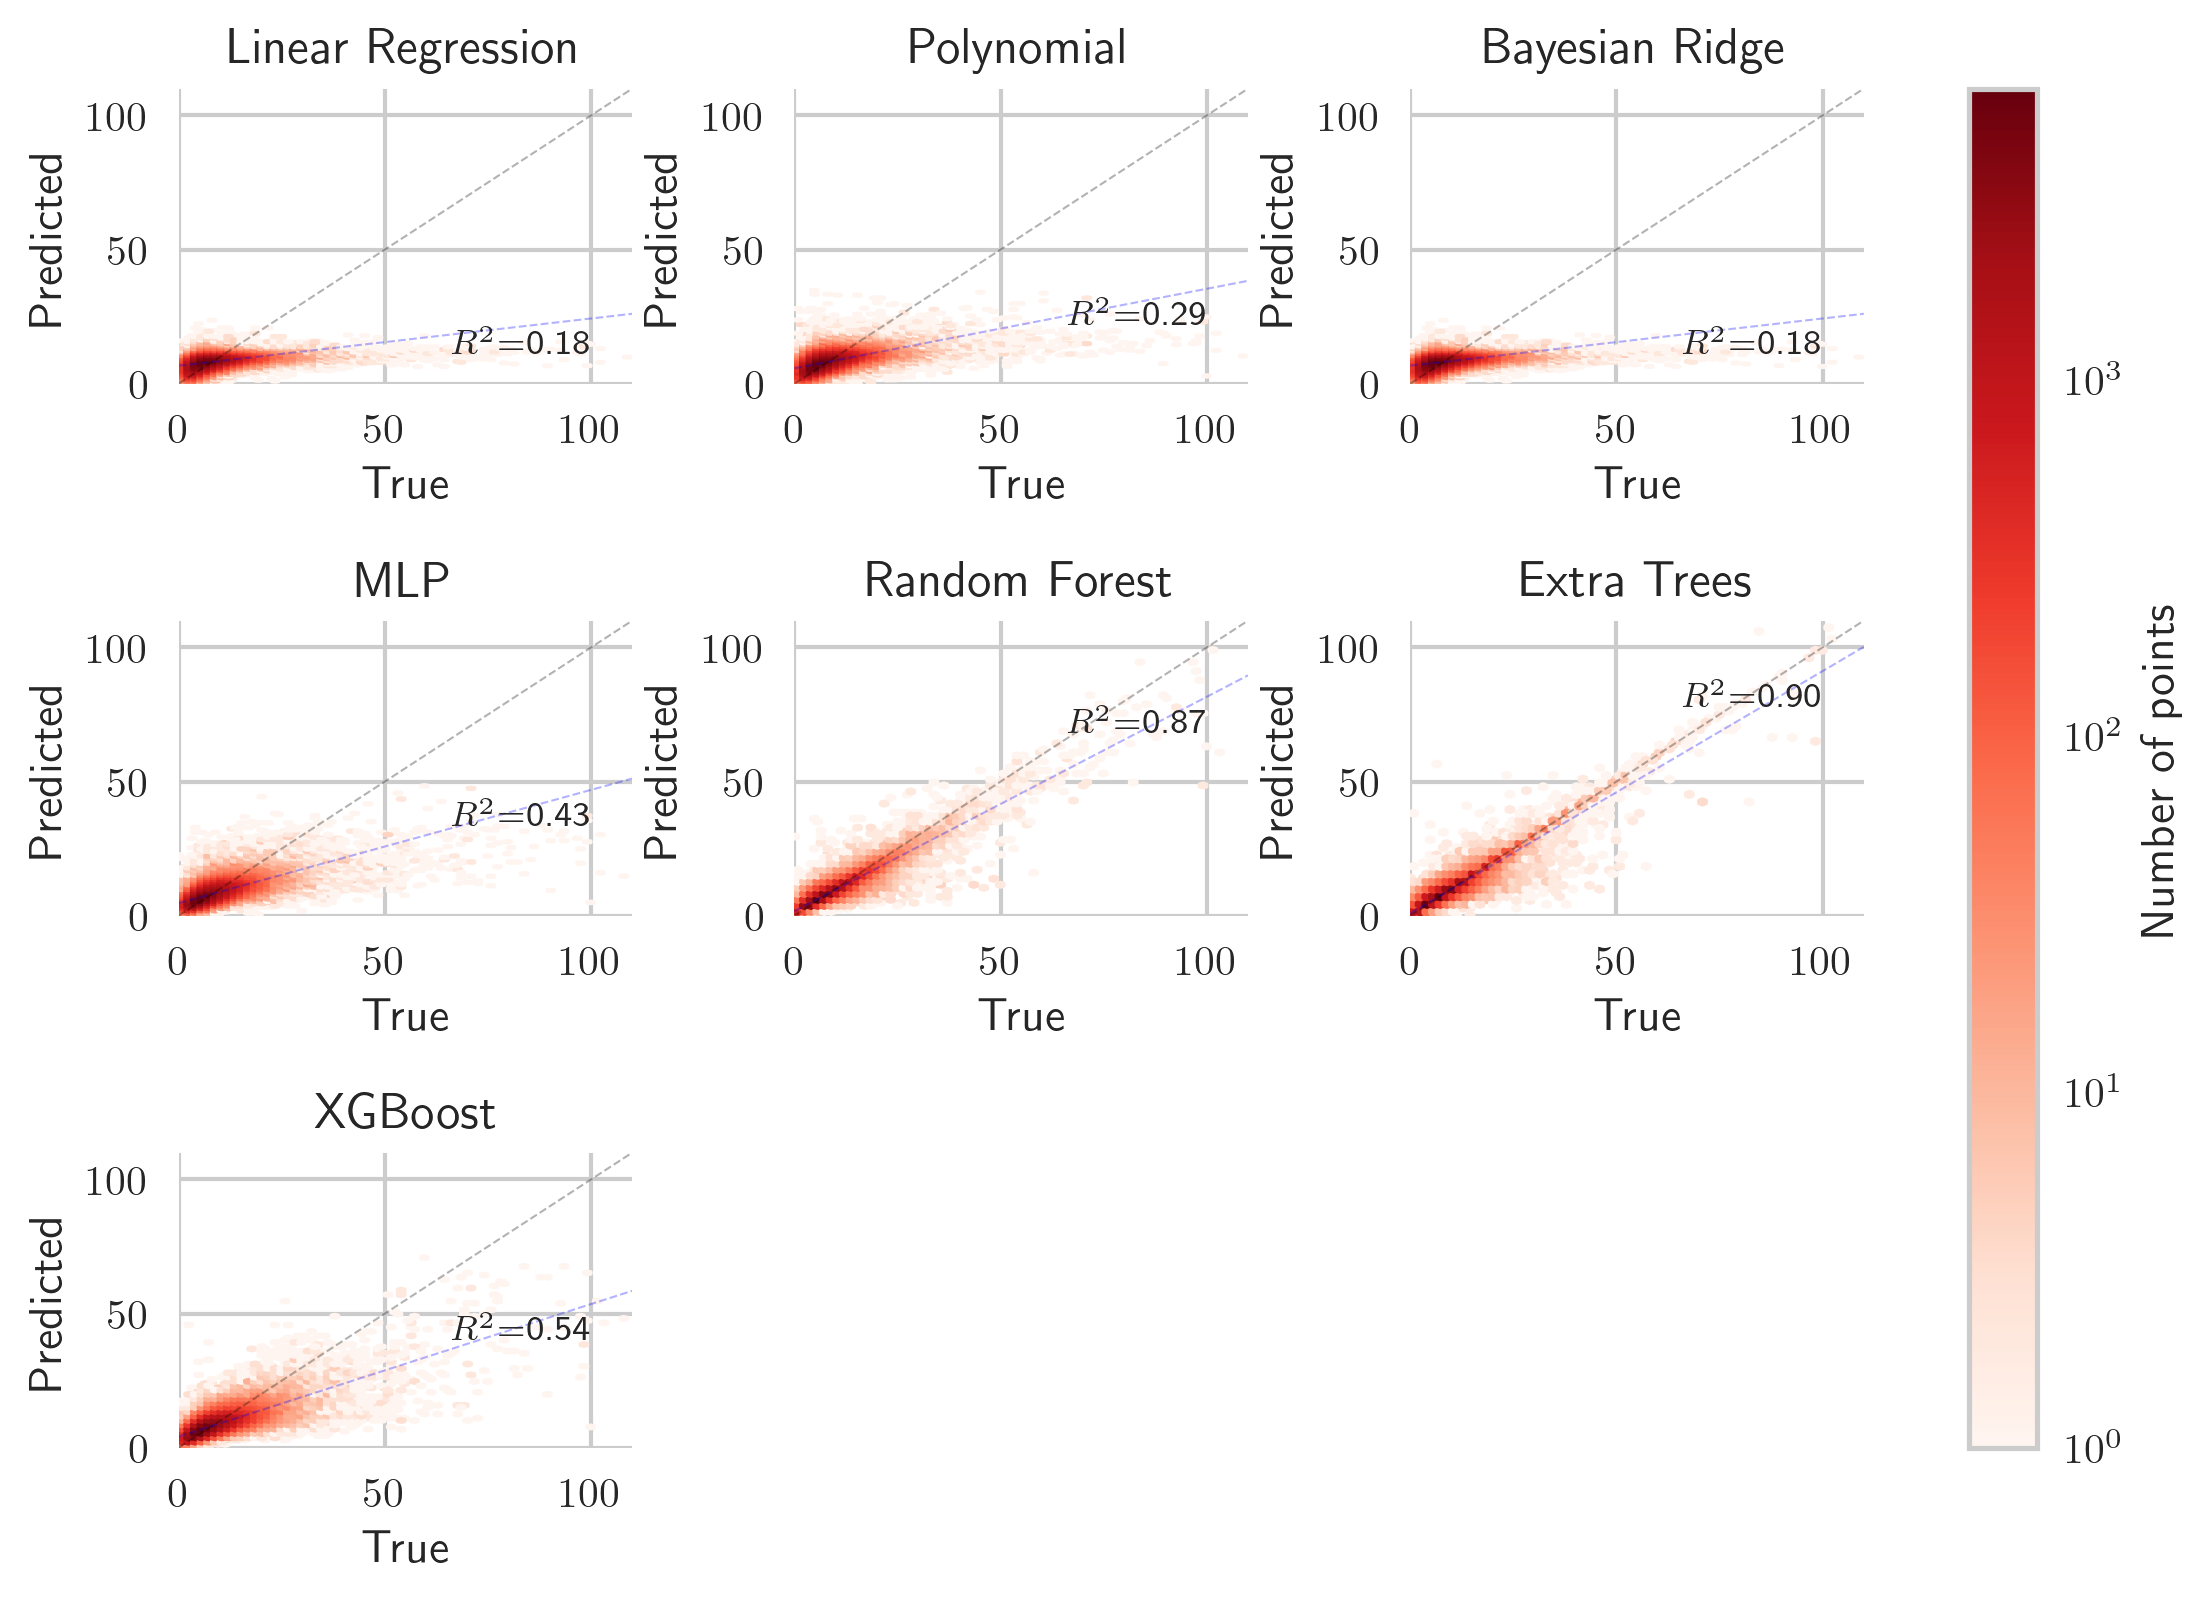

In [39]:
from sklearn.linear_model import LinearRegression

fig, axes = plt.subplots(3, 3, dpi=300)

axs = iter(axes.ravel())

for c in predictions.columns:
    if c == 'True':
        continue
    
    ax = next(axs)

    mappable = ax.hexbin(predictions['True'], predictions[c], bins='log', cmap='Reds')

    ax.set_title(c)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    
    x = predictions['True'].values.reshape(-1, 1)
    y = predictions[c]

    lin = LinearRegression().fit(x, y)
    
    ax.axline(xy1=(0, 0), slope=1, 
              linestyle="--", 
              lw=0.5,
              color="black", 
              alpha=0.3)
    
    ax.axline(xy1=(0, lin.intercept_), slope=lin.coef_.item(), 
              linestyle="--", 
              lw=0.5,
              color="blue", 
              alpha=0.3)
    
    score = lin.score(x, y)
    ax.text(100, lin.predict([[100]]).item() - 4, 
            f'$R^2$={score:.2f}', 
            fontsize='x-small', 
            va='top',
            ha='right')

    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

#     ax.set_xlim((0, np.percentile(predictions['True'], 99)))
#     ax.set_ylim((0, np.percentile(predictions[c], 99)))
    ax.set_xlim((0, 110))
    ax.set_ylim((0, 110))

fig.tight_layout()
cbar = fig.colorbar(mappable, ax=axes.ravel().tolist())
cbar.set_label('Number of points')

for ax in axs:
    ax.set_visible(False)

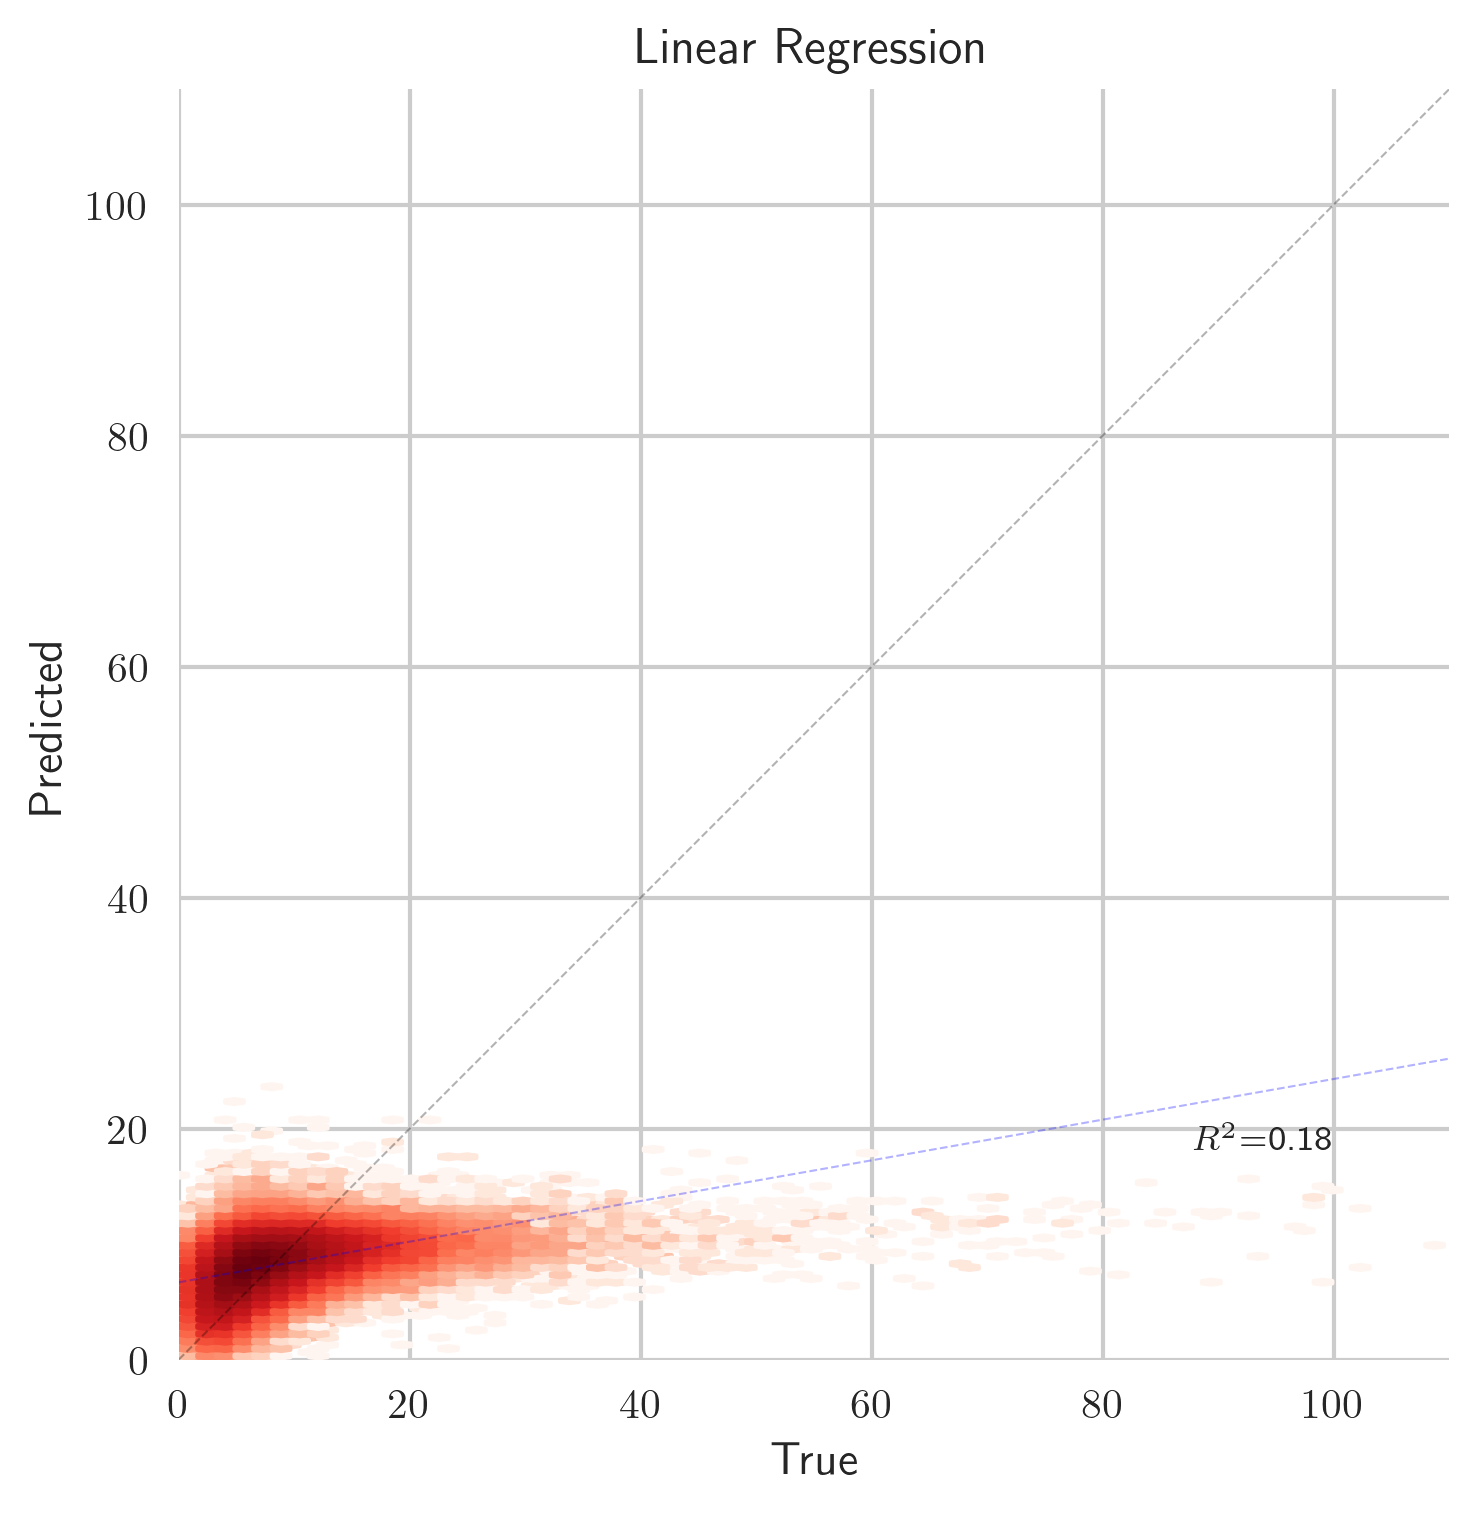

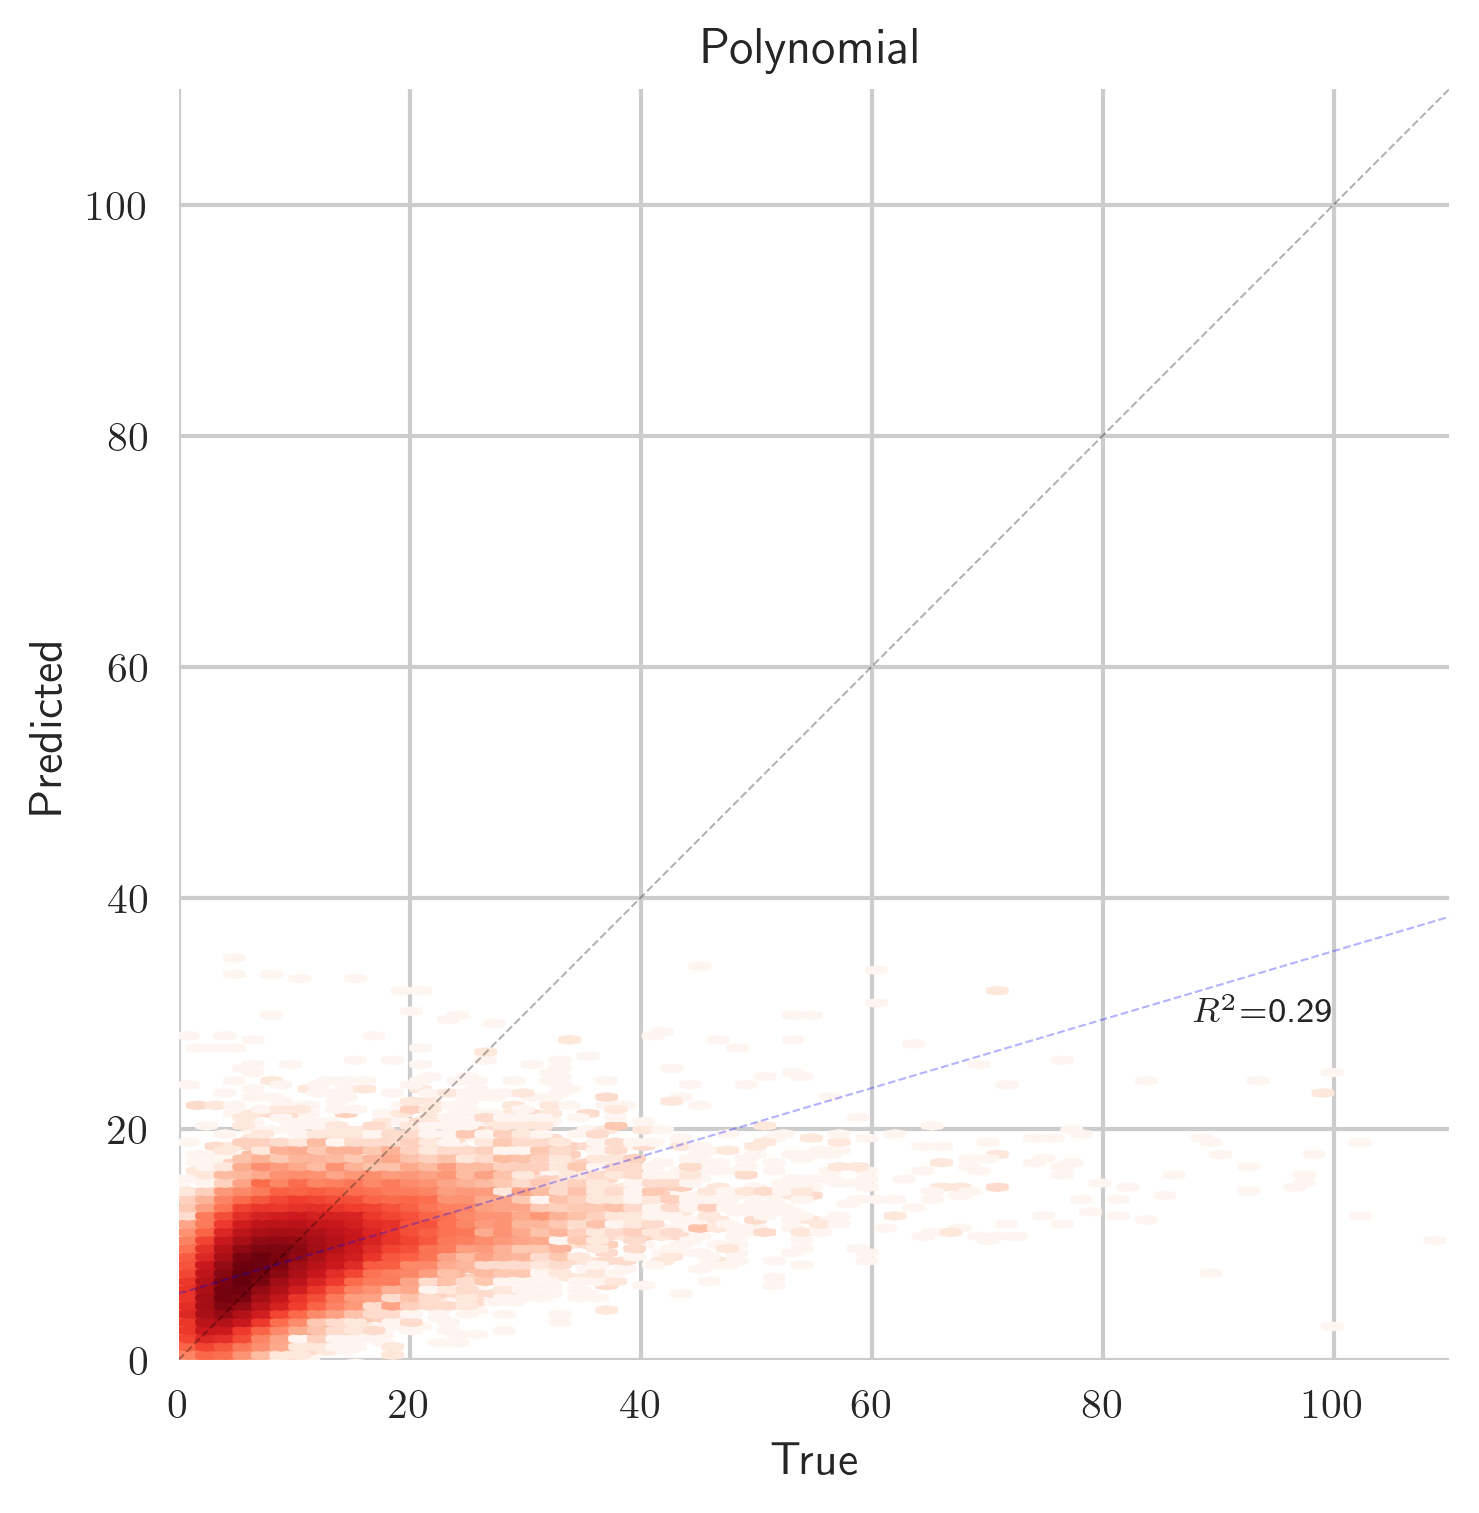

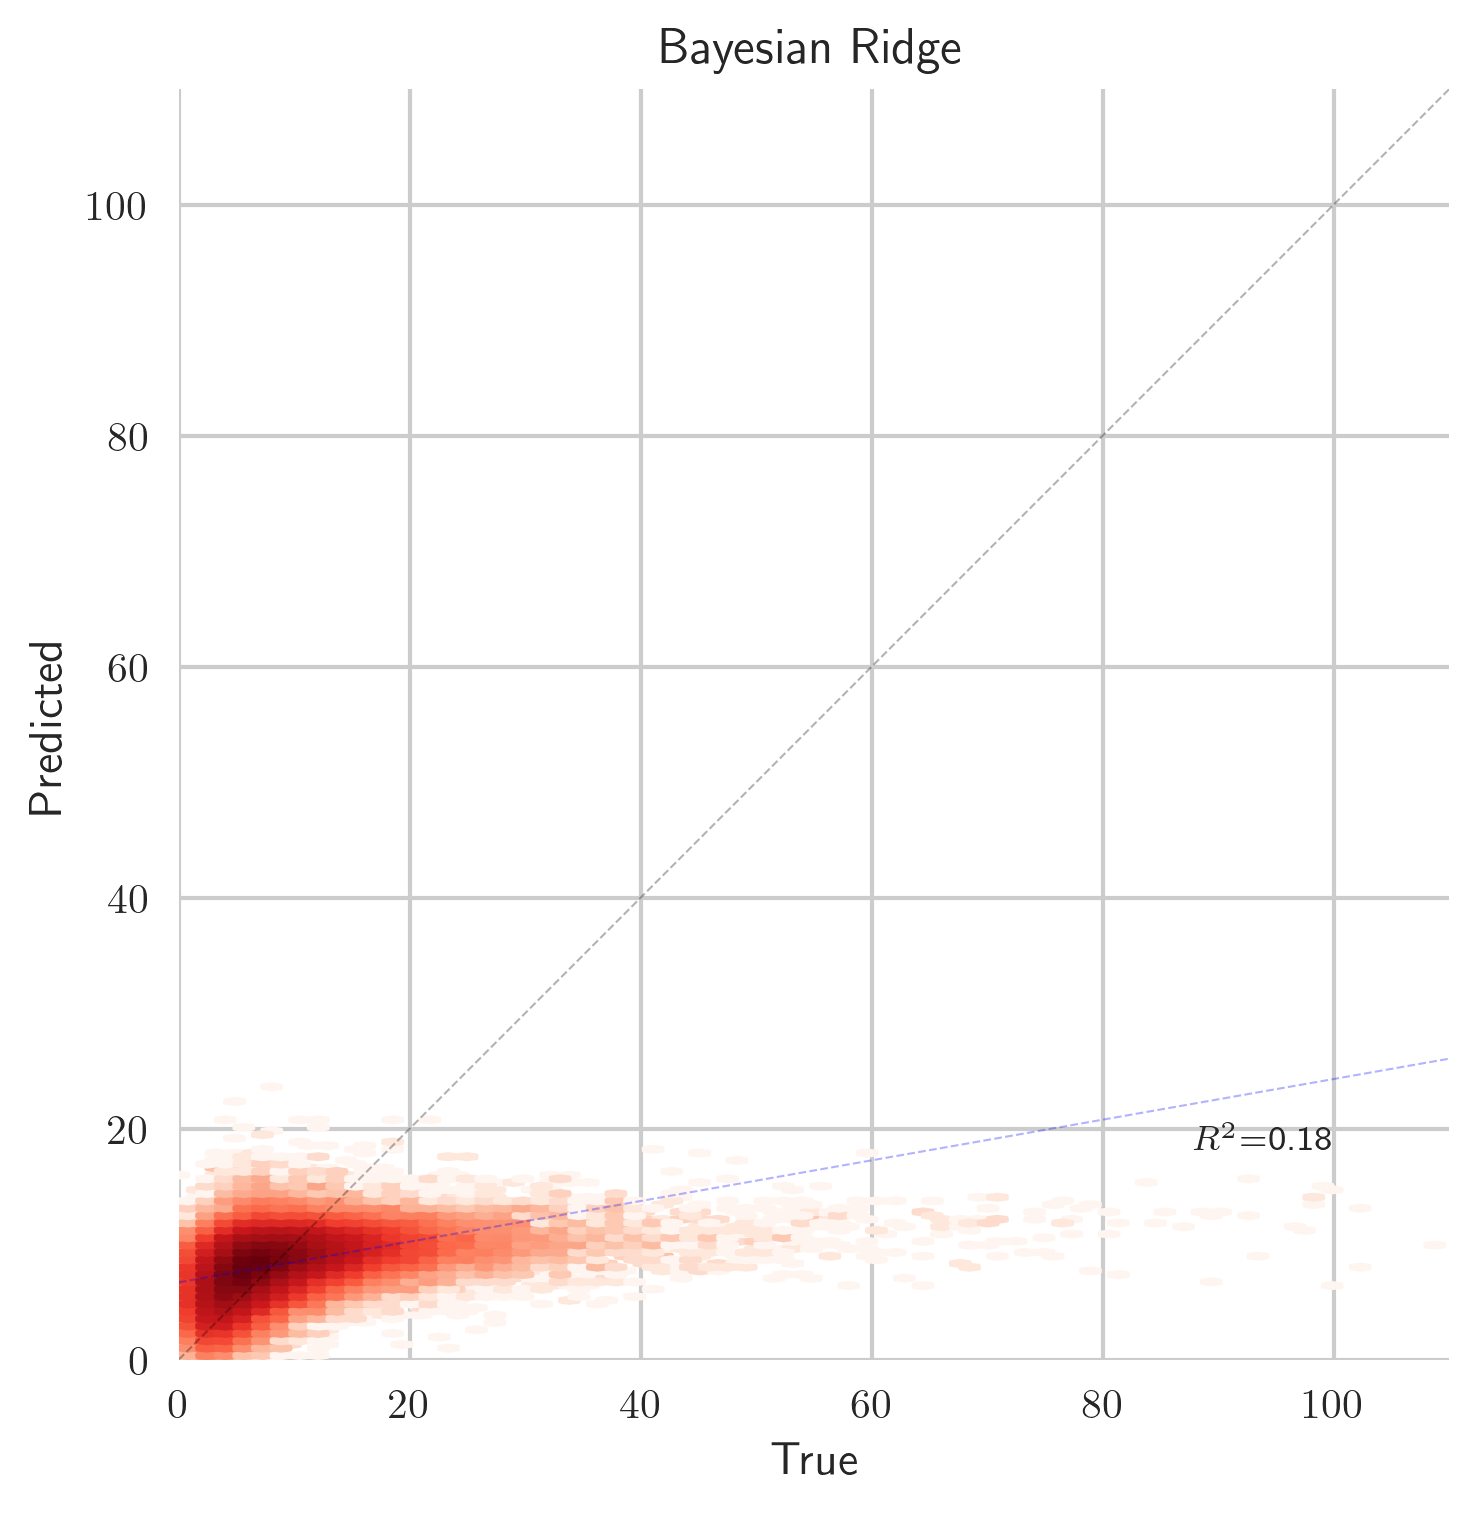

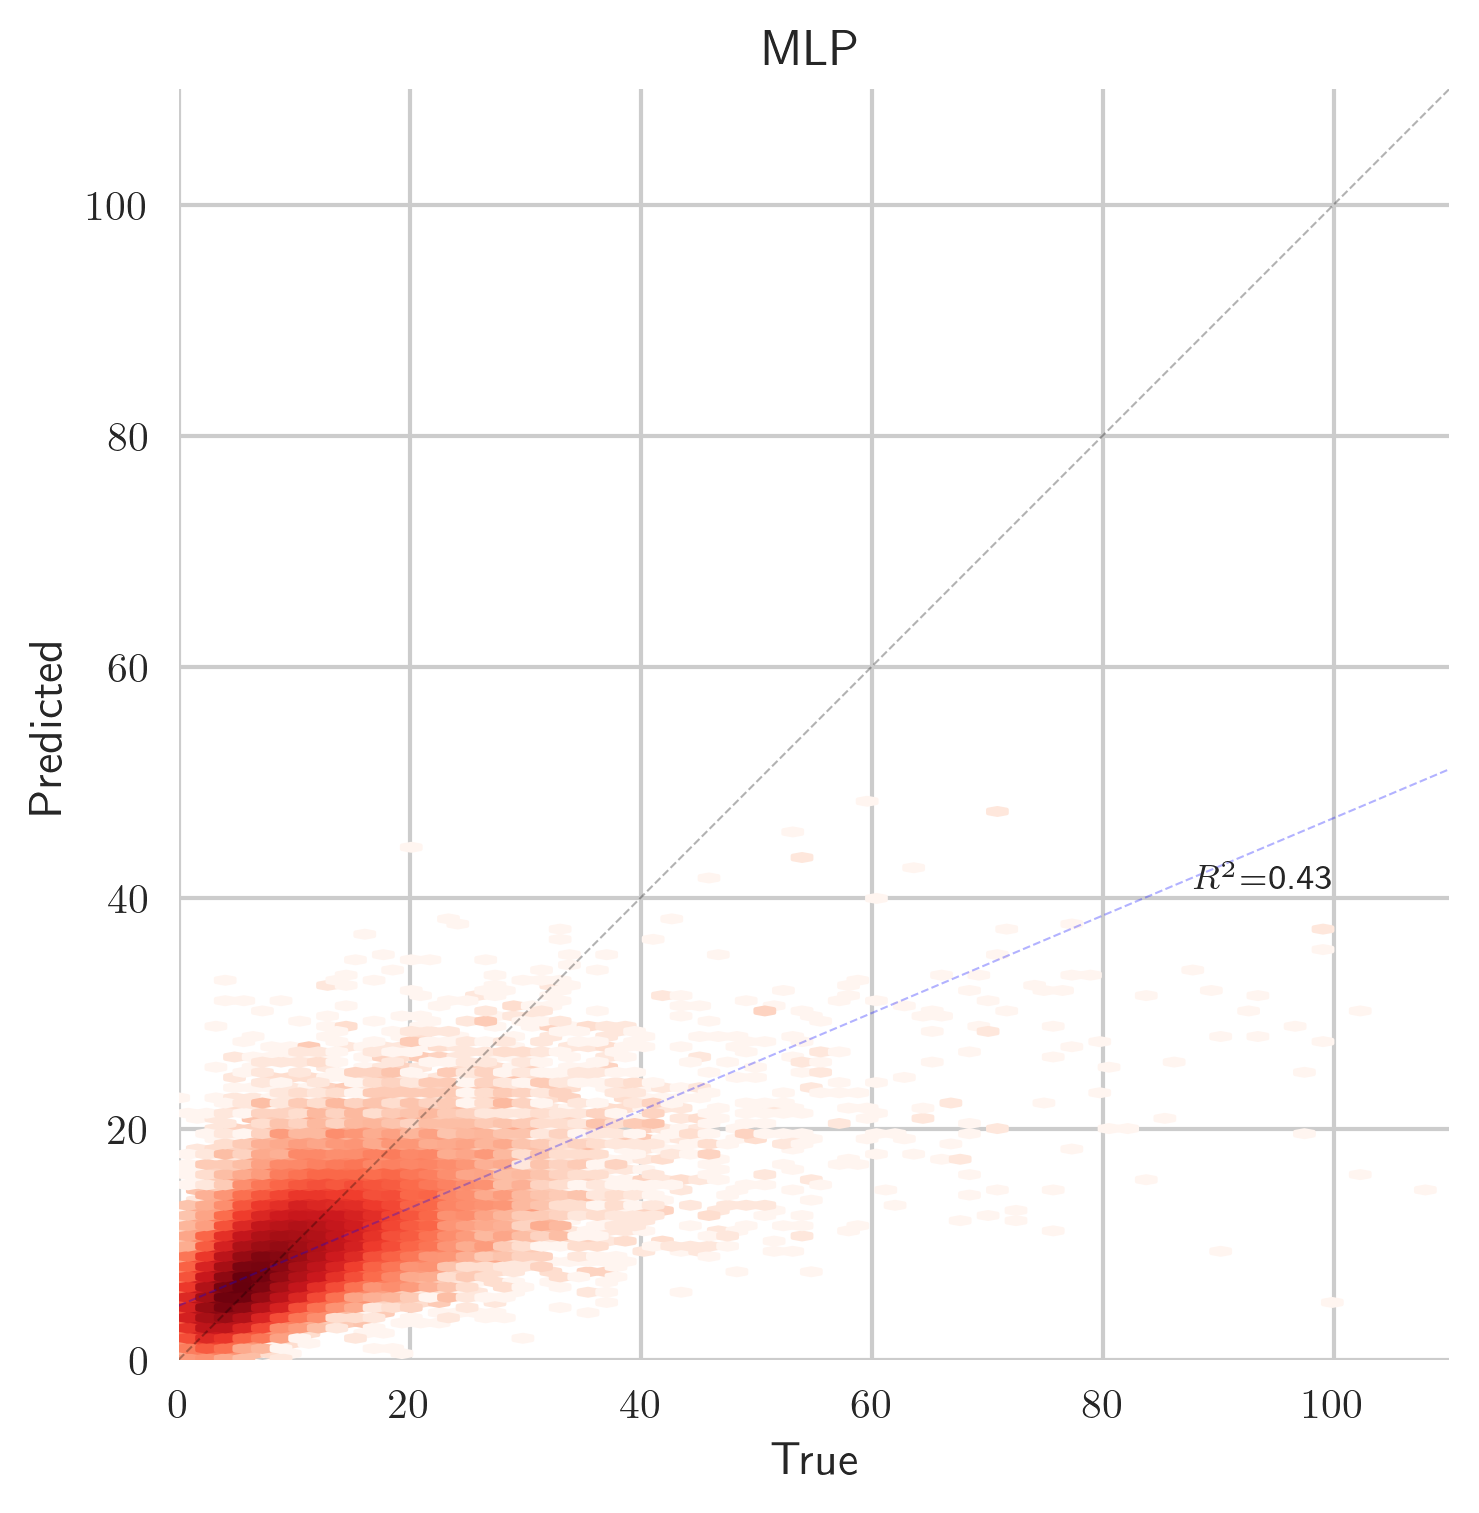

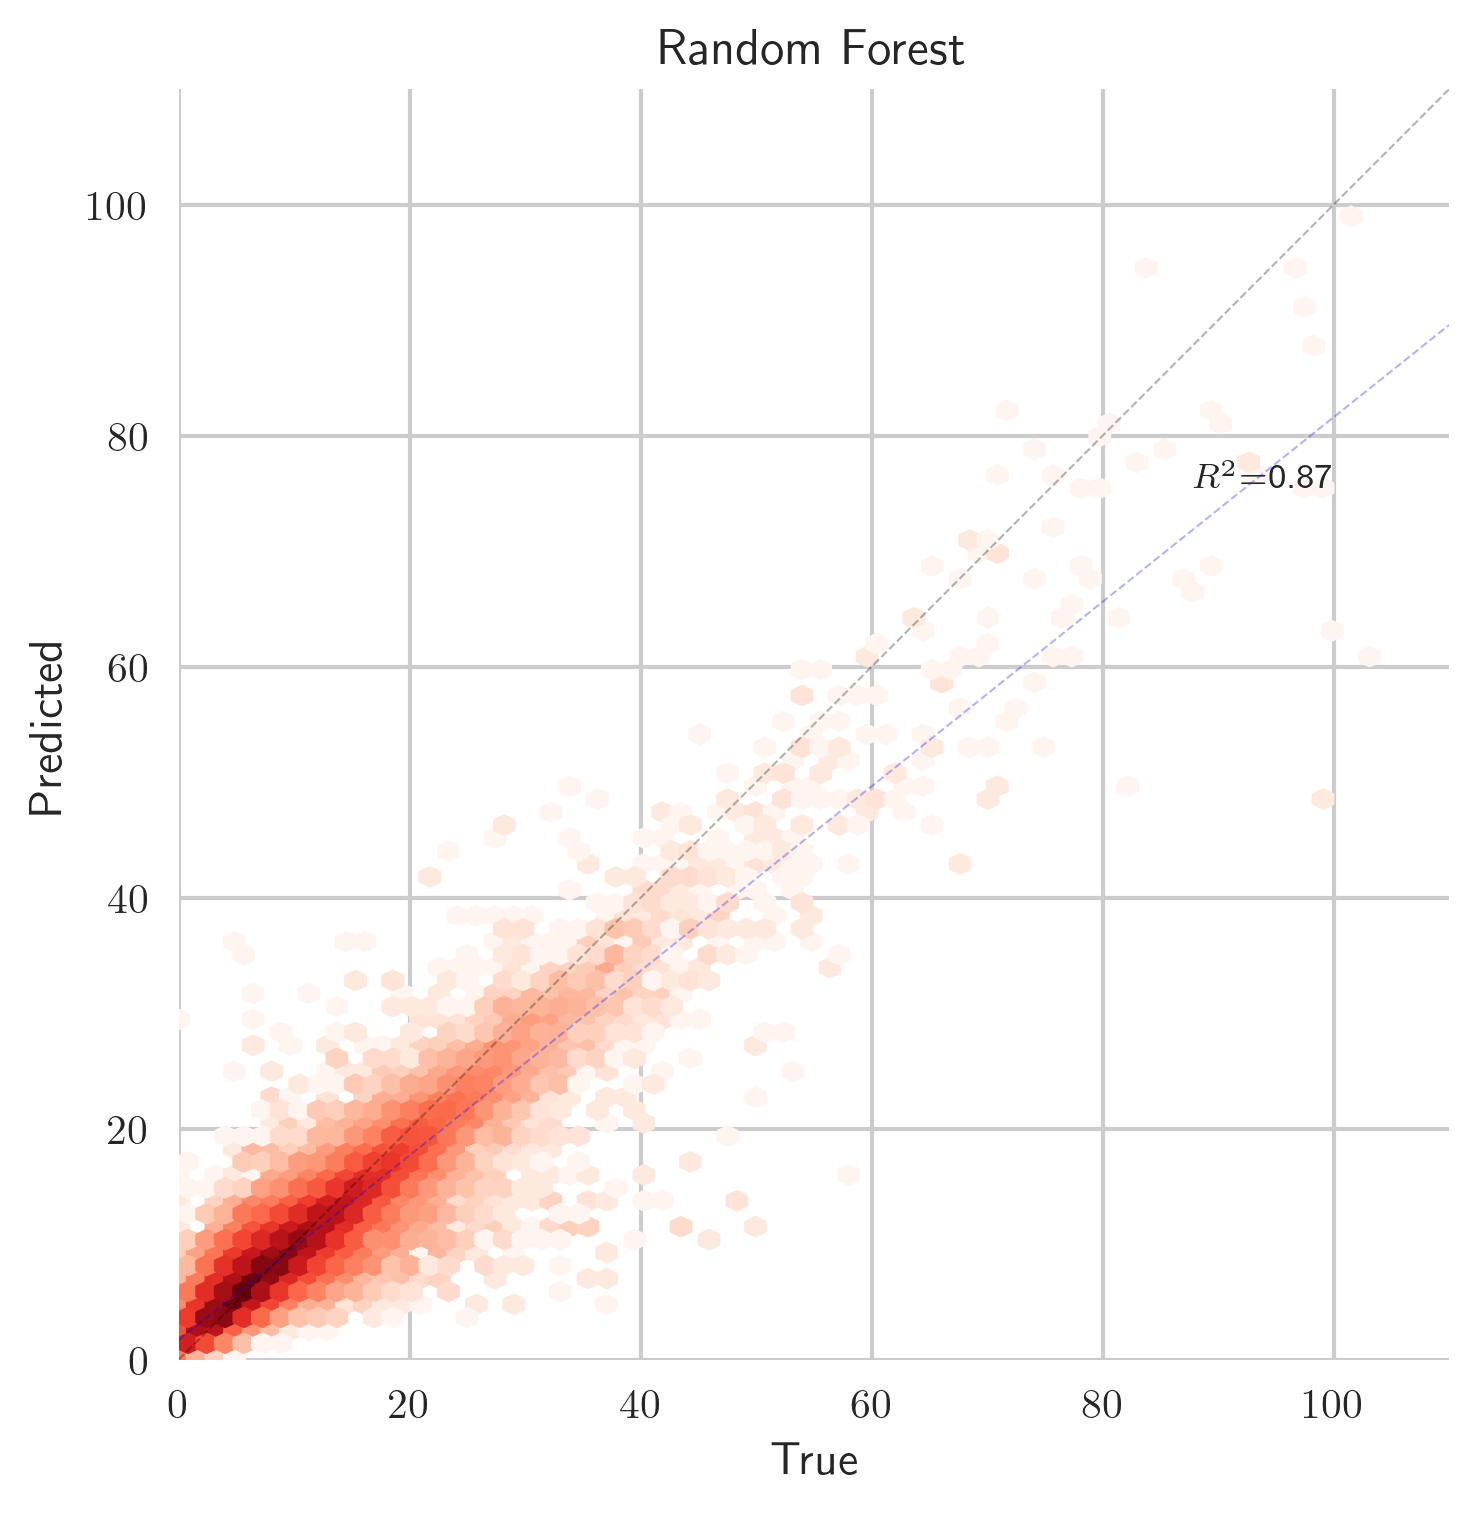

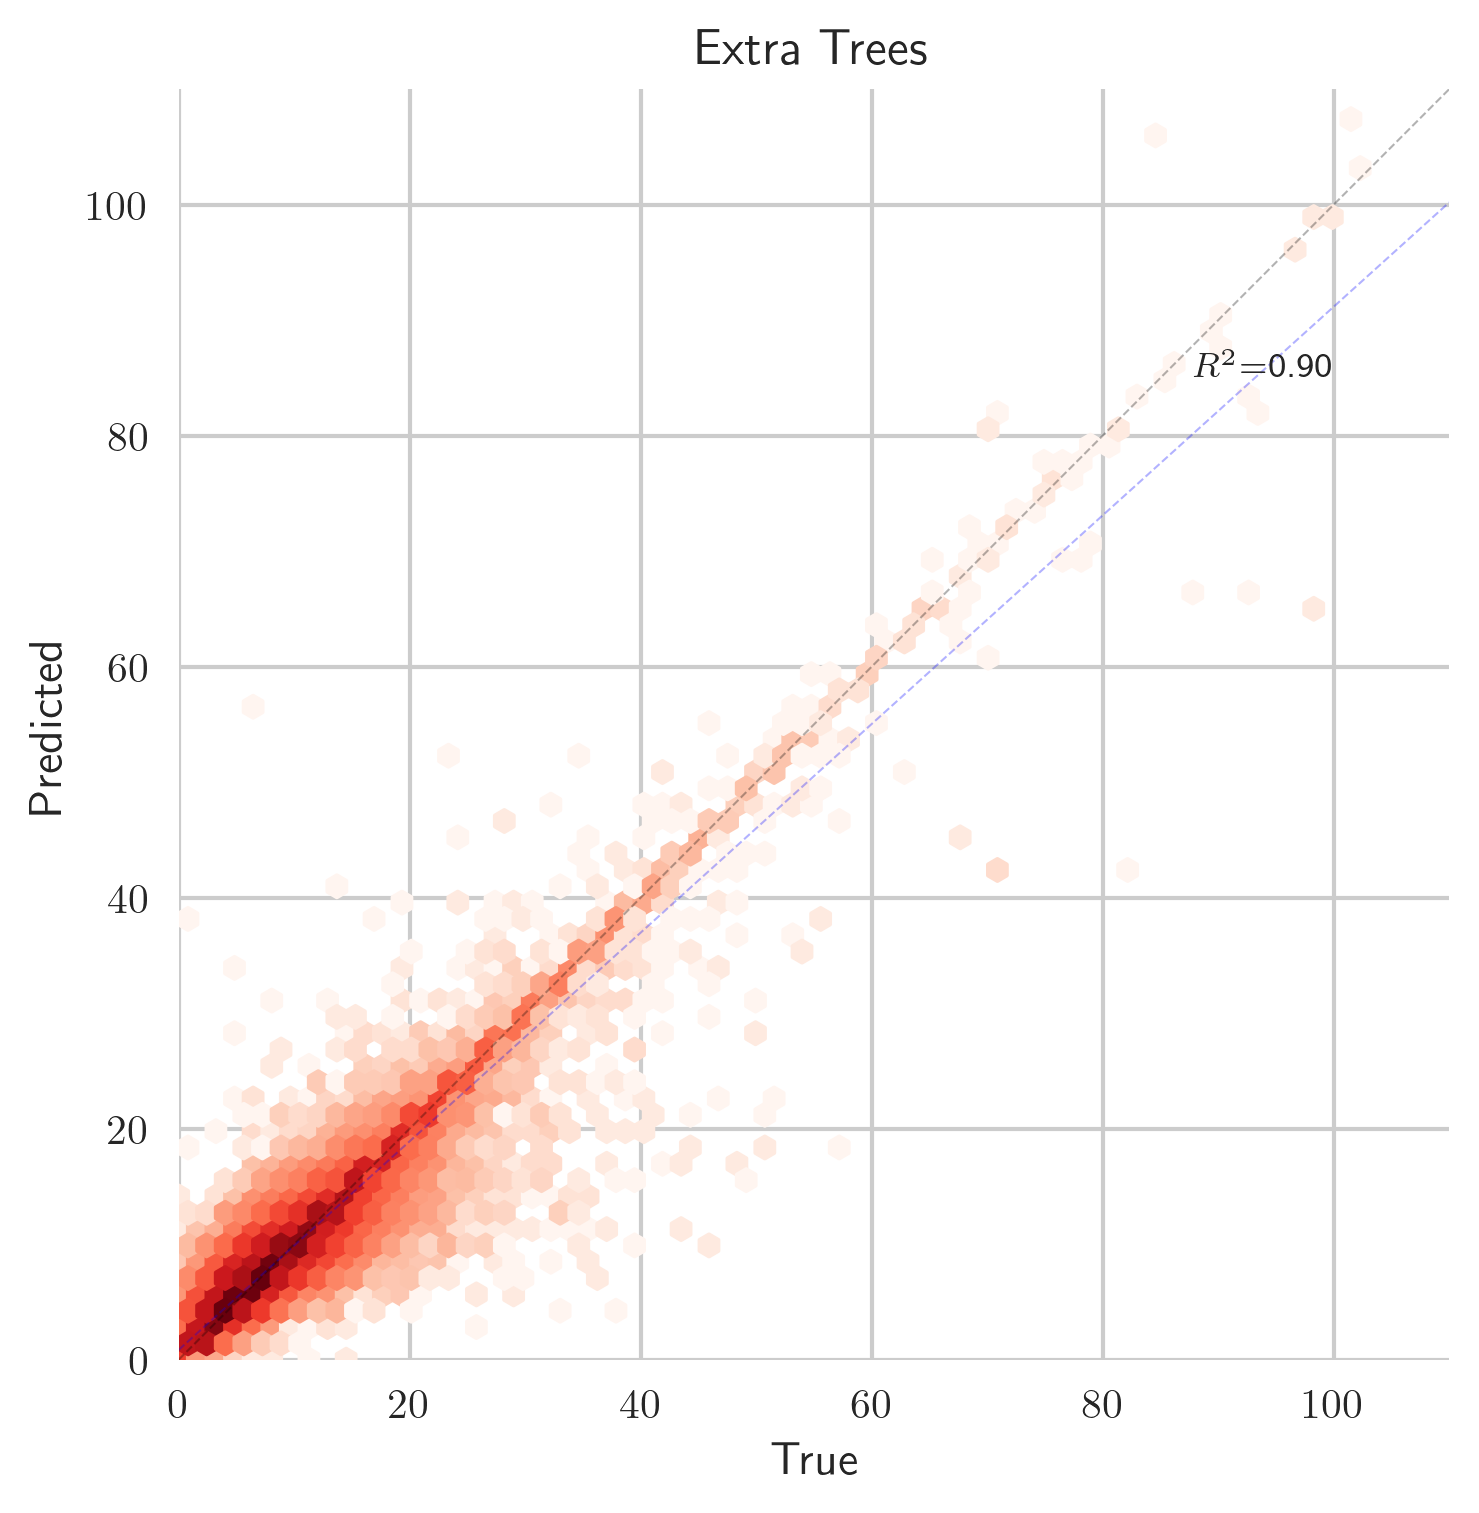

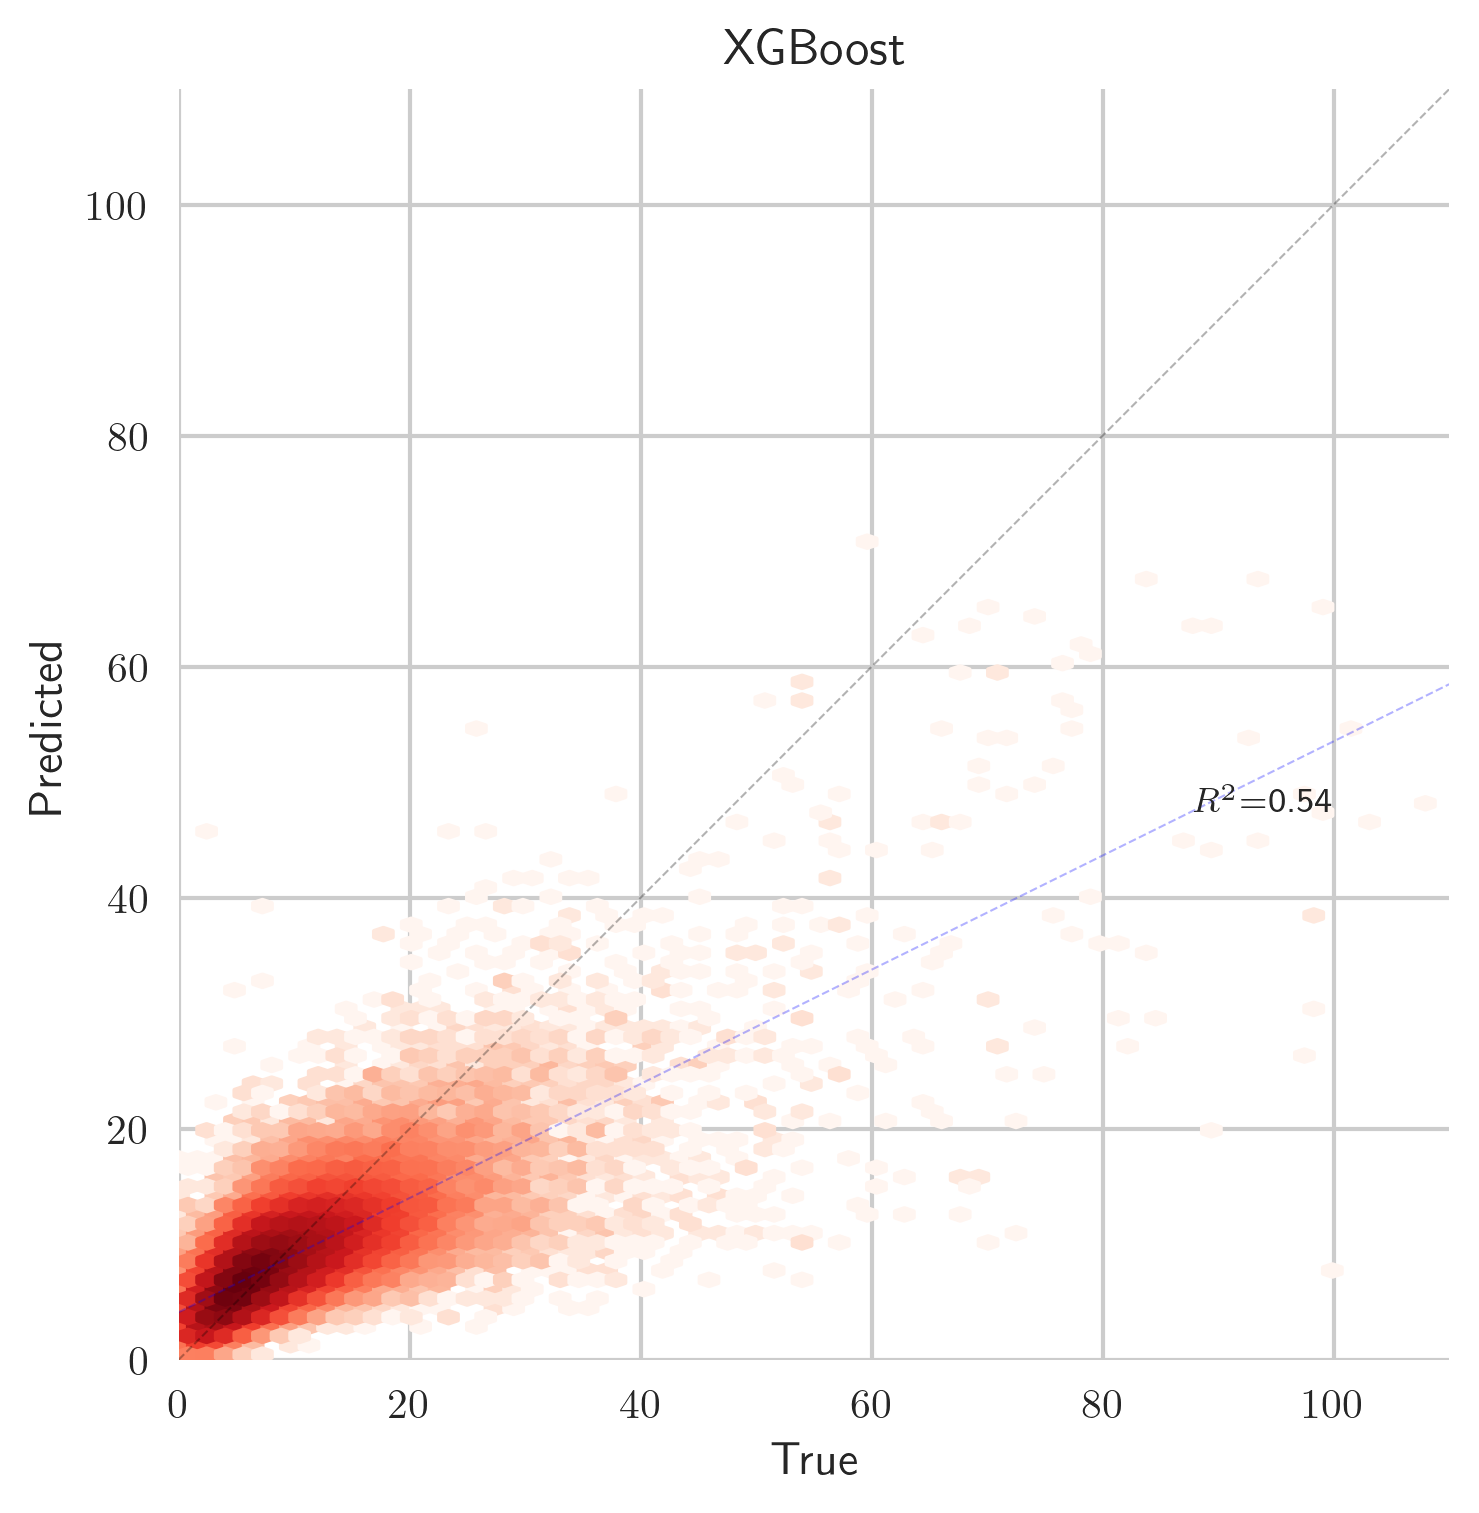

In [40]:
from sklearn.linear_model import LinearRegression


for c in predictions.columns:
    if c == 'True':
        continue
        
    fig, ax = plt.subplots(dpi=300)

    mappable = ax.hexbin(predictions['True'], predictions[c], bins='log', cmap='Reds')

    ax.set_title(c)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    
    x = predictions['True'].values.reshape(-1, 1)
    y = predictions[c]

    lin = LinearRegression().fit(x, y)
    
    ax.axline(xy1=(0, 0), slope=1, 
              linestyle="--", 
              lw=0.5,
              color="black", 
              alpha=0.3)
    
    ax.axline(xy1=(0, lin.intercept_), slope=lin.coef_.item(), 
              linestyle="--", 
              lw=0.5,
              color="blue", 
              alpha=0.3)
    
    score = lin.score(x, y)
    ax.text(100, lin.predict([[100]]).item() - 4, 
            f'$R^2$={score:.2f}', 
            fontsize='x-small', 
            va='top',
            ha='right')
    
    ax.set_aspect('equal')

    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

#     ax.set_xlim((0, np.percentile(predictions['True'], 99)))
#     ax.set_ylim((0, np.percentile(predictions[c], 99)))
    ax.set_xlim((0, 110))
    ax.set_ylim((0, 110))

# fig.tight_layout()
# cbar = fig.colorbar(mappable, ax=axes.ravel().tolist())
# cbar.set_label('Number of points')

# for ax in axs:
#     ax.set_visible(False)

In [41]:
models = list(mc.cross_val_scores_.keys())
fits, error = [], []
for model in models:
    res = mc.cross_val_scores_[model]
    fits.append(res['fit_time'].mean())
    error.append(np.std(res['fit_time'], ddof=1) / np.sqrt(np.size(res['fit_time'])))
    
fit_df = pd.DataFrame({'Fit Time': fits, 'Error': error}, index=models)#.reindex(order)
fit_df

Fit Time      Error
Linear Regression     4.154998   0.494004
Polynomial          161.466741  19.306141
Bayesian Ridge        6.192263   0.713857
MLP                 445.411470  25.681297
Random Forest      1400.377442  44.591521
Extra Trees         651.528020  30.500401
XGBoost             133.364391  12.374384

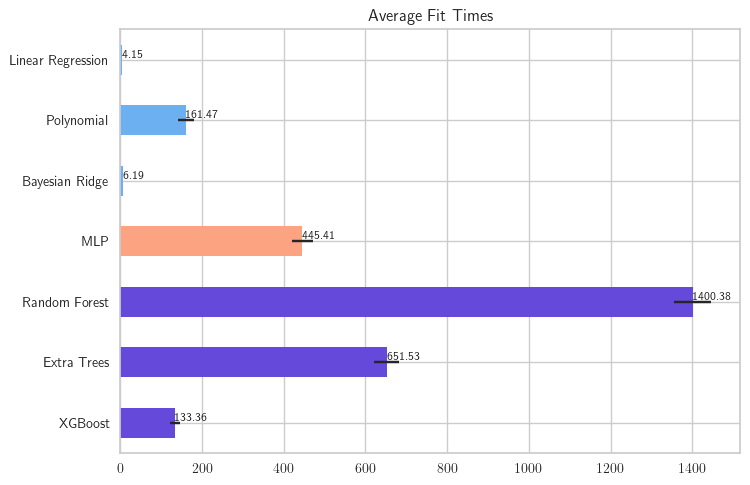

In [42]:
fig, ax = plt.subplots()

fit_df.plot(kind = "barh", y = "Fit Time", 
            legend = False, 
            title = "Average Fit Times", 
            xerr = "Error", color=colors,
            ax=ax)


for patch in ax.patches:
    bl = patch.get_xy()
    x = patch.get_width() + bl[0] + .01
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, 
            f'{patch.get_width():0.2f}', 
            fontsize=8, 
            ha='left',
            va='bottom')
    
ax.invert_yaxis()

# fig.savefig(os.path.join(paths.figures, 'fit_times.svg'), format='svg', bbox_inches='tight')

## Feature Importance

In [43]:
rf_imp = np.array(list(zip(mc.models['Random Forest'].named_steps['random_forest'].feature_importances_, X.columns.values)))
et_imp = np.array(list(zip(mc.models['Extra Trees'].named_steps['extra_trees'].feature_importances_, X.columns.values)))
xg_imp = np.array(list(zip(mc.models['XGBoost'].named_steps['xgboost'].feature_importances_, X.columns.values)))

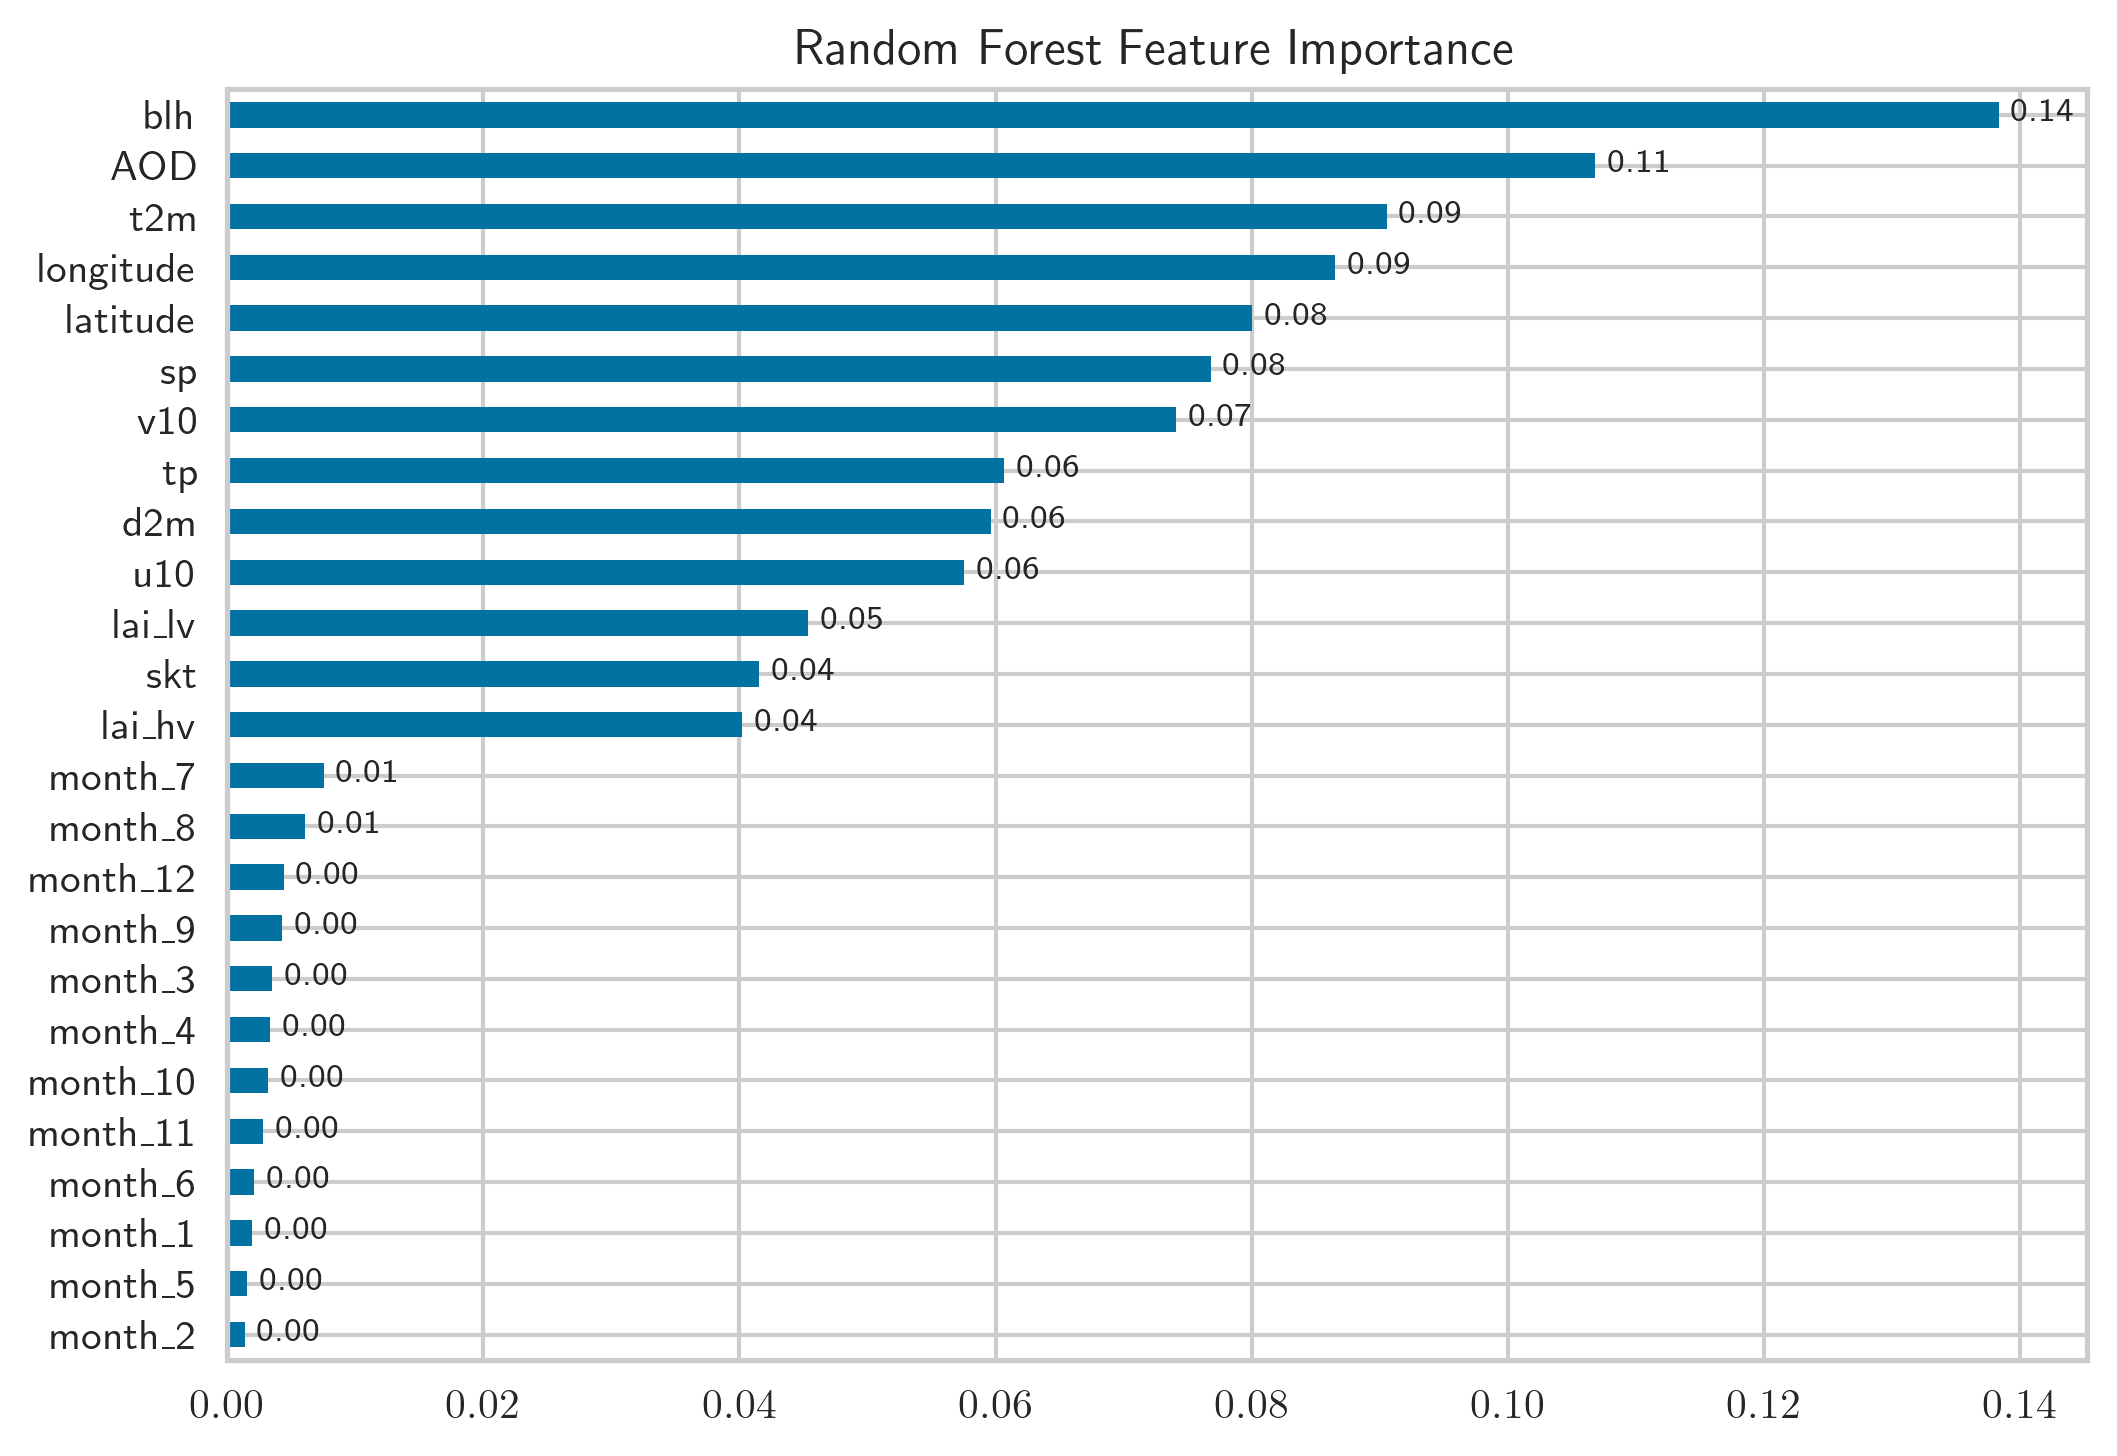

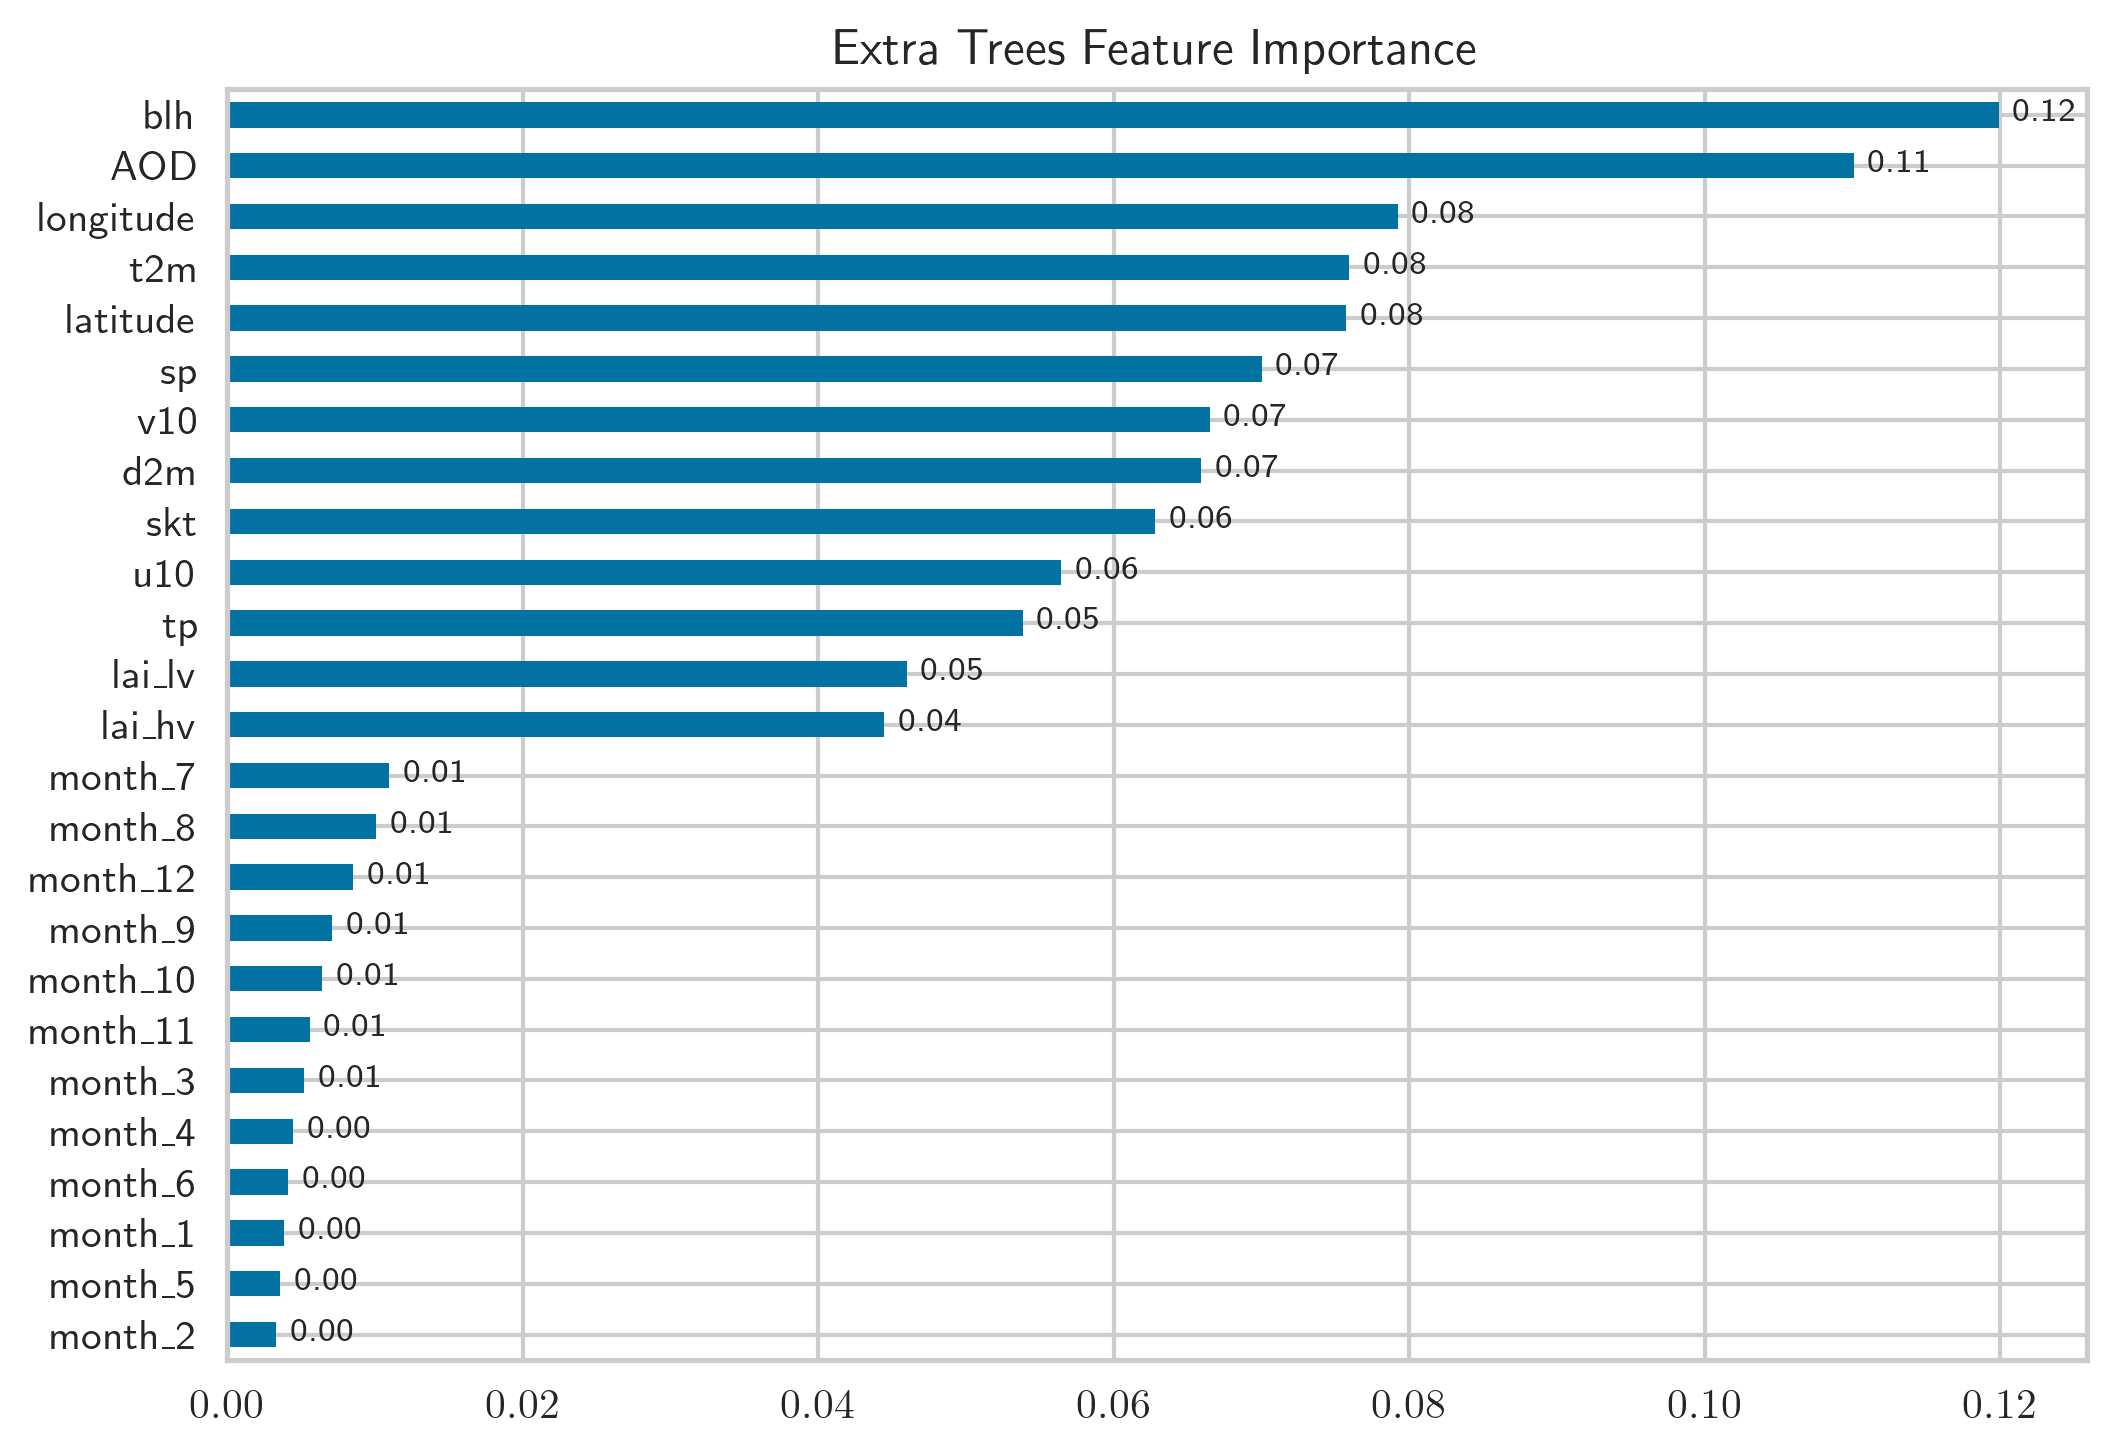

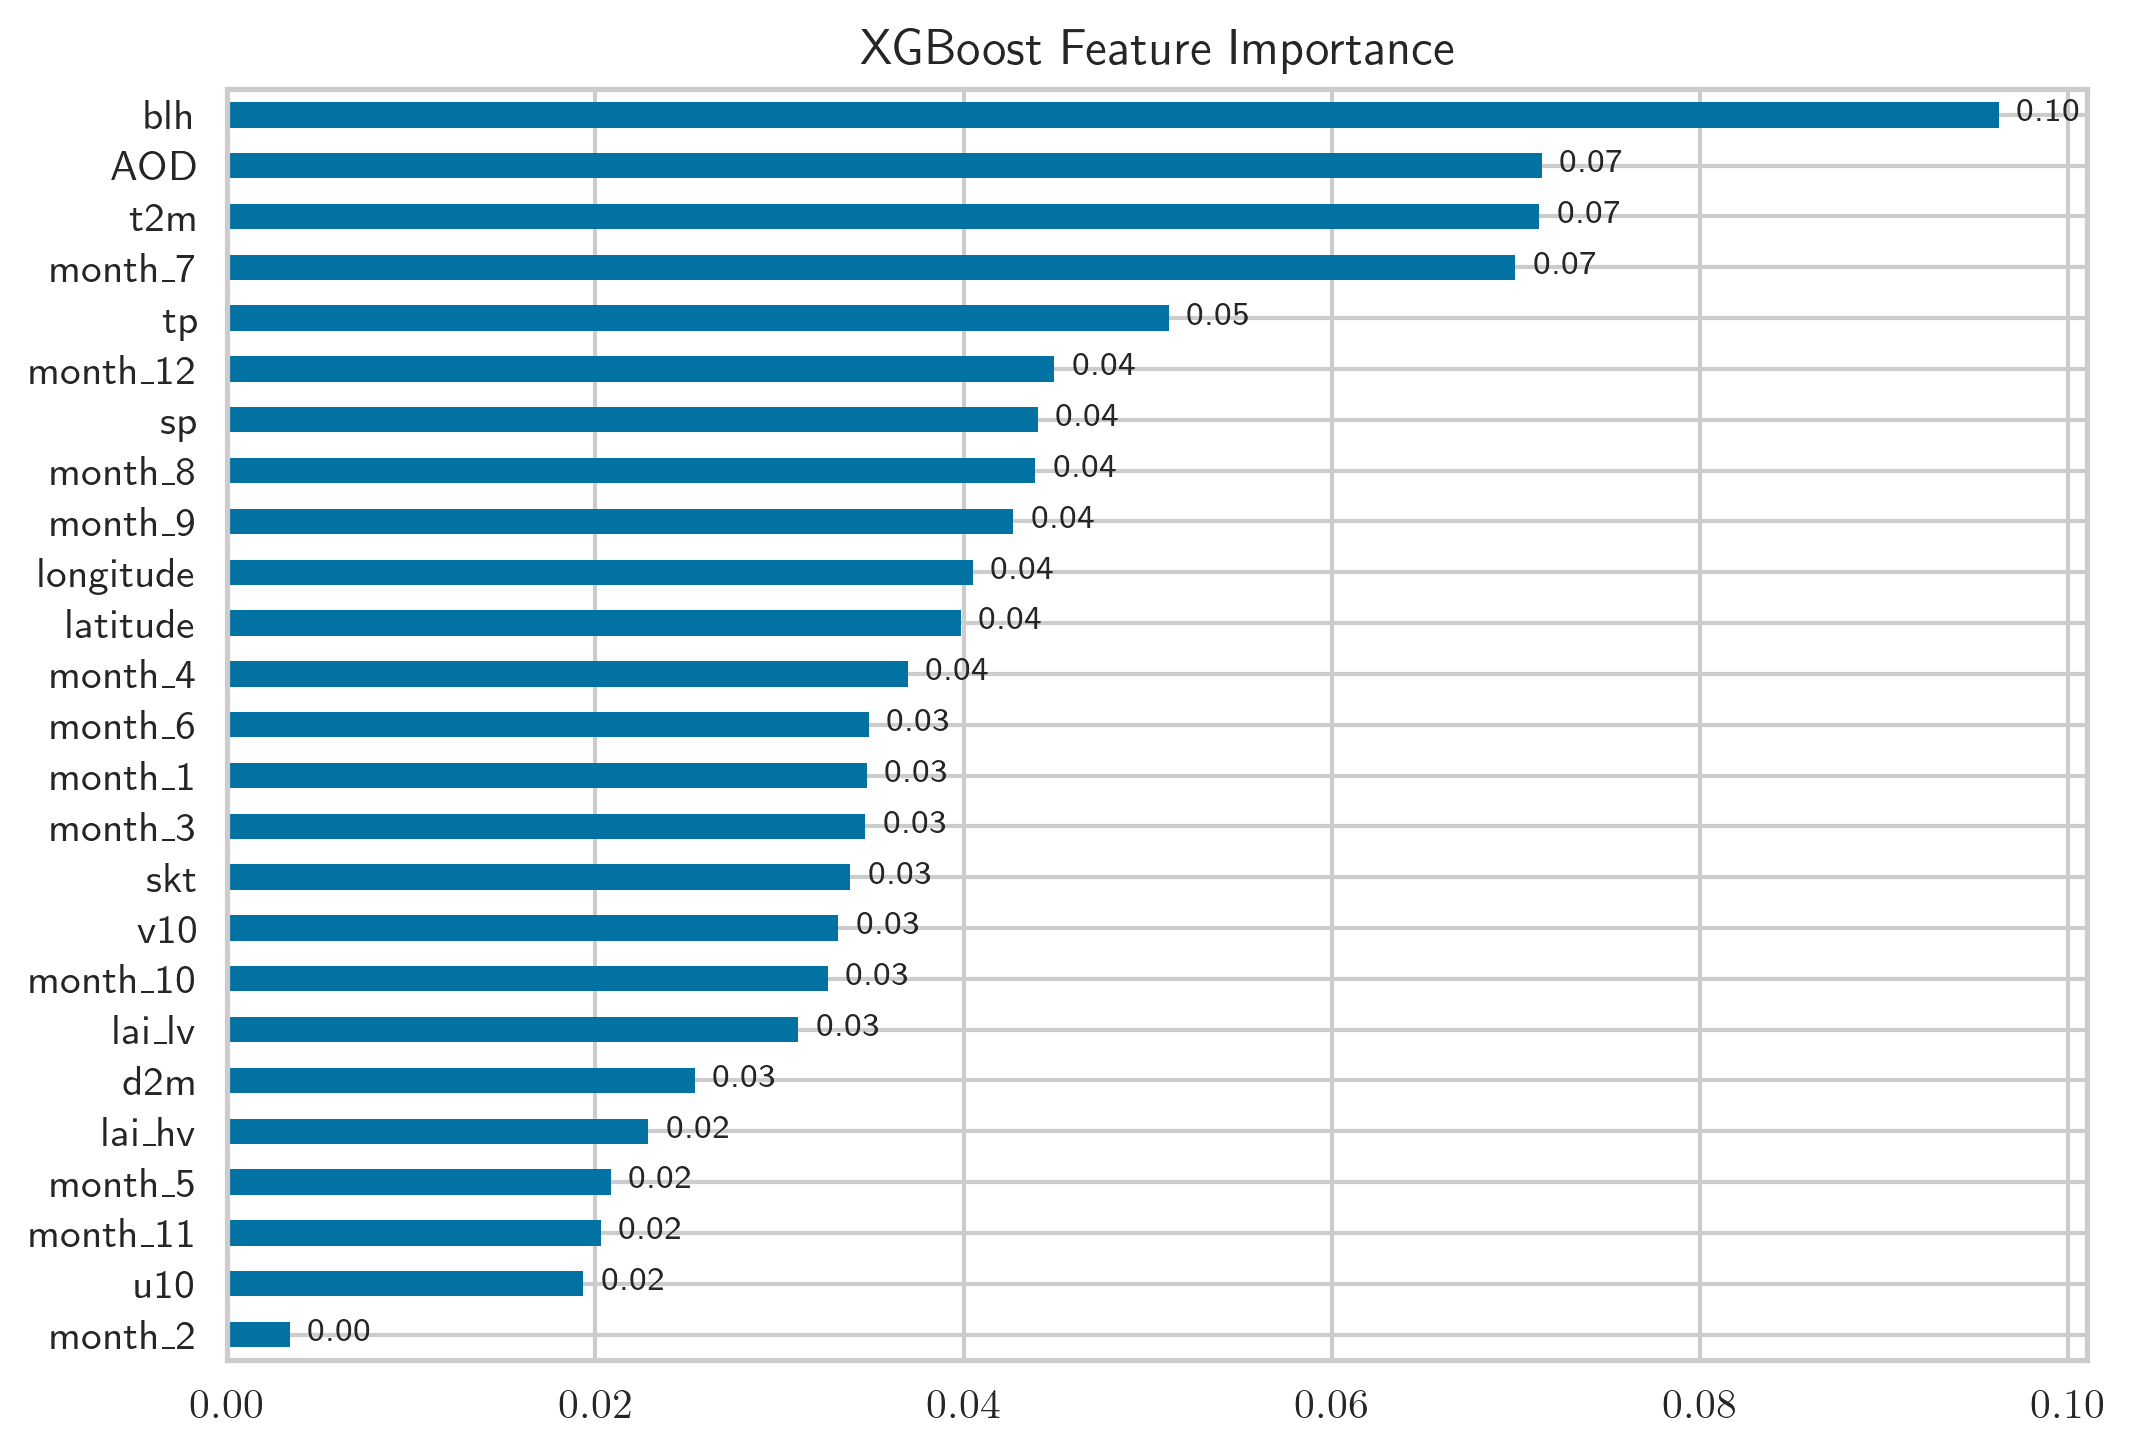

In [44]:
for thing, name in zip([rf_imp, et_imp, xg_imp], ['Random Forest', 'Extra Trees', 'XGBoost']):
    thing = thing[np.argsort(thing, axis=0)[:,0][::-1]]
    thing = pd.DataFrame({name: float(val) for val,name in thing}, index=['Importance']).T
    
    fig, ax = plt.subplots(dpi=300)
    ax.set_title(f'{name} Feature Importance')
    thing.plot(kind = "barh", legend = False, ax=ax)

    for patch in ax.patches:
        bl = patch.get_xy()
        x = patch.get_width() + bl[0] + .001
        y = 1*patch.get_height() + bl[1]
        ax.text(x, y, 
                f'{patch.get_width():0.2f}', 
                fontsize=8, 
                ha='left',
                va='bottom')

    ax.invert_yaxis()

## Learning Curves

In [34]:
def learning_curve_graph(train_sizes, train_scores, test_scores):    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig, ax = plt.subplots(dpi=300)

    ax.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='Training $R^2$')

    ax.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    ax.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='Validation $R^2$')

    ax.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    ax.grid(True)
    ax.set_xlabel('Number of training examples')
    ax.set_ylabel('$R^2$')
    ax.legend(loc='lower right')
    ax.set_ylim([0.0, 1.03])
    fig.tight_layout()

/usr/local/Caskroom/miniconda/base/envs/geospatial/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


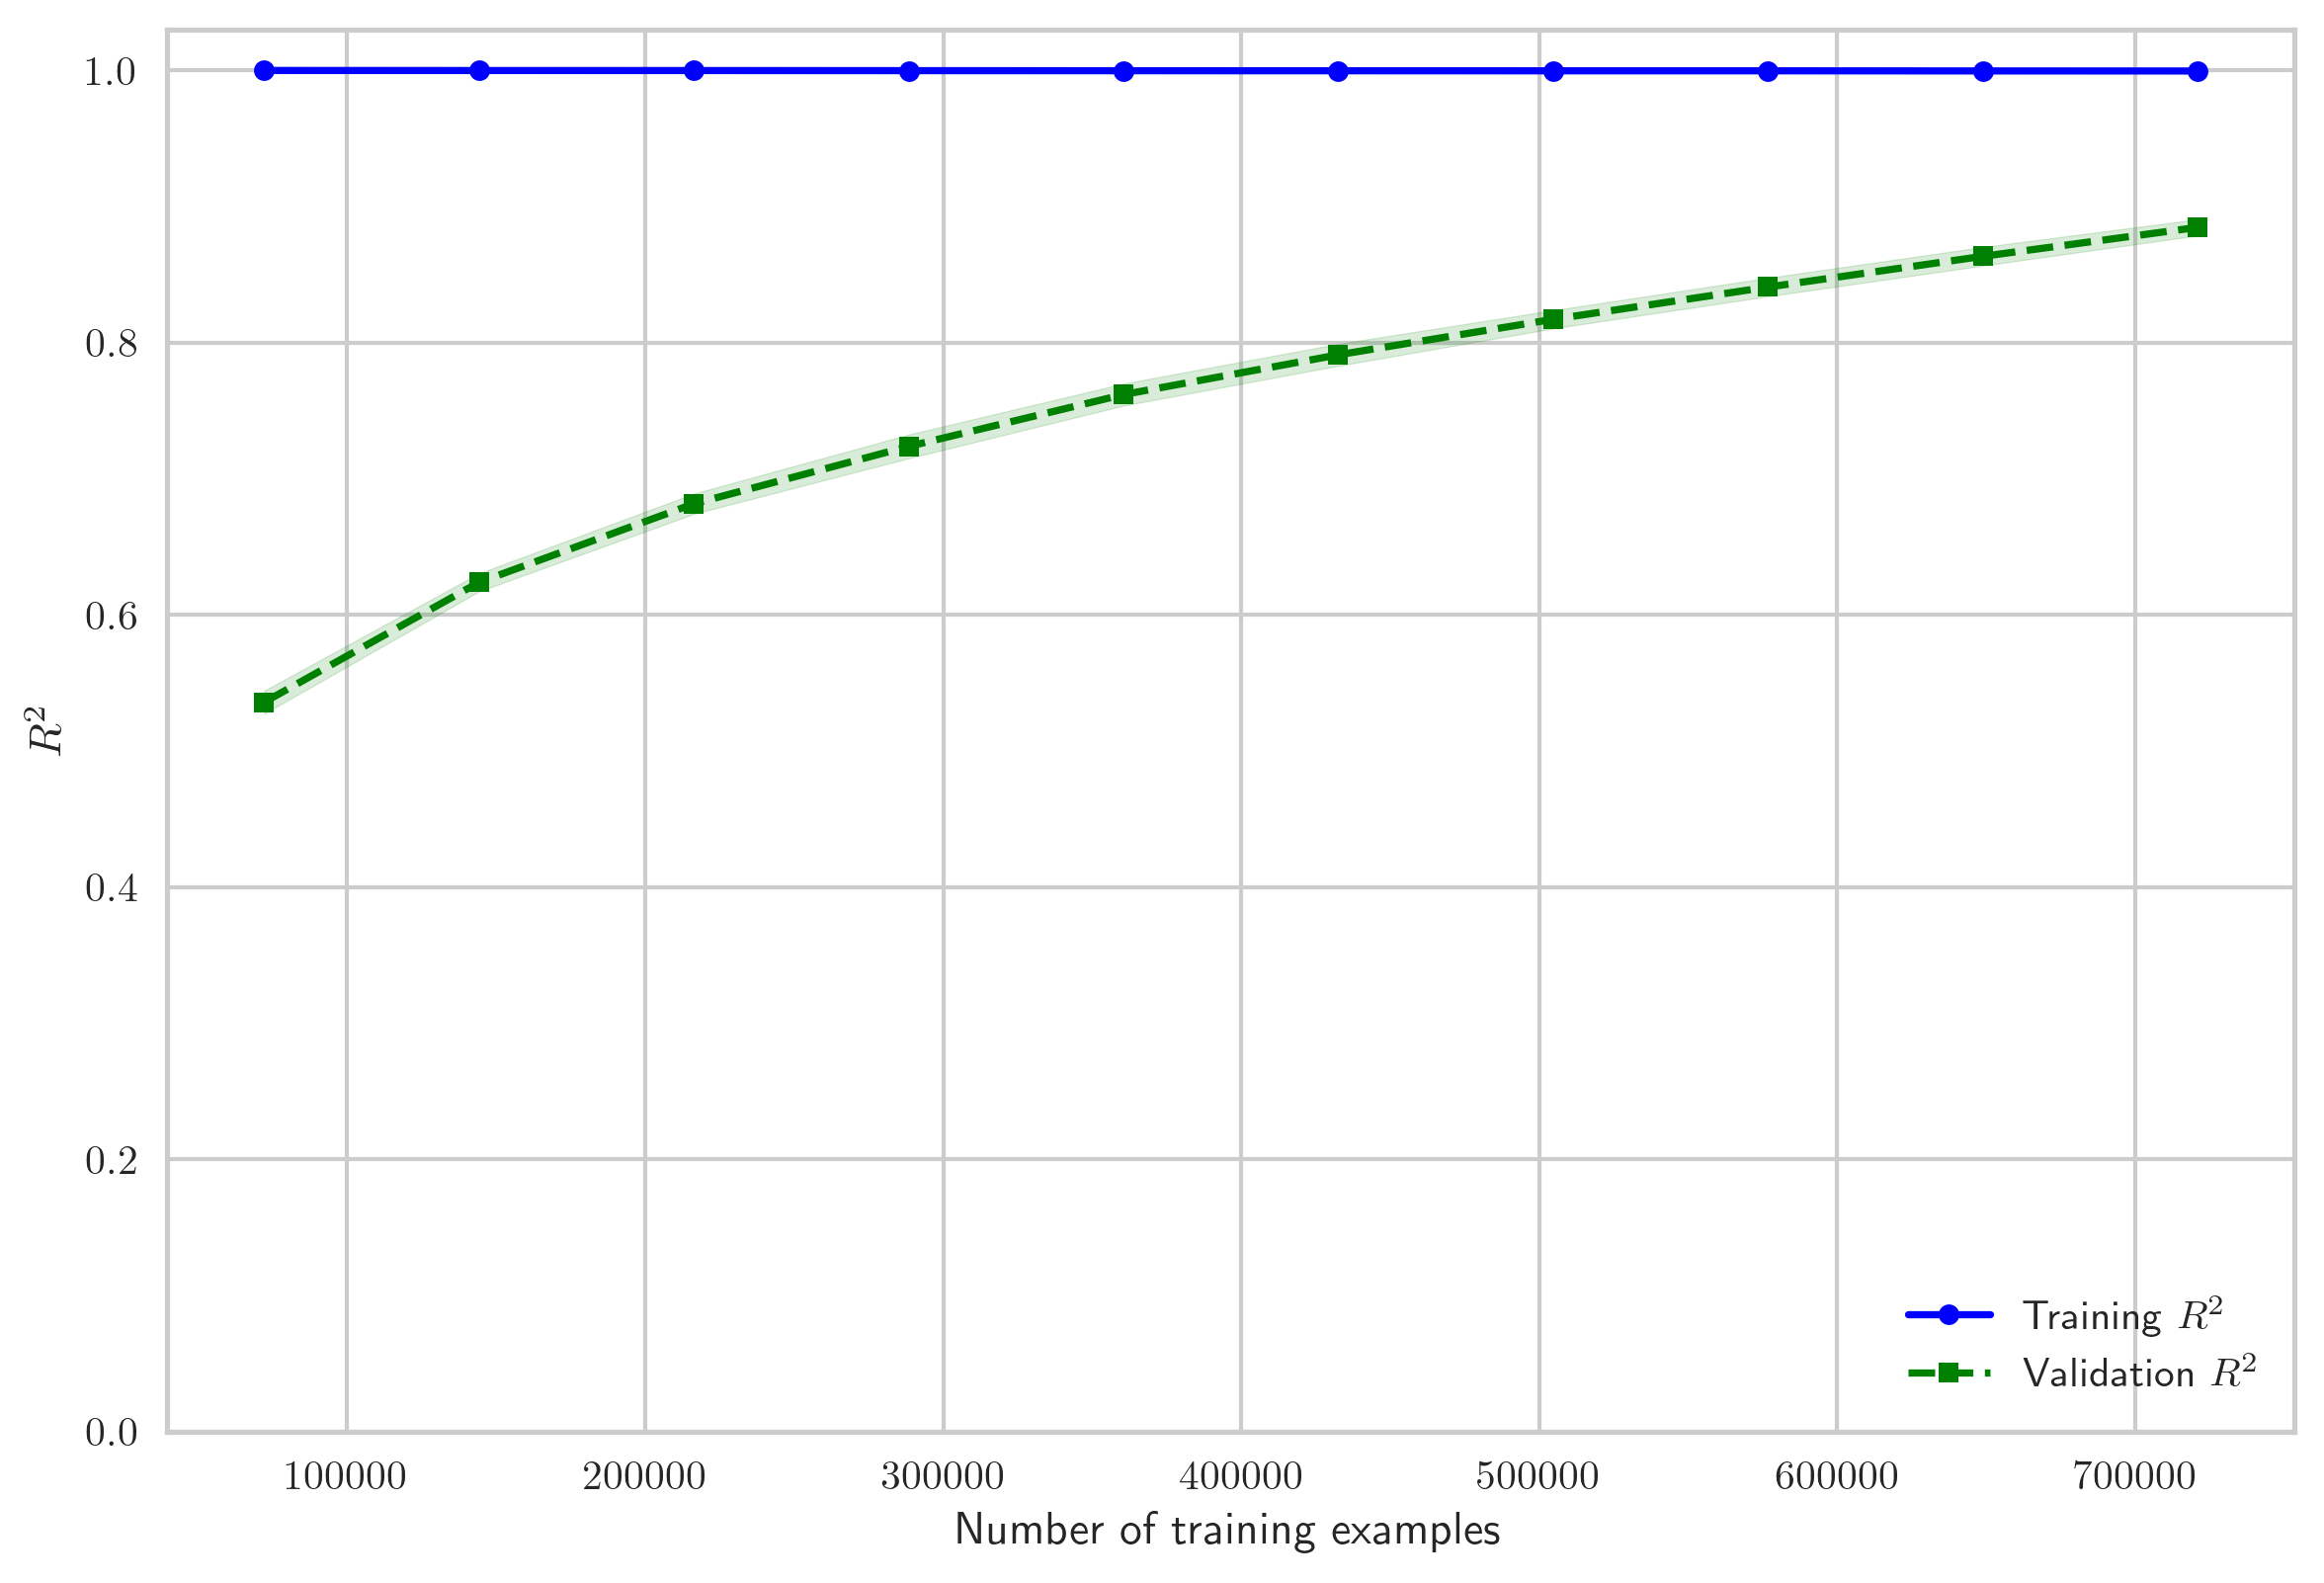

In [35]:
learning_curve_graph(
    *learning_curve(estimator=mc.models['Extra Trees'],
       X=X_train,
       y=y_train,
       train_sizes=np.linspace(0.1, 1.0, 10),
       cv=10,
       n_jobs=-1)
)

/usr/local/Caskroom/miniconda/base/envs/geospatial/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


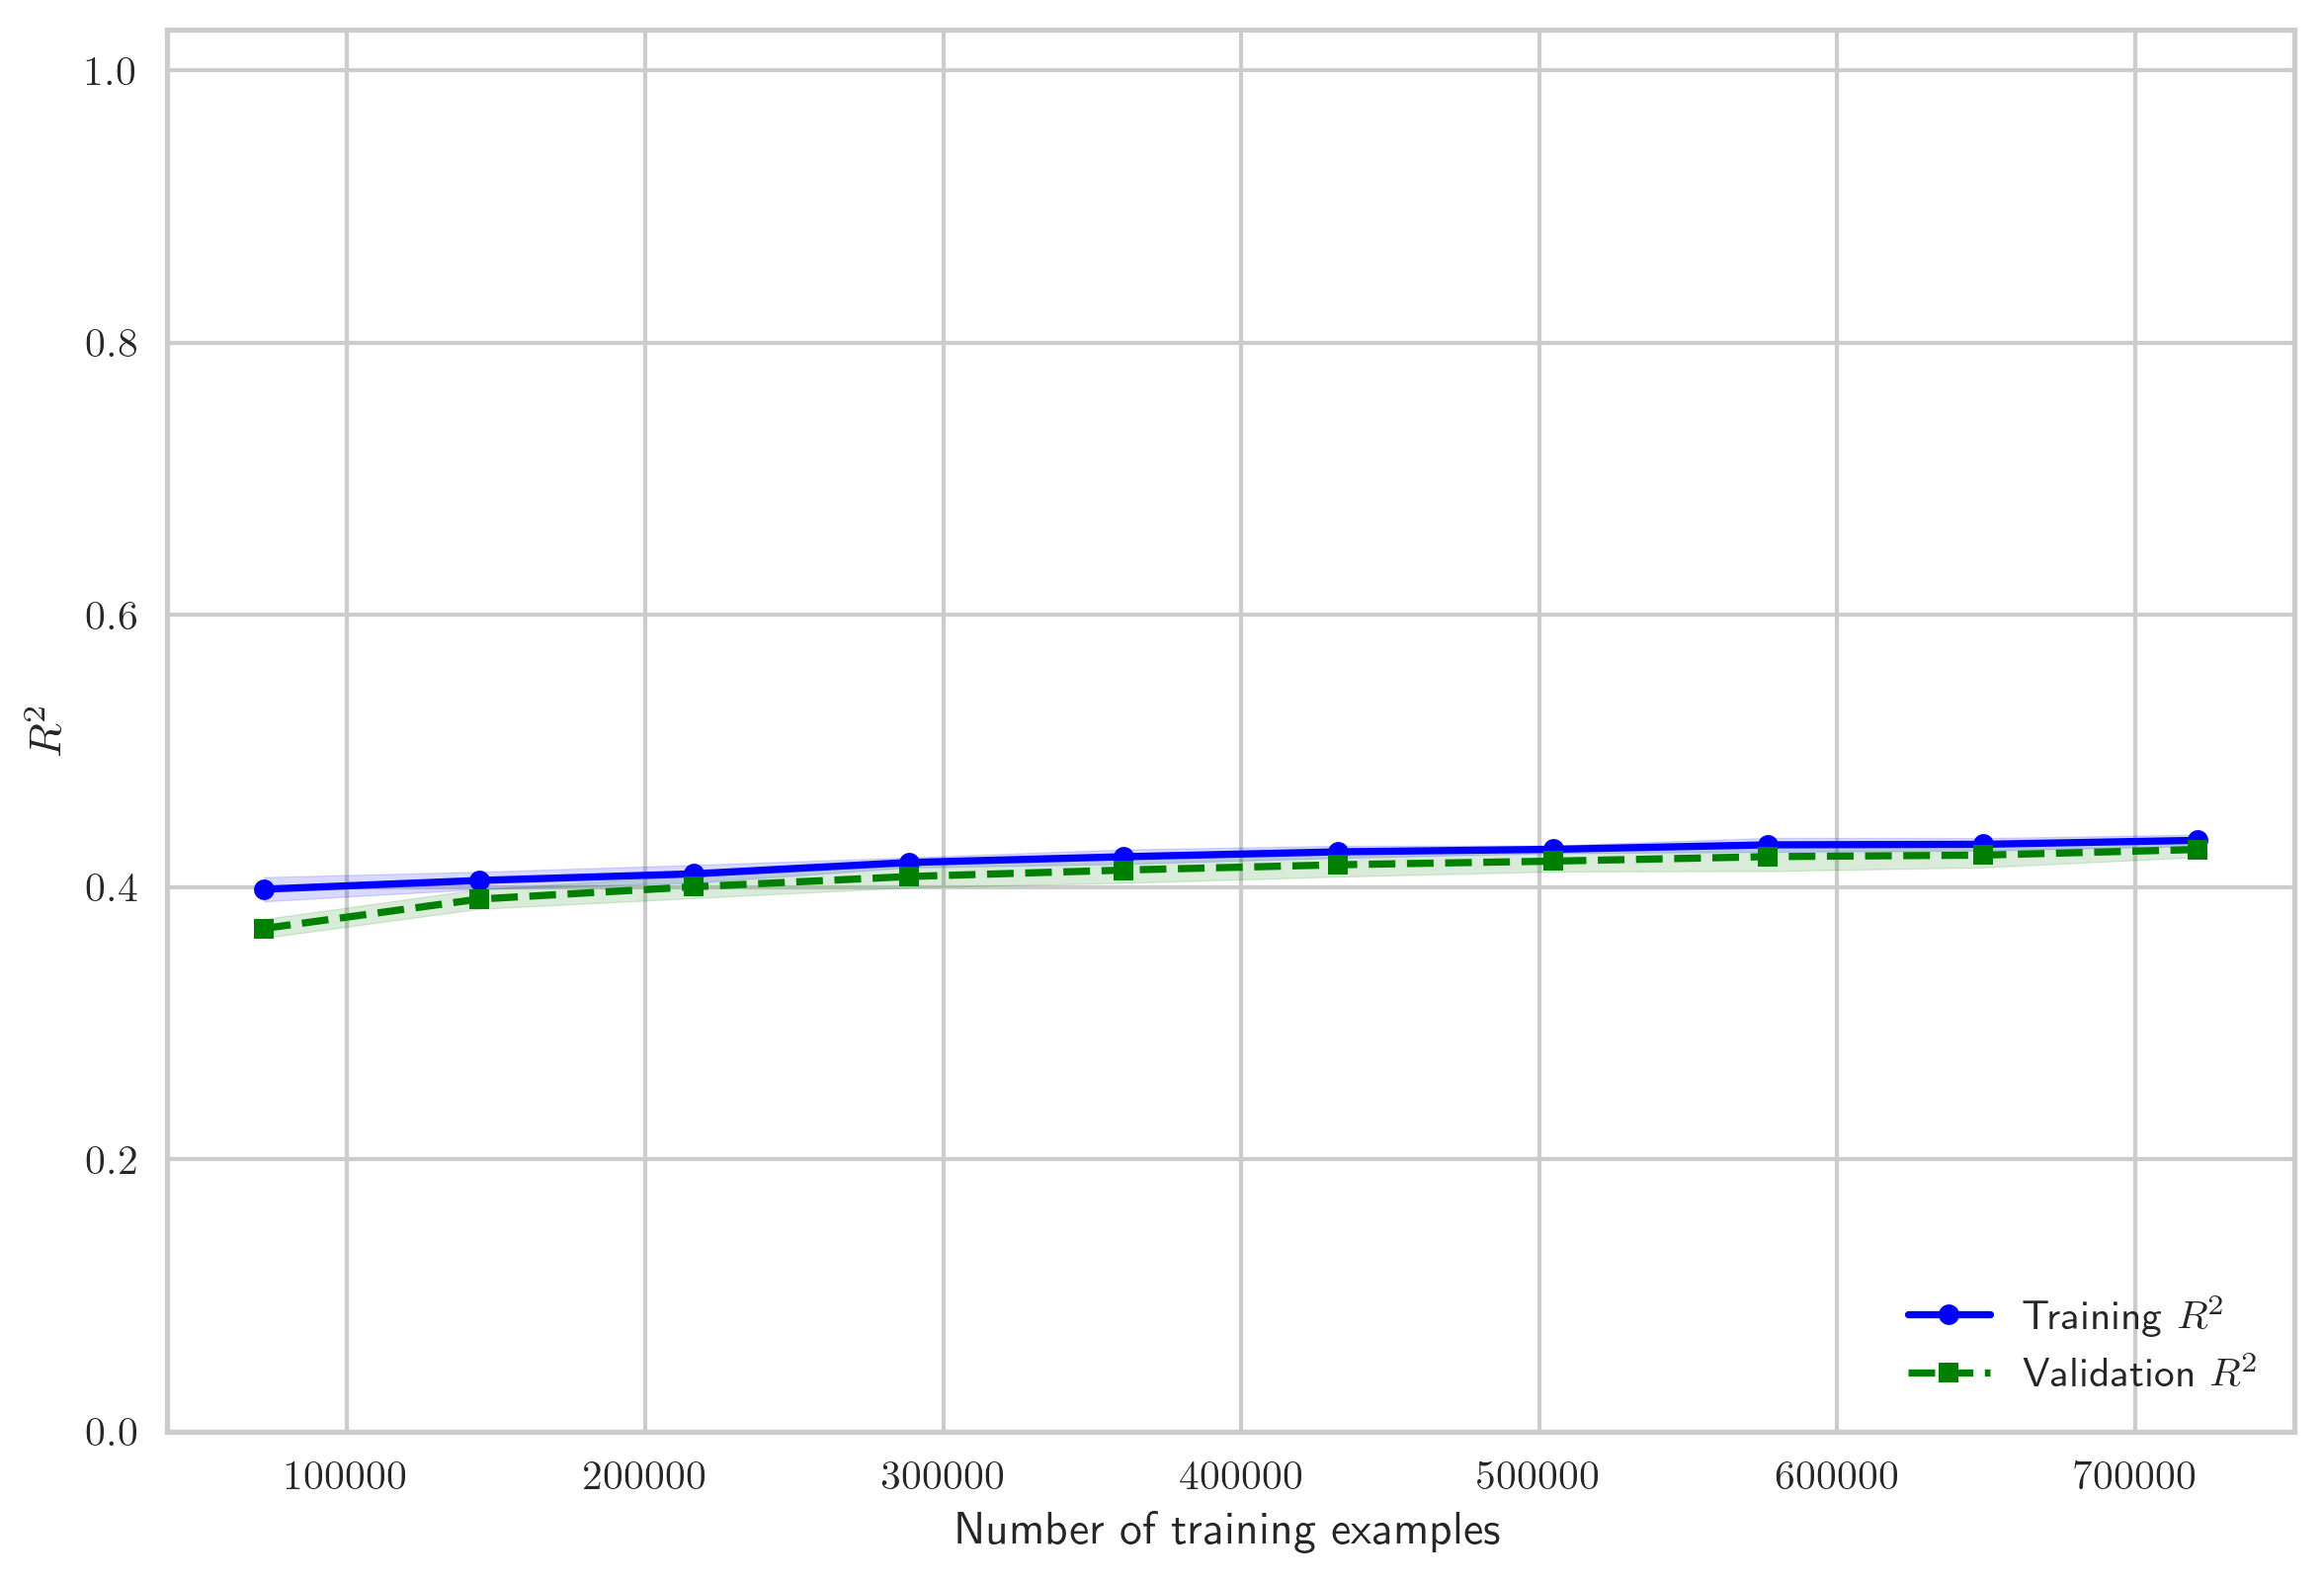

In [36]:
learning_curve_graph(
    *learning_curve(estimator=mc.models['MLP'],
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   cv=10,
                   n_jobs=-1)
)

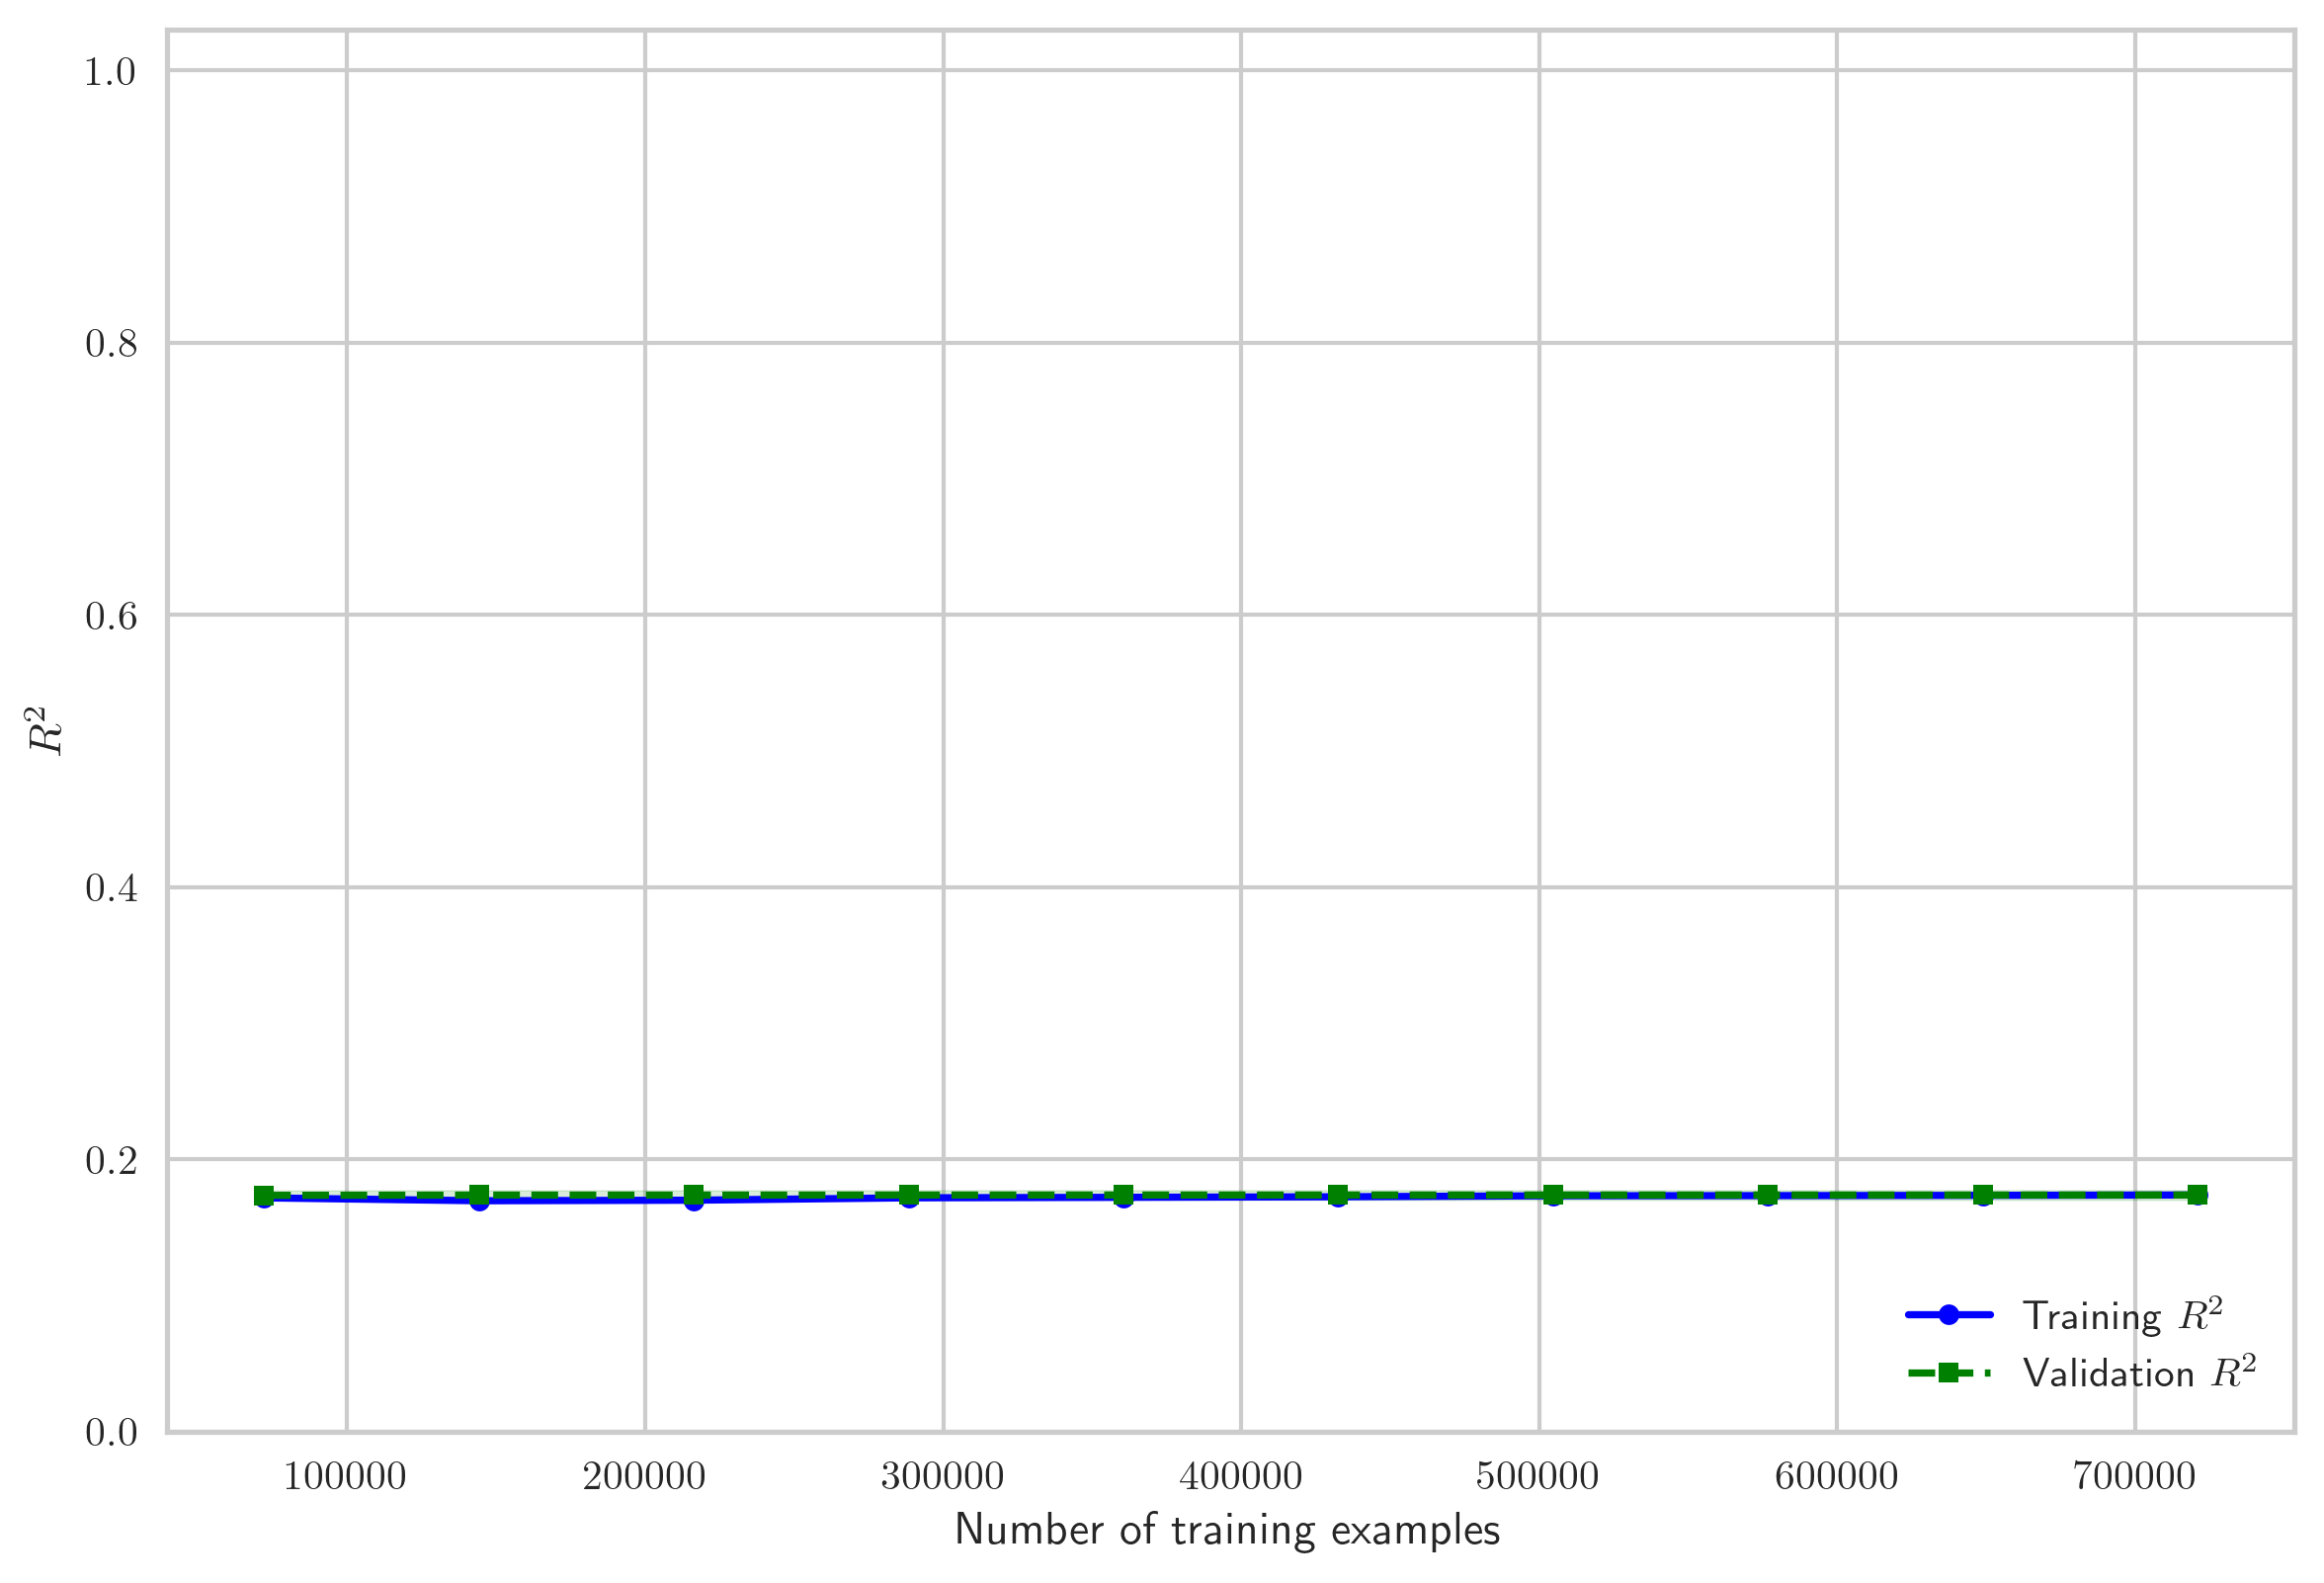

In [38]:
learning_curve_graph(
    *learning_curve(estimator=mc.models['Linear Regression'],
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   cv=10,
                   n_jobs=-1)
)

/usr/local/Caskroom/miniconda/base/envs/geospatial/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


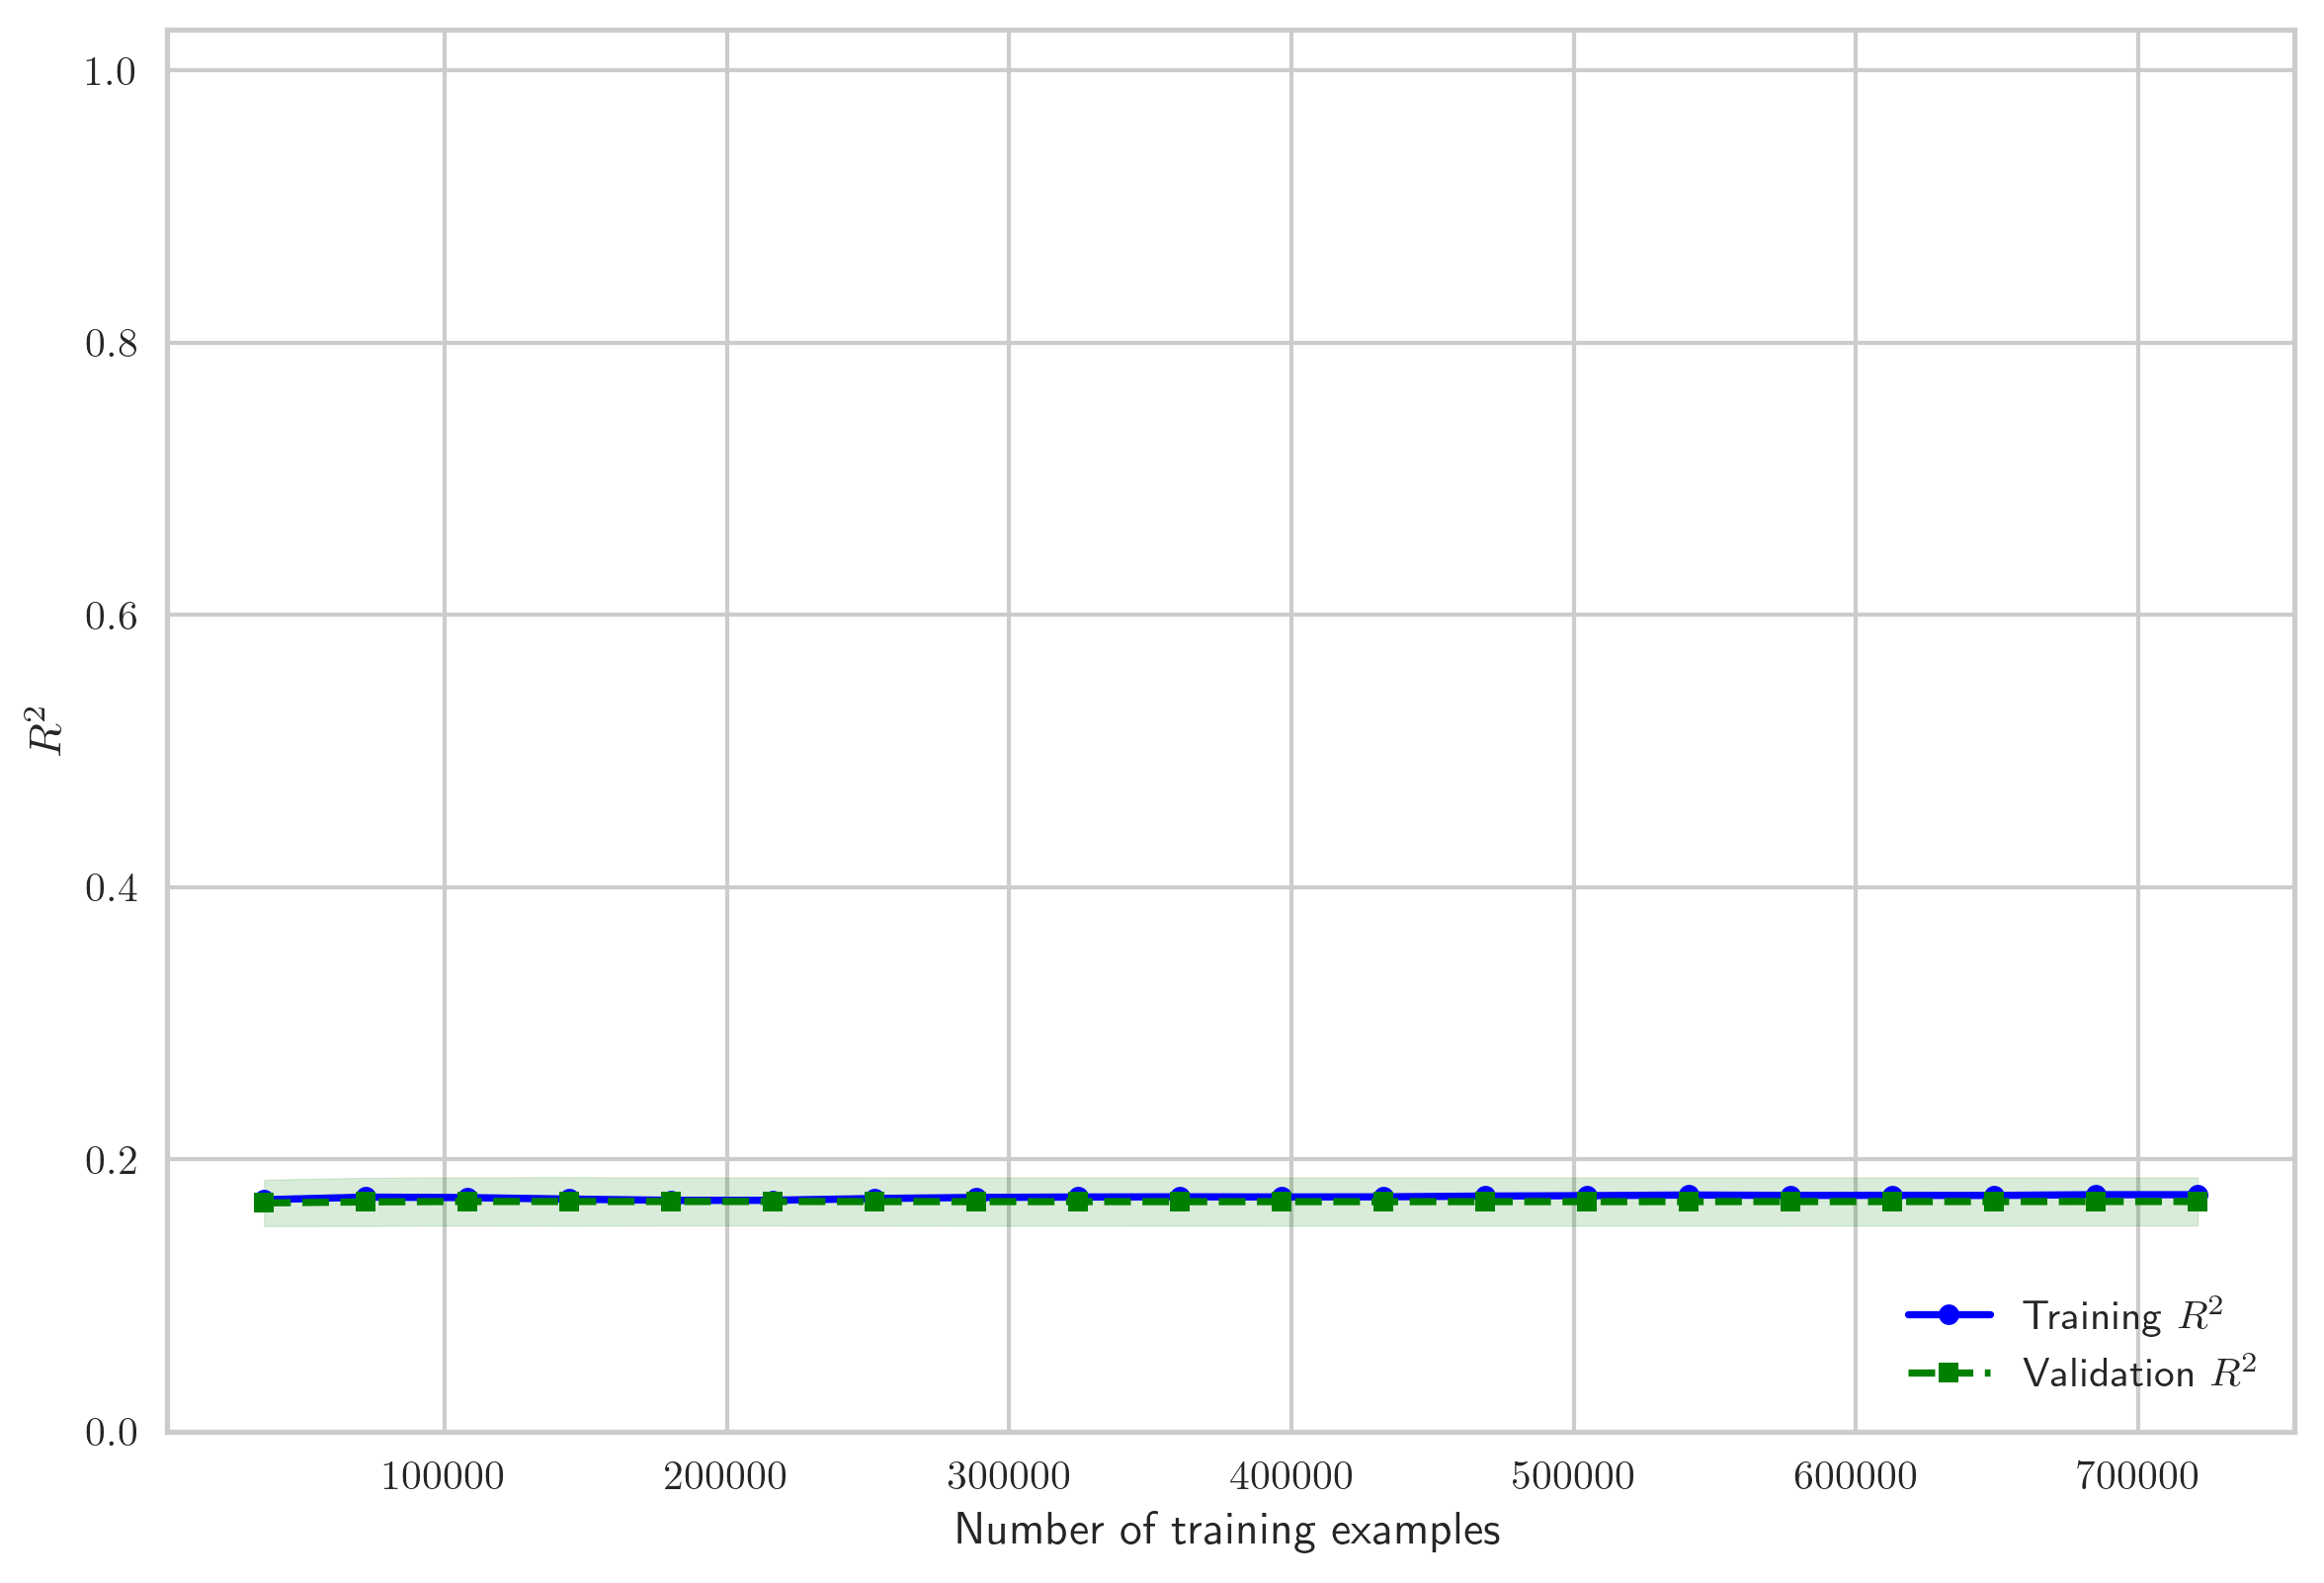

In [49]:
learning_curve_graph(
    *learning_curve(estimator=mc.models['Linear Regression'],
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   cv=gkf,
                   n_jobs=-1)
)

## Sequential Feature Inclusion

In [39]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

[based off of this](https://machinelearningmastery.com/rfe-feature-selection-in-python/), but used a [sequential feature selector instead](https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection)

In [40]:
def get_models(estimator, max_features = 10, cv = 5):
    models = dict()
    for i in range(1, max_features):
        rfe = SequentialFeatureSelector(estimator=estimator, n_features_to_select=i, cv=cv)
        model = estimator
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

def evaluate_model(model, X, y, cv = 5):
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    return scores

def get_results(model, n_feautres, X_train, y_train, cv=5):
    models = get_models(model, max_features=n_feautres, cv=cv)
    results, names = list(), list()
    
    pbar = tqdm(models.items())
    for name, model in pbar:
        pbar.set_description(name)
        scores = evaluate_model(model, X_train, y_train, cv=cv)
        results.append(scores)
        names.append(name)
        
    return results, names

In [41]:
lin_results, lin_names = get_results(mc.models['Linear Regression'], X.shape[1], X_train, y_train)

  0%|          | 0/25 [00:00<?, ?it/s]

In [43]:
res = {'results': [a.tolist() for a in lin_results], 'names': lin_names}

In [44]:
import json
    
with open("data/all_years_iterative_linear_regression_features.json", "w") as outfile:
    json.dump(res, outfile)

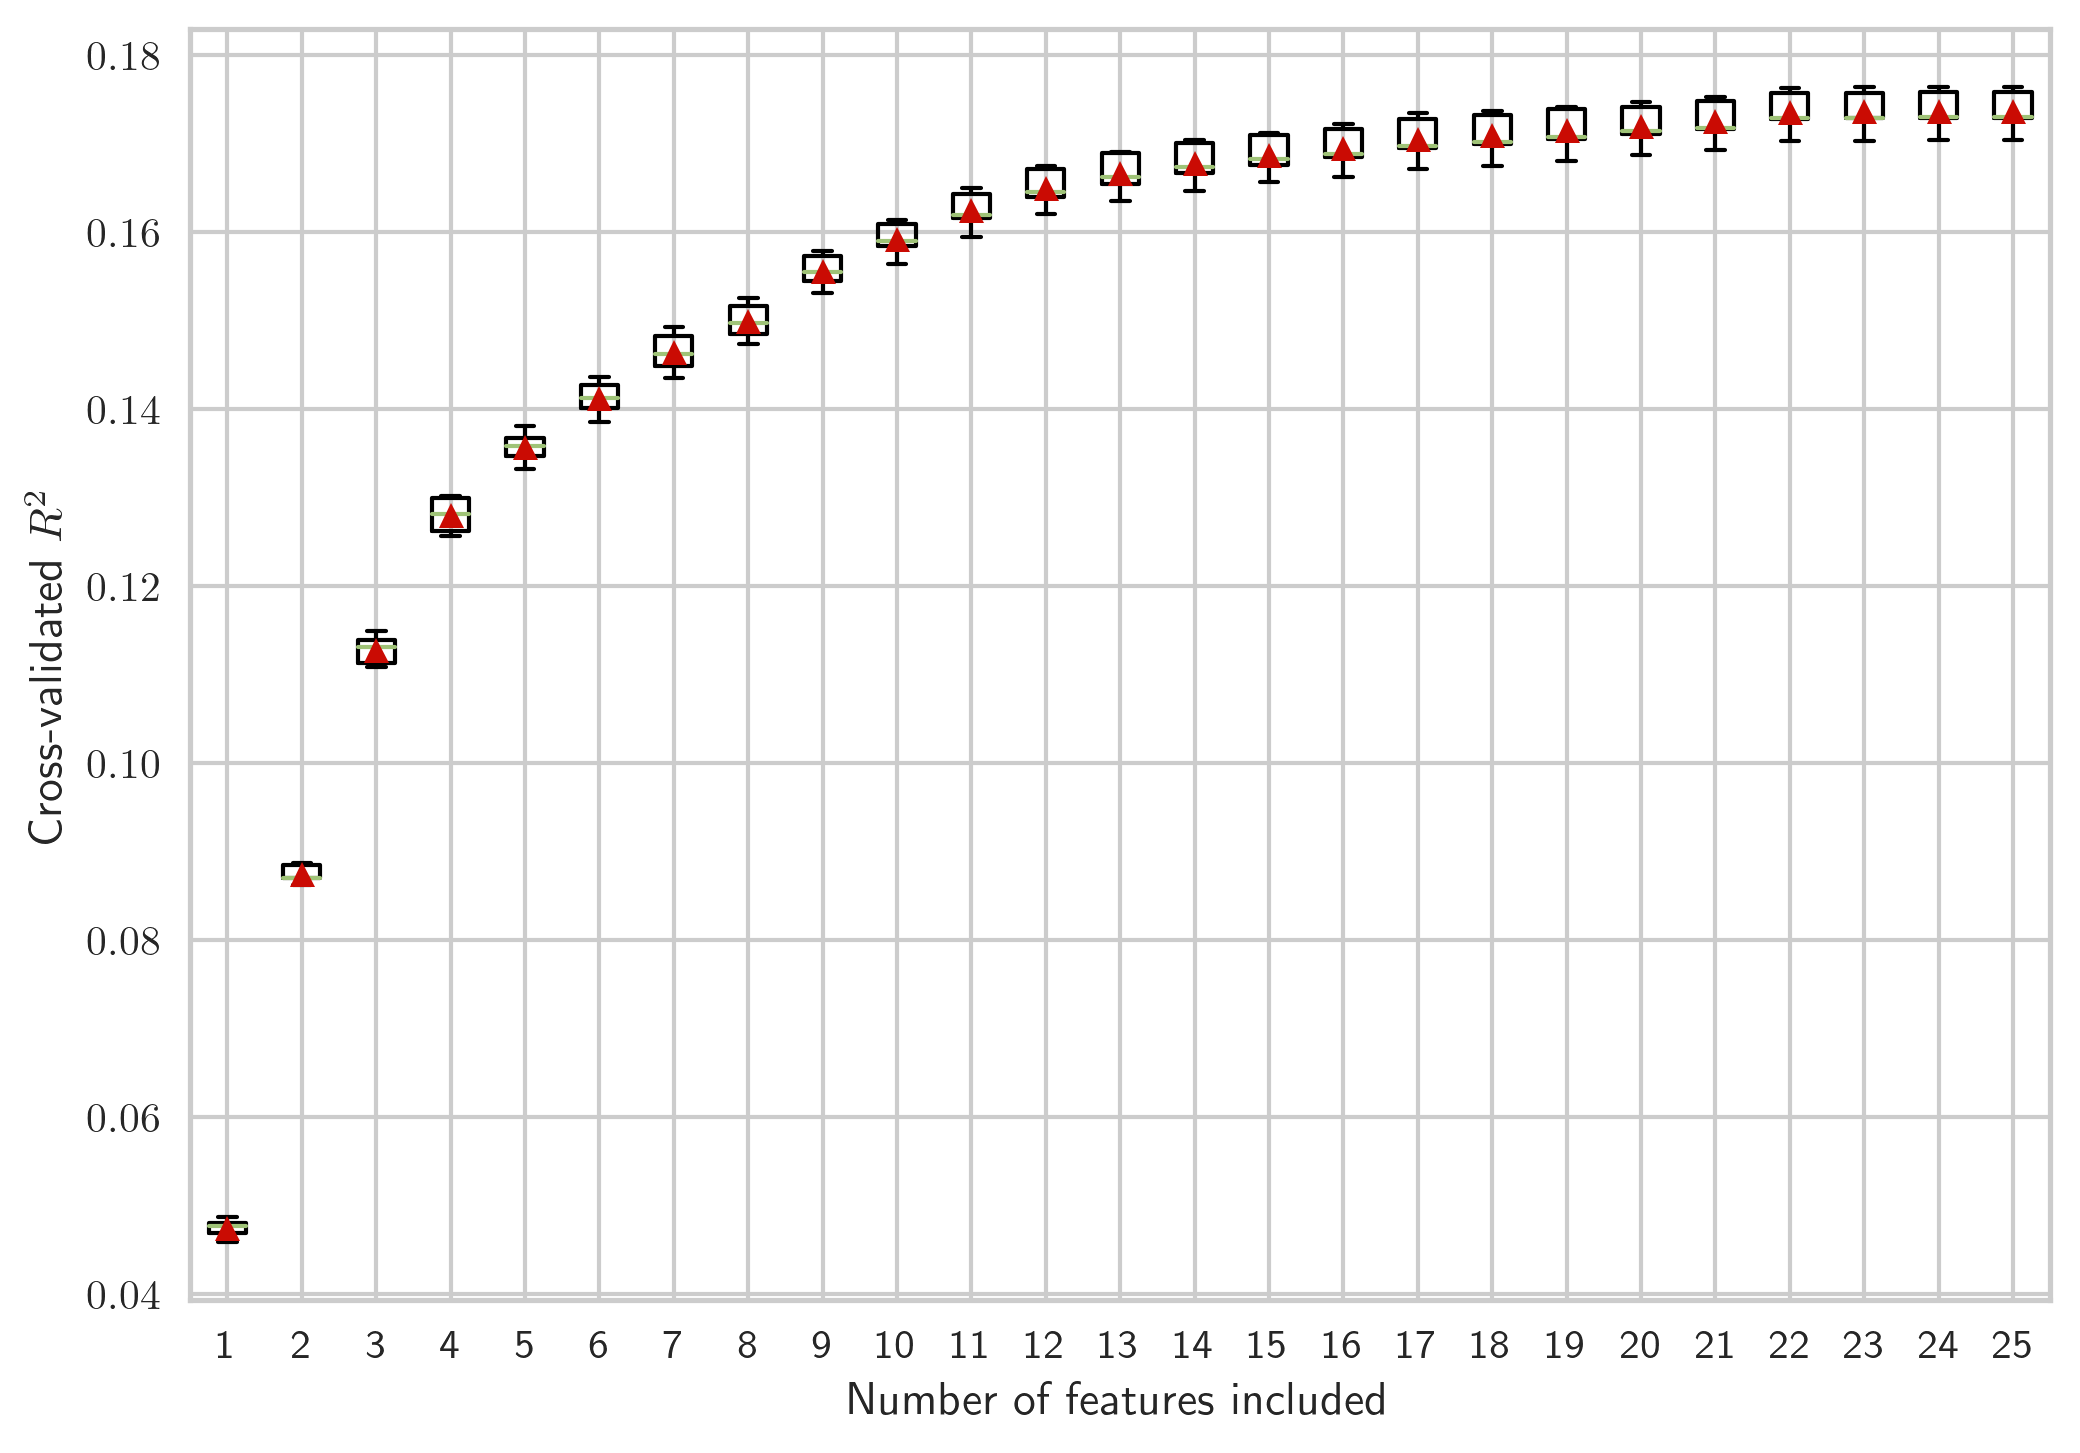

In [45]:
fig, ax = plt.subplots(dpi=300)

ax.set_xlabel('Number of features included')
ax.set_ylabel('Cross-validated $R^2$')

ax.boxplot(lin_results, labels=lin_names, showmeans=True);

In [45]:
et_imp_sorted = et_imp[np.argsort(et_imp, axis=0)[:,0][::-1]]
columns = X.columns.tolist()

In [ ]:
included = []
et_results, et_names = [], []
for a in et_imp_sorted[:,1]:
    included.append(columns.index(a))
    mc.x = X_train[:,np.array(included)]
    res = mc.compute_cross_validation_for_model('Extra Trees')
    et_results.append(res['Extra Trees'])
    et_names.append(str(len(included)))

In [ ]:
fig, ax = plt.subplots(dpi=300)

ax.set_xlabel('Number of features included')
ax.set_ylabel('Cross-validated $R^2$')

ax.boxplot(et_results, labels=et_names, showmeans=True);

## Predicting Maps

In [147]:
import cartopy.crs as ccrs
import metpy
import glob

In [148]:
files = sorted(glob.glob(f'/Volumes/Shores/matched/*.nc'))

In [149]:
with xr.open_dataset(files[0]) as aod:
    aod.load()

In [150]:
geo = aod.metpy.parse_cf('AOD').metpy.cartopy_crs
plate = ccrs.PlateCarree()
equal_area = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)

In [ ]:
for file in tqdm(files):
    with xr.open_dataset(file) as day:
        day.load()

    if 'Linear Regression' in day.data_vars:
        continue

    df = day.to_dataframe().drop(['goes_imager_projection'], axis=1).dropna().reset_index()

    df['month'] = df.t.dt.month
    df.month = df.month.astype('category')

    transformed = plate.transform_points(src_crs=geo, x=df['x'], y=df['y'])
    df['longitude'] = transformed[:,0]
    df['latitude'] = transformed[:,1]

    df = pd.get_dummies(df[df.columns.tolist()])

    for a in X.columns.difference(df.columns.tolist()):
        df[a] = np.full_like(df['AOD'], fill_value=0)

    x, y = df.x, df.y
    df = df.drop(df.columns.difference(X.columns.tolist()), axis=1)[X.columns.tolist()].reset_index(drop=True)

    prediction_dataset = df.to_numpy(dtype='float', na_value=np.nan)
    preds = mc.predict(prediction_dataset)

    for model in preds.keys():
        day[model] = xr.full_like(day.AOD, fill_value=np.nan)

    for idx, (i, j) in tqdm(enumerate(zip(x, y)), total=len(x)):
        day['Linear Regression'].loc[dict(x=i, y=j)] = preds['Linear Regression'][idx]
        day['Polynomial'].loc[dict(x=i, y=j)] = preds['Polynomial'][idx]
        day['Bayesian Ridge'].loc[dict(x=i, y=j)] = preds['Bayesian Ridge'][idx]
        day['MLP'].loc[dict(x=i, y=j)] = preds['MLP'][idx]
        day['Random Forest'].loc[dict(x=i, y=j)] = preds['Random Forest'][idx]
        day['Extra Trees'].loc[dict(x=i, y=j)] = preds['Extra Trees'][idx]
        day['XGBoost'].loc[dict(x=i, y=j)] = preds['XGBoost'][idx]

    attrs = {'long_name': 'Predicted PM2.5 Value', 'units': 'micrograms per cubic meter'}

    day['Linear Regression'].attrs = attrs
    day['Polynomial'].attrs = attrs
    day['Bayesian Ridge'].attrs = attrs
    day['MLP'].attrs = attrs
    day['Random Forest'].attrs = attrs
    day['Extra Trees'].attrs = attrs
    day['XGBoost'].attrs = attrs

    day.to_netcdf(file)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/508857 [00:00<?, ?it/s]

  0%|          | 0/448724 [00:00<?, ?it/s]

  0%|          | 0/320342 [00:00<?, ?it/s]

  0%|          | 0/243266 [00:00<?, ?it/s]

  0%|          | 0/248376 [00:00<?, ?it/s]

  0%|          | 0/334203 [00:00<?, ?it/s]

  0%|          | 0/526101 [00:00<?, ?it/s]

  0%|          | 0/641510 [00:00<?, ?it/s]

  0%|          | 0/593824 [00:00<?, ?it/s]

  0%|          | 0/546831 [00:00<?, ?it/s]

  0%|          | 0/626849 [00:00<?, ?it/s]

  0%|          | 0/659566 [00:00<?, ?it/s]

  0%|          | 0/545811 [00:00<?, ?it/s]

  0%|          | 0/474574 [00:00<?, ?it/s]

  0%|          | 0/418781 [00:00<?, ?it/s]

  0%|          | 0/445460 [00:00<?, ?it/s]

  0%|          | 0/356188 [00:00<?, ?it/s]

  0%|          | 0/304964 [00:00<?, ?it/s]

  0%|          | 0/348388 [00:00<?, ?it/s]

  0%|          | 0/384429 [00:00<?, ?it/s]

  0%|          | 0/252651 [00:00<?, ?it/s]

  0%|          | 0/311671 [00:00<?, ?it/s]

  0%|          | 0/446533 [00:00<?, ?it/s]

  0%|          | 0/636161 [00:00<?, ?it/s]

  0%|          | 0/674356 [00:00<?, ?it/s]

  0%|          | 0/631829 [00:00<?, ?it/s]

  0%|          | 0/423447 [00:00<?, ?it/s]

  0%|          | 0/291980 [00:00<?, ?it/s]

  0%|          | 0/424947 [00:00<?, ?it/s]

  0%|          | 0/371240 [00:00<?, ?it/s]

  0%|          | 0/471164 [00:00<?, ?it/s]

  0%|          | 0/505730 [00:00<?, ?it/s]

  0%|          | 0/492309 [00:00<?, ?it/s]

  0%|          | 0/761325 [00:00<?, ?it/s]

  0%|          | 0/590808 [00:00<?, ?it/s]

  0%|          | 0/551911 [00:00<?, ?it/s]

  0%|          | 0/721426 [00:00<?, ?it/s]

  0%|          | 0/758585 [00:00<?, ?it/s]

  0%|          | 0/737264 [00:00<?, ?it/s]

  0%|          | 0/707043 [00:00<?, ?it/s]

  0%|          | 0/717504 [00:00<?, ?it/s]

  0%|          | 0/650862 [00:00<?, ?it/s]

  0%|          | 0/582332 [00:00<?, ?it/s]

  0%|          | 0/609930 [00:00<?, ?it/s]

  0%|          | 0/601252 [00:00<?, ?it/s]

  0%|          | 0/545253 [00:00<?, ?it/s]

  0%|          | 0/671883 [00:00<?, ?it/s]

  0%|          | 0/623086 [00:00<?, ?it/s]

  0%|          | 0/633113 [00:00<?, ?it/s]

  0%|          | 0/480158 [00:00<?, ?it/s]

  0%|          | 0/371782 [00:00<?, ?it/s]

  0%|          | 0/275997 [00:00<?, ?it/s]

  0%|          | 0/359942 [00:00<?, ?it/s]

  0%|          | 0/657747 [00:00<?, ?it/s]

  0%|          | 0/652710 [00:00<?, ?it/s]

  0%|          | 0/614168 [00:00<?, ?it/s]

  0%|          | 0/654836 [00:00<?, ?it/s]

  0%|          | 0/674862 [00:00<?, ?it/s]

  0%|          | 0/486421 [00:00<?, ?it/s]

  0%|          | 0/561533 [00:00<?, ?it/s]

  0%|          | 0/706138 [00:00<?, ?it/s]

  0%|          | 0/566422 [00:00<?, ?it/s]

  0%|          | 0/424285 [00:00<?, ?it/s]

  0%|          | 0/461936 [00:00<?, ?it/s]

  0%|          | 0/453201 [00:00<?, ?it/s]

  0%|          | 0/622765 [00:00<?, ?it/s]

  0%|          | 0/697432 [00:00<?, ?it/s]

  0%|          | 0/533030 [00:00<?, ?it/s]

  0%|          | 0/456530 [00:00<?, ?it/s]

  0%|          | 0/539427 [00:00<?, ?it/s]

  0%|          | 0/650372 [00:00<?, ?it/s]

  0%|          | 0/791326 [00:00<?, ?it/s]

  0%|          | 0/781622 [00:00<?, ?it/s]

  0%|          | 0/692516 [00:00<?, ?it/s]

  0%|          | 0/549749 [00:00<?, ?it/s]

  0%|          | 0/521560 [00:00<?, ?it/s]

  0%|          | 0/516778 [00:00<?, ?it/s]

  0%|          | 0/605670 [00:00<?, ?it/s]

  0%|          | 0/787965 [00:00<?, ?it/s]

  0%|          | 0/781412 [00:00<?, ?it/s]

  0%|          | 0/644560 [00:00<?, ?it/s]

  0%|          | 0/548912 [00:00<?, ?it/s]

  0%|          | 0/462875 [00:00<?, ?it/s]

  0%|          | 0/440695 [00:00<?, ?it/s]

  0%|          | 0/458962 [00:00<?, ?it/s]

  0%|          | 0/552498 [00:00<?, ?it/s]

  0%|          | 0/541759 [00:00<?, ?it/s]

  0%|          | 0/423480 [00:00<?, ?it/s]

  0%|          | 0/602215 [00:00<?, ?it/s]

  0%|          | 0/597575 [00:00<?, ?it/s]

  0%|          | 0/704157 [00:00<?, ?it/s]

  0%|          | 0/741046 [00:00<?, ?it/s]

  0%|          | 0/643188 [00:00<?, ?it/s]

  0%|          | 0/536672 [00:00<?, ?it/s]

  0%|          | 0/589072 [00:00<?, ?it/s]

  0%|          | 0/527857 [00:00<?, ?it/s]

  0%|          | 0/570793 [00:00<?, ?it/s]

  0%|          | 0/524169 [00:00<?, ?it/s]

  0%|          | 0/510430 [00:00<?, ?it/s]

  0%|          | 0/555522 [00:00<?, ?it/s]

  0%|          | 0/646770 [00:00<?, ?it/s]

  0%|          | 0/663826 [00:00<?, ?it/s]

  0%|          | 0/620323 [00:00<?, ?it/s]

  0%|          | 0/559331 [00:00<?, ?it/s]

  0%|          | 0/560282 [00:00<?, ?it/s]

  0%|          | 0/628005 [00:00<?, ?it/s]

  0%|          | 0/664445 [00:00<?, ?it/s]

  0%|          | 0/693412 [00:00<?, ?it/s]

  0%|          | 0/767850 [00:00<?, ?it/s]

  0%|          | 0/794898 [00:00<?, ?it/s]

  0%|          | 0/793683 [00:00<?, ?it/s]

  0%|          | 0/806562 [00:00<?, ?it/s]

  0%|          | 0/813616 [00:00<?, ?it/s]

  0%|          | 0/805491 [00:00<?, ?it/s]

  0%|          | 0/746380 [00:00<?, ?it/s]

  0%|          | 0/631378 [00:00<?, ?it/s]

  0%|          | 0/692497 [00:00<?, ?it/s]

  0%|          | 0/674546 [00:00<?, ?it/s]

  0%|          | 0/677255 [00:00<?, ?it/s]

  0%|          | 0/766520 [00:00<?, ?it/s]

  0%|          | 0/717037 [00:00<?, ?it/s]

  0%|          | 0/756846 [00:00<?, ?it/s]

  0%|          | 0/774184 [00:00<?, ?it/s]

  0%|          | 0/771249 [00:00<?, ?it/s]

  0%|          | 0/754861 [00:00<?, ?it/s]

  0%|          | 0/706061 [00:00<?, ?it/s]

  0%|          | 0/692075 [00:00<?, ?it/s]

  0%|          | 0/638229 [00:00<?, ?it/s]

  0%|          | 0/597834 [00:00<?, ?it/s]

  0%|          | 0/581409 [00:00<?, ?it/s]

  0%|          | 0/608123 [00:00<?, ?it/s]

  0%|          | 0/616259 [00:00<?, ?it/s]

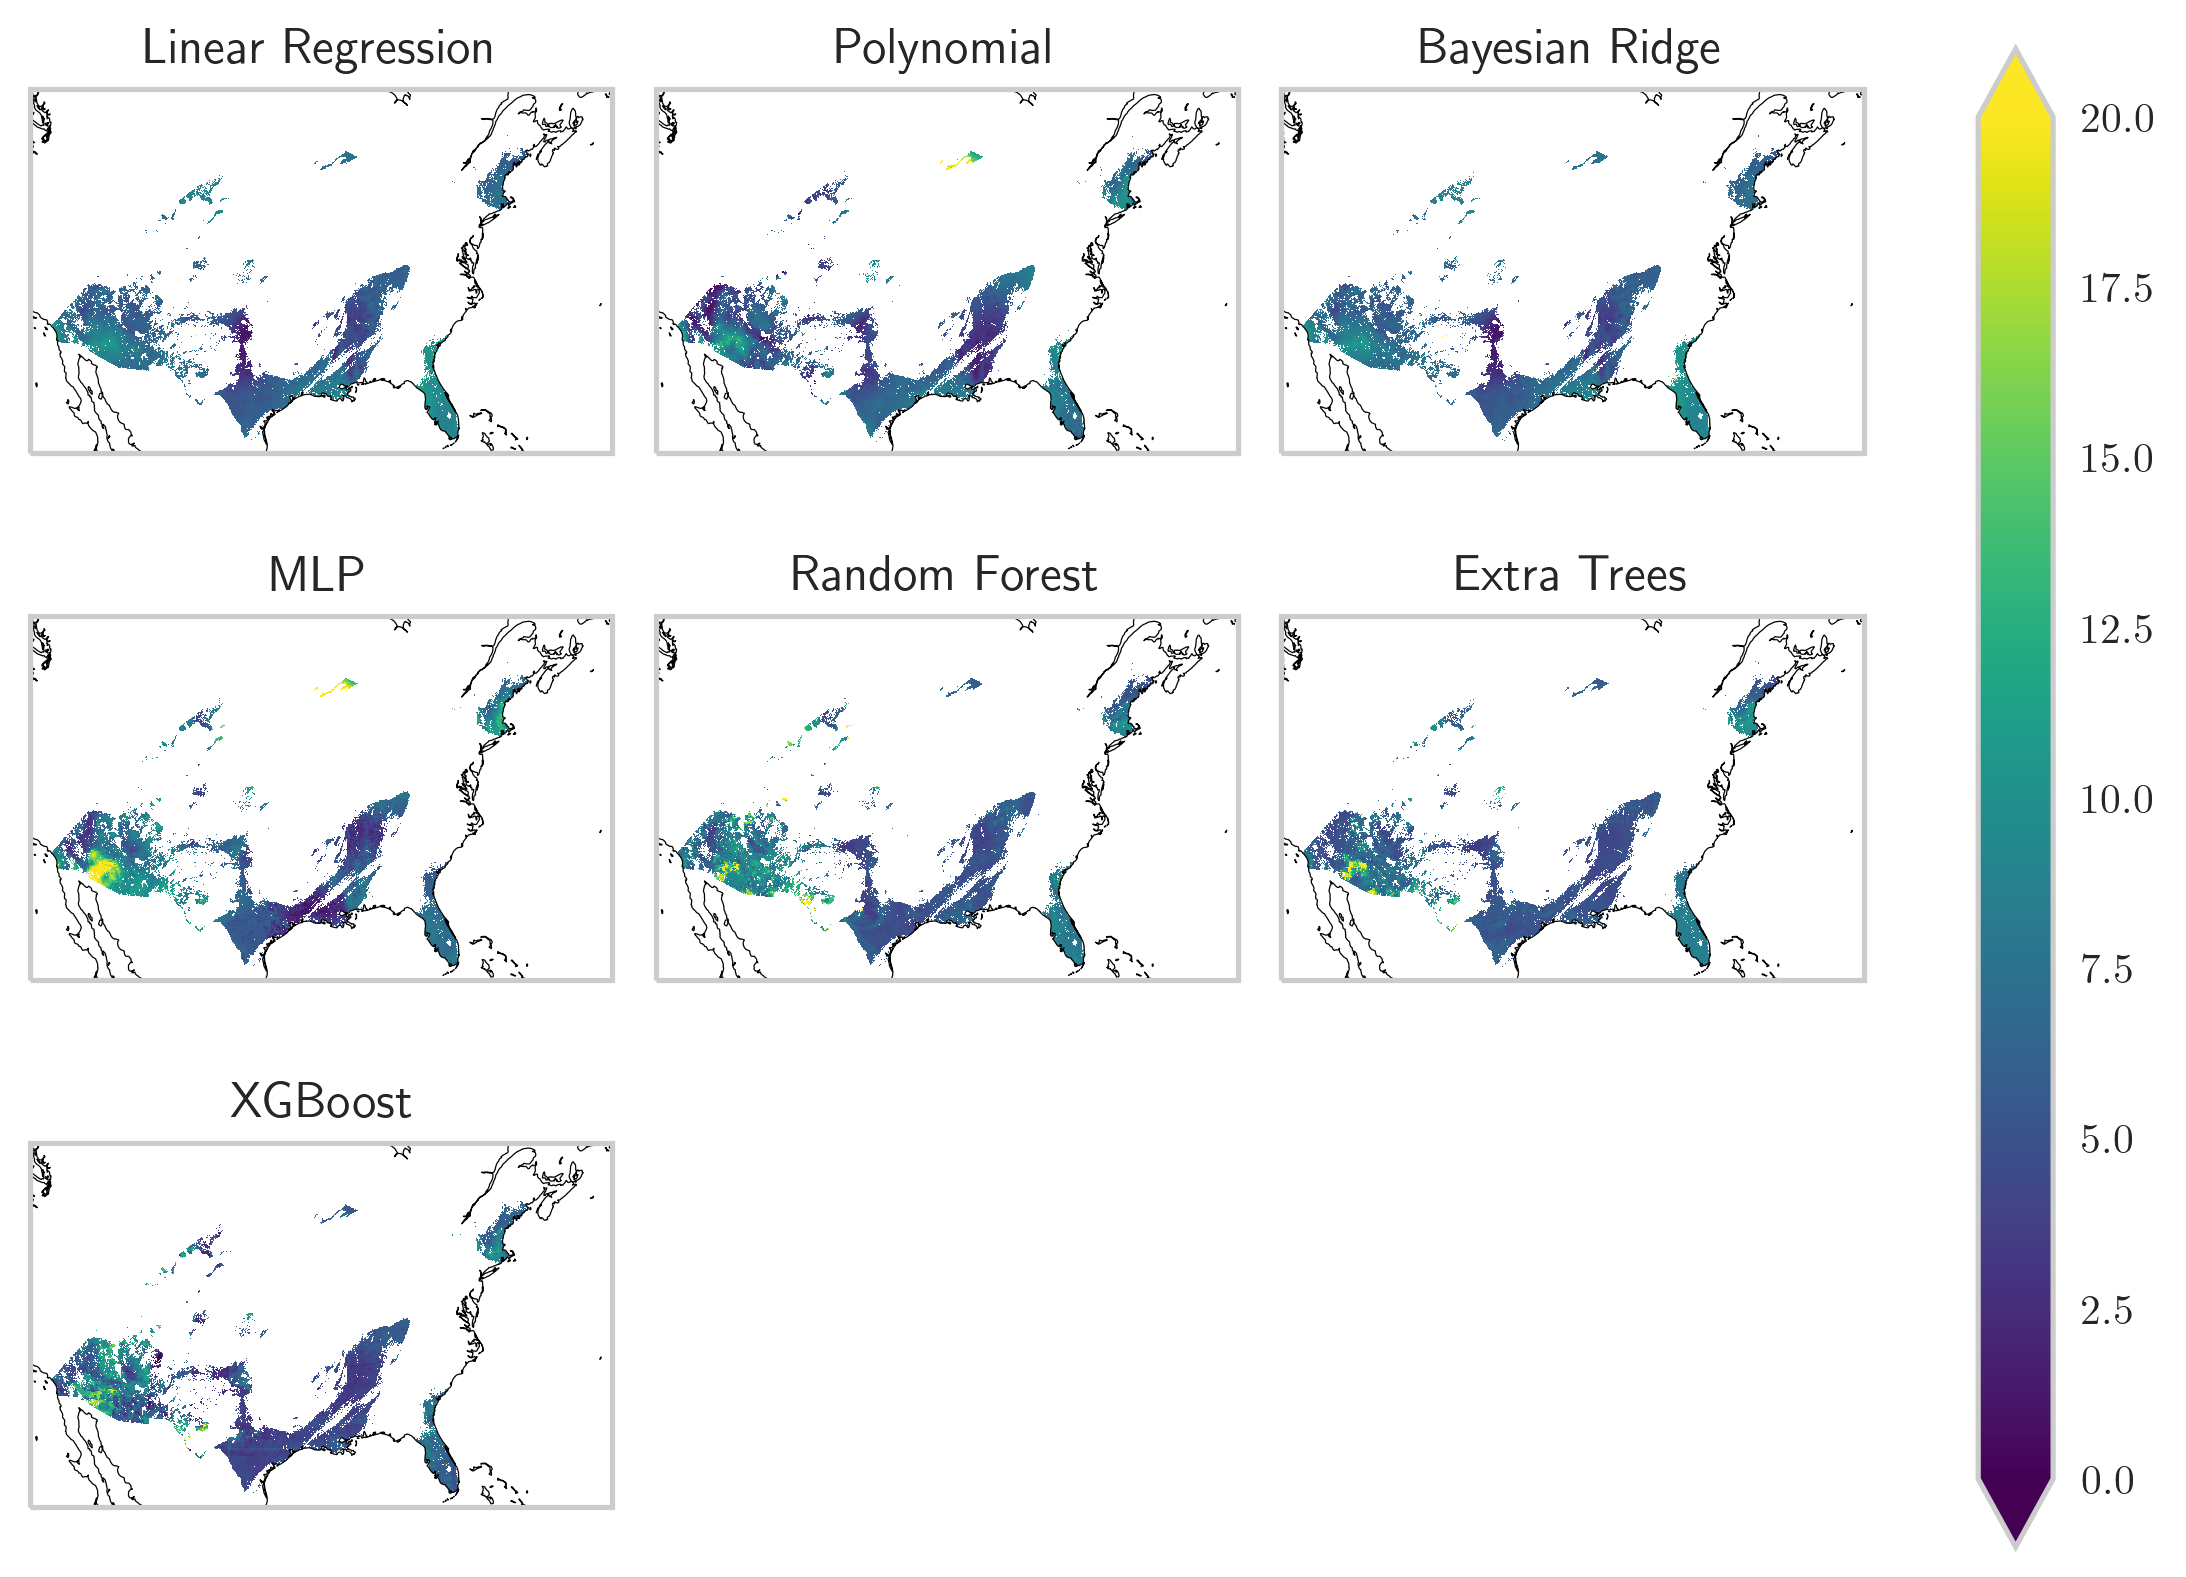

In [133]:
fig, axes = plt.subplots(3, 3, dpi=300, subplot_kw=dict(projection=equal_area))

axs = iter(axes.ravel())

for c in preds.keys():
    ax = next(axs)

    a = day[c].plot(ax=ax, transform=geo, vmin=0, vmax=20, add_colorbar=False)
    ax.coastlines()
    ax.set_extent([-118, -66.5, 25, 50], plate)
    ax.set_title(c)

fig.tight_layout()
cbar = fig.colorbar(a, ax=axes.ravel().tolist(), extend='both')
# cbar.set_label('Number of points')

for ax in axs:
    ax.set_visible(False)